#*SCRAPING DATA*

In [ ]:
!pip install google-play-scraper

In [ ]:
from google_play_scraper import app, reviews
import pandas as pd
import datetime
import numpy as np


In [ ]:
from google_play_scraper import Sort
app_id = 'id.co.collega.mbanking.sulut'

def get_review(app_id, lang='id', count=3000, sort=Sort.NEWEST, filter_score_with=None, filter_device_with=None, continuation_token=None):
  try:
    result, continuation_token = reviews(
        app_id,
        lang=lang,
        country='id',
        sort=sort,
        count=count,
        filter_score_with=filter_score_with,
        filter_device_with=filter_device_with,
        continuation_token=continuation_token
    )

    return result, continuation_token
  except Exception as e:
    print(e)
    return None, None

reviews, continuation_token = get_review(app_id)

if reviews is not None:
  print("Jumlah Ulasan:", len(reviews))
  if len(reviews) > 0:
    print("Contoh Ulasan:")
    print(reviews[0])

else:
  print("Tidak Dapat Mengambil Ulasan.")



Jumlah Ulasan: 2573
Contoh Ulasan:
{'reviewId': 'eb88180f-0374-498c-bcba-3e3e57f62511', 'userName': 'Pengguna Google', 'userImage': 'https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g', 'content': 'kenapa ini aplikasi saat ini tidak bisa terbuka', 'score': 5, 'thumbsUpCount': 0, 'reviewCreatedVersion': '6.4.6', 'at': datetime.datetime(2025, 9, 11, 10, 41, 36), 'replyContent': 'Terima kasih telah menggunakan BSGtouch. Mohon maaf atas ketidaknyamanan yang dialami dan untuk informasi lebih lanjut, Bpk/Ibu dapat menghubungi Call Center 1500659 atau Kantor BSG terdekat. Terima kasih.', 'repliedAt': datetime.datetime(2025, 9, 11, 23, 30, 48), 'appVersion': '6.4.6'}


In [ ]:
import pandas as pd
from google_play_scraper import reviews, Sort
import datetime # Import datetime untuk mendefinisikan tanggal filter

app_id = 'id.co.collega.mbanking.sulut' # Menggunakan app_id yang sudah ada

def get_all_reviews(app_id, lang='id', country='id', sort=Sort.NEWEST, count=3000, filter_score_with=None, filter_device_with=None):
    all_reviews = []
    continuation_token = None

    print(f"Memulai pengambilan ulasan untuk aplikasi '{app_id}'...")
    retries = 3 # Jumlah percobaan ulang jika terjadi error sementara
    attempt = 0

    while True:
        attempt += 1
        print(f"  Percobaan {attempt} untuk mengambil batch ulasan...")
        try:
            # Menggunakan count=3000 (maksimum yang didukung per batch)
            result, continuation_token = reviews(
                app_id,
                lang=lang,
                country=country,
                sort=sort,
                count=count, # Ambil ulasan dalam batch (diperbarui ke 3000)
                filter_score_with=filter_score_with,
                filter_device_with=filter_device_with,
                continuation_token=continuation_token
            )

            if not result: # Berhenti jika tidak ada ulasan lagi di batch ini
                print("  Tidak ada ulasan lagi di batch ini. Menghentikan pengambilan.")
                break

            print(f"  Berhasil mengambil {len(result)} ulasan dalam batch ini.")
            all_reviews.extend(result)
            retries = 3 # Reset hitungan percobaan ulang setelah berhasil

            # Jika tidak ada continuation_token lagi, berarti sudah mencapai akhir ulasan
            if continuation_token is None:
                print("  Tidak ada continuation token lagi. Menghentikan pengambilan.")
                break

        except Exception as e:
            print(f"  Terjadi kesalahan saat mengambil ulasan: {e}")
            if attempt < retries:
                print(f"  Mencoba kembali ({retries - attempt} percobaan tersisa)...")
                # Anda bisa menambahkan delay di sini jika diinginkan, misal time.sleep(5)
            else:
                print("  Jumlah percobaan ulang habis. Menghentikan pengambilan.")
                break # Berhenti jika jumlah percobaan ulang habis

    print(f"Pengambilan ulasan selesai. Total ulasan yang berhasil diambil: {len(all_reviews)}")
    return all_reviews

# Mengambil semua ulasan
all_reviews_list = get_all_reviews(app_id)

# Membuat DataFrame dari daftar ulasan
if all_reviews_list:
    df_reviews = pd.DataFrame(all_reviews_list)

    # Memastikan kolom yang dibutuhkan ada
    required_columns = ['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion']
    for col in required_columns:
        if col not in df_reviews.columns:
            df_reviews[col] = None # Tambahkan kolom jika tidak ada dan isi dengan None

    # Memilih dan mengatur ulang kolom
    df_reviews = df_reviews[required_columns]

    # --- Tambahkan langkah pemfilteran tanggal di sini ---
    print("\nMemfilter ulasan untuk HANYA menyertakan data dari tanggal 27 Mei 2021 sampai 31 Juli 2025...")

    # Pastikan kolom 'at' bertipe datetime sebelum filtering
    if not pd.api.types.is_datetime64_any_dtype(df_reviews['at']):
        print("  Mengonversi kolom 'at' menjadi tipe datetime...")
        df_reviews['at'] = pd.to_datetime(df_reviews['at'], errors='coerce')
        print("  Konversi selesai.")

    # Hapus baris dengan tanggal yang tidak valid setelah konversi
    initial_rows_before_dropna = len(df_reviews)
    df_reviews.dropna(subset=['at'], inplace=True)
    rows_dropped_from_dropna = initial_rows_before_dropna - len(df_reviews)
    if rows_dropped_from_dropna > 0:
        print(f"  Jumlah baris dengan tanggal tidak valid yang dihapus: {rows_dropped_from_dropna}")
    print(f"  Jumlah baris setelah menghapus tanggal tidak valid: {len(df_reviews)}")


    # Definisikan tanggal batas awal dan akhir
    start_date = pd.to_datetime('2021-05-27 00:00:00') # Tambahkan waktu untuk menyertakan seluruh hari 27 Mei
    end_date = pd.to_datetime('2025-07-31 23:59:59') # Tambahkan waktu untuk menyertakan seluruh hari 31 Juli

    # Filter DataFrame: Simpan ulasan yang tanggalnya LEBIH DARI ATAU SAMA DENGAN start_date
    # DAN KURANG DARI ATAU SAMA DENGAN end_date
    initial_rows_before_date_filter = len(df_reviews)
    df_reviews = df_reviews[(df_reviews['at'] >= start_date) & (df_reviews['at'] <= end_date)].copy() # Gunakan >=, <= dan .copy()
    rows_removed_by_date_filter = initial_rows_before_date_filter - len(df_reviews)

    print("Pemfilteran berdasarkan rentang tanggal selesai.")
    print(f"Jumlah ulasan sebelum filter rentang tanggal: {initial_rows_before_date_filter}")
    print(f"Jumlah ulasan yang dihapus karena tanggal di luar rentang ({start_date.strftime('%Y-%m-%d')} - {end_date.strftime('%Y-%m-%d')}): {rows_removed_by_date_filter}")
    print(f"Jumlah ulasan setelah filter rentang tanggal: {len(df_reviews)}")
    # --- Akhir penambahan langkah pemfilteran tanggal ---


    # Menyimpan DataFrame ke file CSV
    file_name = 'data review bsgtouch.csv'
    try:
        df_reviews.to_csv(file_name, index=False, encoding='utf-8')
        print(f"\nData ulasan berhasil disimpan ke {file_name}")
        print(f"Jumlah ulasan yang disimpan: {len(df_reviews)}")
    except Exception as e:
         print(f"\nError saat menyimpan file CSV: {e}")


else:
    print("Tidak ada ulasan yang berhasil diambil.")

Memulai pengambilan ulasan untuk aplikasi 'id.co.collega.mbanking.sulut'...
  Percobaan 1 untuk mengambil batch ulasan...
  Berhasil mengambil 2573 ulasan dalam batch ini.
  Percobaan 2 untuk mengambil batch ulasan...
  Tidak ada ulasan lagi di batch ini. Menghentikan pengambilan.
Pengambilan ulasan selesai. Total ulasan yang berhasil diambil: 2573

Memfilter ulasan untuk HANYA menyertakan data dari tanggal 27 Mei 2021 sampai 31 Juli 2025...
  Jumlah baris setelah menghapus tanggal tidak valid: 2573
Pemfilteran berdasarkan rentang tanggal selesai.
Jumlah ulasan sebelum filter rentang tanggal: 2573
Jumlah ulasan yang dihapus karena tanggal di luar rentang (2021-05-27 - 2025-07-31): 173
Jumlah ulasan setelah filter rentang tanggal: 2400

Data ulasan berhasil disimpan ke data review bsgtouch.csv
Jumlah ulasan yang disimpan: 2400


#*PRE-PROCESSINNG DATA*

In [ ]:
!pip install nltk pandas

In [ ]:
import nltk

try:
    # Coba cari resource 'punkt'
    nltk.data.find('tokenizers/punkt')
except LookupError: # Tangkap LookupError ketika resource tidak ditemukan
    print("Tokenizer Punkt tidak ditemukan. Mengunduh...")
    # Jika tidak ditemukan, unduh resource 'punkt'
    nltk.download('punkt')
    print("Tokenizer Punkt berhasil diunduh.")

try:
    # Coba cari resource 'stopwords'
    nltk.data.find('corpora/stopwords')
except LookupError: # Tangkap LookupError untuk stopwords
    print("Stopwords tidak ditemukan. Mengunduh...")
    # Jika tidak ditemukan, unduh resource 'stopwords'
    nltk.download('stopwords')
    print("Stopwords berhasil diunduh.")

# 'sowmoro' kemungkinan bukan korpus NLTK standar. Kita akan menggunakan Sastrawi sebagai gantinya.
# Upaya kode asli untuk mengunduh 'sowmoro' kemungkinan akan gagal.
# Kami akan tetap melakukan pemeriksaan tetapi baris unduhan dikomentari karena kemungkinan tidak akan berfungsi.
try:
    # Coba cari resource 'sowmoro' (non-standar)
    nltk.data.find('corpora/sowmoro')
except LookupError:
    print("Korpus Sowmoro tidak ditemukan. (Catatan: Ini mungkin bukan korpus NLTK standar)")
    # nltk.download('sowmoro') # Dikomentari karena unduhan ini kemungkinan tidak akan berfungsi

# Impor Sastrawi untuk Stemming Bahasa Indonesia (lebih umum dan efektif)
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
except ImportError:
    print("Sastrawi tidak ditemukan. Menginstal...")
    !pip install Sastrawi
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    print("Sastrawi berhasil diinstal.")

print("Sumber daya NLTK telah diperiksa/diunduh dan Sastrawi siap digunakan.")

Korpus Sowmoro tidak ditemukan. (Catatan: Ini mungkin bukan korpus NLTK standar)
Sumber daya NLTK telah diperiksa/diunduh dan Sastrawi siap digunakan.


In [ ]:
import pandas as pd
import re
import string
import nltk
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# Pastikan Sastrawi terinstal dan bisa diimport
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    sastrawi_available = True
except ImportError:
    sastrawi_available = False
    print("Sastrawi tidak terinstal. Stemming tidak akan dilakukan.")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
print("Mengunduh NLTK resources jika belum ada...")
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
print("NLTK resources siap.")

Mengunduh NLTK resources jika belum ada...
NLTK resources siap.


##Muat Data Ulasan Anda

1.   List item

1.   List item
2.   List item


2.   List item



In [ ]:
import pandas as pd
from IPython.display import display # Import display

file_name_reviews = 'data review bsgtouch.csv'
try:
    df_reviews = pd.read_csv(file_name_reviews)
    print(f"\n1. Data ulasan '{file_name_reviews}' berhasil dimuat. Jumlah baris: {len(df_reviews)}")

    # Menampilkan beberapa baris pertama untuk memeriksa dalam format tabel
    print("\nBeberapa baris pertama data ulasan (hingga kolom 'content'):")
    # Pilih kolom secara eksplisit atau berdasarkan indeks jika urutan konsisten
    # Asumsikan kolom 'content' ada dan ingin menampilkan sampai sana
    if 'content' in df_reviews.columns:
        # Temukan indeks kolom 'content'
        content_col_index = df_reviews.columns.get_loc('content')
        # Pilih semua kolom dari awal hingga indeks 'content'
        cols_to_display = df_reviews.columns[:content_col_index + 1]
        # Menampilkan 10 baris pertama
        display(df_reviews[cols_to_display].head(10))
    else:
        print("Kolom 'content' tidak ditemukan di DataFrame.")
        # Menampilkan 10 baris pertama dari seluruh DataFrame jika 'content' tidak ada
        display(df_reviews.head(10))


except FileNotFoundError:
    print(f"\n1. Error: File '{file_name_reviews}' tidak ditemukan.")
    print("   Pastikan file CSV ulasan ada di direktori yang benar dan namanya sesuai.")


1. Data ulasan 'data review bsgtouch.csv' berhasil dimuat. Jumlah baris: 2400

Beberapa baris pertama data ulasan (hingga kolom 'content'):


,reviewId,userName,userImage,content
0,cf614637-eed6-4571-9bbc-c63134aaf4a6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sangat bagus
1,78f999fc-4307-40d0-8a1f-5f768110a416,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,baik
2,d35d9d02-3cb0-4991-b359-97d5f4c9ca63,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat bagus
3,560099bc-46e6-4d21-afff-e7a16173ac63,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasi tidak bisa dibuka dan melakukan login...
4,75ada6df-1a08-448d-a87e-b26e51851446,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sebagai pengguna aplikasi bsg sya sangat kecew...
5,27b351f6-b193-4c48-8cc3-9d0722b76685,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,good
6,87685131-cd7c-40c4-9af6-2555c9141a3c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sebaiknya apk bisa memunculkan notifikasi tran...
7,daea44eb-0230-4740-a518-f1c7f83e7b9c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,baik
8,464592d1-35f0-43be-86a8-484d9ccb764c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Kenapa ada Pemberitahuan Device tidak terdaftar
9,555bcecd-9f0e-48cd-a309-1bd64bd4bb2c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,memudahkan transaksi


##Penanganan Nilai yang Hilang pada Kolom Teks

In [ ]:
# Mengisi nilai NaN di kolom 'content' dengan string kosong
initial_nulls = df_reviews['content'].isnull().sum()
df_reviews['content'].fillna('', inplace=True)
if initial_nulls > 0:
    print(f"\n2. Mengisi {initial_nulls} nilai null di kolom 'content' dengan string kosong.")
else:
    print("\n2. Tidak ada nilai null di kolom 'content' untuk ditangani.")

    print("\nBeberapa baris pertama DataFrame setelah penanganan nilai null:")
print(df_reviews.head())



2. Tidak ada nilai null di kolom 'content' untuk ditangani.

Beberapa baris pertama DataFrame setelah penanganan nilai null:
                               reviewId         userName  \
0  cf614637-eed6-4571-9bbc-c63134aaf4a6  Pengguna Google   
1  78f999fc-4307-40d0-8a1f-5f768110a416  Pengguna Google   
2  d35d9d02-3cb0-4991-b359-97d5f4c9ca63  Pengguna Google   
3  560099bc-46e6-4d21-afff-e7a16173ac63  Pengguna Google   
4  75ada6df-1a08-448d-a87e-b26e51851446  Pengguna Google   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0                                       Sangat bagus      5              0   
1                   

/tmp/ipython-input-3153435880.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_reviews['content'].fillna('', inplace=True)


##Pembersihan Data Teks (Text Cleaning) & *Case Folding*

In [ ]:
## Langkah Eliminasi Duplikasi Utama (Berdasarkan reviewId)

print("\n--- Langkah Eliminasi Duplikasi Berdasarkan 'reviewId' ---")

# Simpan jumlah baris awal sebelum menghapus duplikat
initial_rows = len(df_reviews)

# Eliminasi duplikat berdasarkan 'reviewId'.
# Parameter subset=['reviewId'] menentukan bahwa duplikat dicari di kolom 'reviewId'.
# Parameter keep='first' berarti jika ada baris duplikat (dengan reviewId yang sama),
# baris pertama yang muncul akan dipertahankan, dan baris-baris duplikat setelahnya akan dihapus.
# Parameter inplace=True memodifikasi DataFrame df_reviews secara langsung tanpa membuat DataFrame baru.
df_reviews.drop_duplicates(subset=['reviewId'], keep='first', inplace=True)

# Hitung jumlah baris setelah penghapusan duplikat berdasarkan reviewId
rows_after_reviewId_deduplication = len(df_reviews)
# Hitung berapa banyak duplikat yang dihapus
duplicates_removed_by_reviewId = initial_rows - rows_after_reviewId_deduplication

# Cetak informasi tentang hasil penghapusan duplikat reviewId
if duplicates_removed_by_reviewId > 0:
    print(f"Jumlah baris awal: {initial_rows}")
    print(f"Jumlah duplikat berdasarkan 'reviewId' yang dihapus: {duplicates_removed_by_reviewId}")
    print(f"Jumlah baris setelah menghapus duplikat 'reviewId': {rows_after_reviewId_deduplication}")
else:
    print("Tidak ada data duplikat yang ditemukan berdasarkan 'reviewId'.")

print("-------------------------------------------------------------")

## Langkah Eliminasi Duplikasi Tambahan (Opsional: Berdasarkan content dan replyContent)

print("\n--- Langkah Eliminasi Duplikasi Tambahan Berdasarkan 'content' dan 'replyContent' ---")

# Simpan jumlah baris sebelum penghapusan duplikat ini
# Jumlah baris saat ini adalah setelah penghapusan duplikat reviewId
rows_before_content_reply_deduplication = len(df_reviews)

# Sebelum memeriksa duplikasi berdasarkan konten teks, pastikan kolom 'content'
# dan 'replyContent' tidak memiliki nilai null (NaN).
# Mengisi nilai null dengan string kosong ('') memastikan bahwa perbandingan teks
# dapat dilakukan tanpa error karena nilai null.
# Parameter inplace=True memodifikasi kolom di DataFrame secara langsung.
df_reviews['content'].fillna('', inplace=True)
df_reviews['replyContent'].fillna('', inplace=True) # Pastikan kolom balasan juga diisi NaN-nya

# Eliminasi duplikat berdasarkan kombinasi nilai di kolom 'content' dan 'replyContent'.
# Parameter subset=['content', 'replyContent'] berarti sebuah baris dianggap duplikat
# jika KEDUA nilai di kolom 'content' dan 'replyContent' sama persis dengan baris lain.
# keep='first' dan inplace=True berfungsi sama seperti pada langkah sebelumnya.
df_reviews.drop_duplicates(subset=['content', 'replyContent'], keep='first', inplace=True)

# Hitung jumlah baris setelah penghapusan duplikat berdasarkan content dan replyContent
rows_after_content_reply_deduplication = len(df_reviews)
# Hitung berapa banyak duplikat tambahan yang dihapus
duplicates_removed_by_content_reply = rows_before_content_reply_deduplication - rows_after_content_reply_deduplication

# Cetak informasi tentang hasil penghapusan duplikat content dan replyContent
if duplicates_removed_by_content_reply > 0:
    print(f"Jumlah baris sebelum menghapus duplikat content+replyContent: {rows_before_content_reply_deduplication}")
    print(f"Jumlah duplikat berdasarkan 'content' dan 'replyContent' yang dihapus: {duplicates_removed_by_content_reply}")
    print(f"Jumlah baris total setelah semua penghapusan duplikasi: {rows_after_content_reply_deduplication}")
else:
    print("Tidak ada data duplikat tambahan yang ditemukan berdasarkan kombinasi 'content' dan 'replyContent'.")

print("---------------------------------------------------------------------------")

# Cetak jumlah baris akhir dalam DataFrame setelah kedua langkah penghapusan duplikasi
print(f"\nProses eliminasi duplikasi teks selesai. Jumlah baris akhir dalam DataFrame: {len(df_reviews)}")




--- Langkah Eliminasi Duplikasi Berdasarkan 'reviewId' ---
Tidak ada data duplikat yang ditemukan berdasarkan 'reviewId'.
-------------------------------------------------------------

--- Langkah Eliminasi Duplikasi Tambahan Berdasarkan 'content' dan 'replyContent' ---
Jumlah baris sebelum menghapus duplikat content+replyContent: 2400
Jumlah duplikat berdasarkan 'content' dan 'replyContent' yang dihapus: 612
Jumlah baris total setelah semua penghapusan duplikasi: 1788
---------------------------------------------------------------------------

Proses eliminasi duplikasi teks selesai. Jumlah baris akhir dalam DataFrame: 1788


/tmp/ipython-input-793721855.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_reviews['content'].fillna('', inplace=True)
/tmp/ipython-input-793721855.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [ ]:
import pandas as pd
import re
import string
import nltk
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# Pastikan Sastrawi terinstal dan bisa diimport
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    sastrawi_available = True
except ImportError:
    sastrawi_available = False
    print("Sastrawi tidak terinstal. Stemming tidak akan dilakukan.")

print("\n3. Memulai pembersihan teks...")
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    # Menghapus karakter yang bukan huruf atau spasi (ini akan menghapus tanda baca, angka, emoji, dll.)
    # re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # Baris lama untuk hapus tanda baca standar
    # re.sub(r'\d+', '', text) # Baris lama untuk hapus angka
    text = re.sub(r'[^a-z\s]', '', text) # Hapus semua kecuali huruf (a-z) dan spasi
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # re.sub(r'\d+', '', text) # Baris lama untuk hapus angka (sudah tercakup di regex sebelumnya)
    return text

df_reviews['cleaned_content'] = df_reviews['content'].apply(clean_text)
print("   Pembersihan teks selesai.")


3. Memulai pembersihan teks...
   Pembersihan teks selesai.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
from IPython.display import display
import pandas as pd

# Pilih sejumlah baris acak untuk ditampilkan
sample_size = 5

# Pastikan DataFrame tidak kosong sebelum mengambil sampel dan menampilkan
if len(df_reviews) > 0:
    print("\nBerikut adalah perbandingan beberapa contoh ulasan (termasuk User Name):")

    # Tentukan nama kolom teks asli dan teks yang sudah dibersihkan
    original_col = 'content'
    cleaned_col = 'cleaned_content' # Gunakan kolom hasil pembersihan yang ada ('cleaned_content')
    username_col = 'userName' # Nama kolom username

    # Pastikan kolom yang dibutuhkan ada
    if original_col in df_reviews.columns and cleaned_col in df_reviews.columns and username_col in df_reviews.columns:
        # Ambil sampel acak dari ulasan dan pilih kolom yang relevan
        sample_comparison_df = df_reviews[[username_col, original_col, cleaned_col]].sample(min(sample_size, len(df_reviews)))

        # Tampilkan DataFrame dalam format tabel
        display(sample_comparison_df)


    else:
         print(f"Kolom yang dibutuhkan ({username_col}, {original_col} atau {cleaned_col}) tidak ditemukan di DataFrame.")


else:
    print("DataFrame ulasan kosong, tidak dapat menampilkan perbandingan.")


Berikut adalah perbandingan beberapa contoh ulasan (termasuk User Name):


,userName,content,cleaned_content
1733,Pengguna Google,Transaksi sulit. System error,transaksi sulit system error
468,Pengguna Google,Kenapa pas mau buka di bolak balikin ke PlayStore,kenapa pas mau buka di bolak balikin ke playstore
1624,Pengguna Google,Memudahkan saya dalam bertransaksi,memudahkan saya dalam bertransaksi
1430,Pengguna Google,Terima kasih,terima kasih
1031,Pengguna Google,Sudah baik kadang jaringan yg bermasalah,sudah baik kadang jaringan yg bermasalah


In [ ]:
print("\n5. Memeriksa dan menghapus baris dengan teks kosong atau terlalu pendek setelah pembersihan...")
# Definisikan panjang minimum teks yang dianggap 'berarti'
min_text_length = 3 # Contoh: Hapus baris jika cleaned_content memiliki kurang dari 3 karakter

initial_rows_before_empty_removal = len(df_reviews)

# Filter baris di mana 'cleaned_content' tidak kosong dan memiliki panjang minimal
# Menggunakan .str.len() untuk mendapatkan panjang string
df_reviews = df_reviews[df_reviews['cleaned_content'].str.len() >= min_text_length].copy()
# .copy() penting untuk menghindari SettingWithCopyWarning

rows_after_empty_removal = len(df_reviews)
empty_rows_removed = initial_rows_before_empty_removal - rows_after_empty_removal

if empty_rows_removed > 0:
    print(f"   Jumlah baris dengan teks kosong atau kurang dari {min_text_length} karakter yang dihapus: {empty_rows_removed}")
    print(f"   Jumlah baris setelah menghapus baris kosong/pendek: {rows_after_empty_removal}")
else:
    print("   Tidak ada baris yang dihapus berdasarkan kriteria teks kosong/pendek.")



5. Memeriksa dan menghapus baris dengan teks kosong atau terlalu pendek setelah pembersihan...
   Jumlah baris dengan teks kosong atau kurang dari 3 karakter yang dihapus: 29
   Jumlah baris setelah menghapus baris kosong/pendek: 1759


##Tokenisasi

In [ ]:
print("\n4. Memulai tokenisasi...")
def tokenize_text(text):
    if not isinstance(text, str):
        return [] # Kembali daftar kosong jika input bukan string
    return word_tokenize(text)

df_reviews['tokens'] = df_reviews['cleaned_content'].apply(tokenize_text)
print("   Tokenisasi selesai.")


4. Memulai tokenisasi...
   Tokenisasi selesai.


In [ ]:
## Menampilkan Hasil Tokenisasi dalam Tabel

from IPython.display import display

# Pilih kolom yang relevan: teks yang dibersihkan dan tokennya
# Anda bisa menyesuaikan jumlah baris yang ingin ditampilkan dengan slicing [].head()
print("\nContoh hasil tokenisasi dalam bentuk tabel:")
display(df_reviews[['cleaned_content', 'tokens']].head())


Contoh hasil tokenisasi dalam bentuk tabel:


,cleaned_content,tokens
0,sangat bagus,"[sangat, bagus]"
1,baik,[baik]
2,sangat bagus,"[sangat, bagus]"
3,aplikasi tidak bisa dibuka dan melakukan login...,"[aplikasi, tidak, bisa, dibuka, dan, melakukan..."
4,sebagai pengguna aplikasi bsg sya sangat kecew...,"[sebagai, pengguna, aplikasi, bsg, sya, sangat..."


##Normalisasi Kata Menggunakan Kamus

Normalisasi Kata Menggunakan Kamus

In [ ]:
import pandas as pd

lexicon_file = '/content/inforformal-formal-Indonesian-dictionary.tsv'

print(f"Mencoba membaca file kamus: {lexicon_file}")

try:
    # Coba baca file TSV (Tab-Separated Values)
    # Asumsikan tidak ada header
    df_new_lexicon = pd.read_csv(lexicon_file, sep='\t', header=None)

    print("File berhasil dibaca.")
    print("\nBeberapa baris pertama dari kamus baru:")
    display(df_new_lexicon.head())

    print("\nInformasi DataFrame kamus baru:")
    df_new_lexicon.info()

except FileNotFoundError:
    print(f"Error: File '{lexicon_file}' tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error saat membaca file kamus: {e}")

Mencoba membaca file kamus: /content/inforformal-formal-Indonesian-dictionary.tsv
File berhasil dibaca.

Beberapa baris pertama dari kamus baru:


,0,1
0,informal,formal
1,0kmh,0 kmh
2,1007mb,1007 mb
3,1008mb,1008 mb
4,1009mb,1009 mb



Informasi DataFrame kamus baru:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2624 non-null   object
 1   1       2624 non-null   object
dtypes: object(2)
memory usage: 41.1+ KB


In [ ]:
import pandas as pd

# Pastikan df_new_lexicon ada dan tidak kosong
if 'df_new_lexicon' in locals() and not df_new_lexicon.empty:
    print("\nMembuat kamus normalisasi dari kamus baru (mengulang proses)...")

    # Periksa apakah DataFrame memiliki setidaknya 2 kolom yang dibutuhkan
    if df_new_lexicon.shape[1] < 2:
        print("Error: DataFrame kamus baru (df_new_lexicon) tidak memiliki minimal 2 kolom yang diharapkan.")
        print("Tidak dapat membuat kamus normalisasi.")
        new_normalization_dict = {} # Reset dictionary
    else:
        # Asumsikan kolom pertama (indeks 0) adalah kata informal dan kolom kedua (indeks 1) adalah kata formal
        col_non_standard_idx = 0
        col_standard_idx = 1

        try:
            # Pilih hanya kolom yang relevan dan buat salinannya untuk menghindari SettingWithCopyWarning
            df_lexicon_processed = df_new_lexicon.iloc[:, [col_non_standard_idx, col_standard_idx]].copy()

            # Beri nama kolom agar lebih mudah dibaca (opsional, tapi membantu)
            # df_lexicon_processed.columns = ['informal_word', 'formal_word']

            # Hapus baris jika salah satu kolom kunci/nilai kosong
            df_lexicon_processed.dropna(subset=[col_non_standard_idx, col_standard_idx], inplace=True)

            # Konversi kolom yang relevan ke string, hapus spasi, dan lowercase
            df_lexicon_processed[col_non_standard_idx] = df_lexicon_processed[col_non_standard_idx].astype(str).str.strip().str.lower()
            df_lexicon_processed[col_standard_idx] = df_lexicon_processed[col_standard_idx].astype(str).str.strip().str.lower()

            # Filter baris di mana kata informal tidak kosong setelah diproses
            df_lexicon_processed = df_lexicon_processed[df_lexicon_processed[col_non_standard_idx] != ''].copy()


            # Buat dictionary: informal word -> formal word
            # Menggunakan indeks kolom langsung
            new_normalization_dict = pd.Series(df_lexicon_processed[col_standard_idx].values, index=df_lexicon_processed[col_non_standard_idx]).to_dict()


            print(f"   Kamus normalisasi baru berhasil dibuat kembali dengan {len(new_normalization_dict)} entri.")
            print("   Contoh kamus normalisasi baru:", list(new_normalization_dict.items())[:10], "...") # Tampilkan 10 entri pertama


        except Exception as e:
            print(f"   Terjadi error saat membuat dictionary dari kamus baru: {e}")
            new_normalization_dict = {} # Pastikan dictionary kosong jika error
else:
    print("\nDataFrame kamus baru (df_new_lexicon) tidak ditemukan atau kosong. Tidak dapat membuat kamus normalisasi.")
    new_normalization_dict = {}

# Sekarang dictionary 'new_normalization_dict' seharusnya tersedia


Membuat kamus normalisasi dari kamus baru (mengulang proses)...
   Kamus normalisasi baru berhasil dibuat kembali dengan 2624 entri.
   Contoh kamus normalisasi baru: [('informal', 'formal'), ('0kmh', '0 kmh'), ('1007mb', '1007 mb'), ('1008mb', '1008 mb'), ('1009mb', '1009 mb'), ('100k', '100 ribu'), ('1010mb', '1010 mb'), ('1011mb', '1011 mb'), ('1012mb', '1012 mb'), ('1017mb', '1017 mb')] ...


In [ ]:
# Pastikan kamus normalisasi baru (new_normalization_dict) sudah dibuat
if 'new_normalization_dict' in locals() and new_normalization_dict:
    print("\nMemulai normalisasi kata menggunakan kamus baru...")

    # Tentukan kolom token mana yang akan dinormalisasi
    # Biasanya kolom 'tokens' setelah tokenisasi
    token_column_to_normalize = 'tokens' # Gunakan kolom 'tokens' sebagai input

    if token_column_to_normalize in df_reviews.columns:
        def normalize_tokens_with_new_dict(tokens, normalization_dictionary):
            if not isinstance(tokens, list):
                # Handle kasus jika input bukan list (misal: NaN dari read_csv sebelumnya)
                # Konversi non-list menjadi list kosong atau tangani sesuai kebutuhan
                if isinstance(tokens, str):
                    # Jika string, mungkin perlu di-eval jika formatnya string list
                    # Tapi lebih aman asumsikan input adalah list atau None/NaN
                     return [] # Atau sesuaikan penanganan non-list string
                return [] # Kembali daftar kosong jika input bukan list

            normalized_tokens = []
            for token in tokens:
                # Pastikan token adalah string sebelum lower()
                token_str = str(token).lower()
                # Cari di kamus baru, jika tidak ada, gunakan token_str
                normalized_token = normalization_dictionary.get(token_str, token_str)
                normalized_tokens.append(normalized_token)
            return normalized_tokens

        # Terapkan fungsi normalisasi ke kolom token
        # Buat kolom baru untuk menyimpan hasil normalisasi dengan kamus baru
        df_reviews['normalized_tokens_new'] = df_reviews[token_column_to_normalize].apply(
            lambda tokens: normalize_tokens_with_new_dict(tokens, new_normalization_dict)
        )

        print("   Normalisasi kata menggunakan kamus baru selesai.")

        ## Menampilkan Perbandingan Hasil Normalisasi Baru dalam Tabel

        from IPython.display import display

        # Pilih sejumlah baris acak untuk ditampilkan (misalnya 10 baris)
        sample_size = 10

        # Pastikan DataFrame tidak kosong sebelum mengambil sampel
        if len(df_reviews) > 0:
            print(f"\nBerikut adalah perbandingan beberapa contoh ulasan acak (termasuk User Name dan Konten Asli):")

            # Pilih kolom yang relevan: User Name, teks asli, token asli, dan token normalisasi baru
            display_cols = ['userName', 'content', token_column_to_normalize, 'normalized_tokens_new']
            available_display_cols = [col for col in display_cols if col in df_reviews.columns] # Pastikan kolom ada

            if available_display_cols:
                # Ambil sampel acak dari ulasan dan pilih kolom yang relevan TANPA random_state
                sample_comparison_df = df_reviews[available_display_cols].sample(min(sample_size, len(df_reviews)))

                # Tampilkan DataFrame dalam format tabel
                display(sample_comparison_df)
            else:
                print("   Kolom yang dibutuhkan untuk perbandingan normalisasi baru tidak ditemukan.")

        else:
            print("DataFrame ulasan kosong, tidak dapat menampilkan perbandingan normalisasi baru.")

    else:
        print(f"   Error: Kolom token '{token_column_to_normalize}' tidak ditemukan di DataFrame.")
        print("   Pastikan langkah Tokenisasi sudah dijalankan dan nama kolomnya benar.")

else:
    print("\nKamus normalisasi baru tidak berhasil dibuat. Normalisasi dilewati.")
    # Jika normalisasi dilewati, Anda mungkin ingin membuat kolom 'normalized_tokens_new'
    # sebagai salinan dari kolom input token agar alur selanjutnya tidak error
    token_column_to_normalize = 'tokens' # Asumsikan kolom input
    if token_column_to_normalize in df_reviews.columns:
        df_reviews['normalized_tokens_new'] = df_reviews[token_column_to_normalize]
        print(f"   Kolom 'normalized_tokens_new' dibuat sebagai salinan dari '{token_column_to_normalize}'.")
    else:
         print(f"   Kolom '{token_column_to_normalize}' tidak ditemukan, tidak dapat membuat kolom 'normalized_tokens_new'.")


Memulai normalisasi kata menggunakan kamus baru...
   Normalisasi kata menggunakan kamus baru selesai.

Berikut adalah perbandingan beberapa contoh ulasan acak (termasuk User Name dan Konten Asli):


,userName,content,tokens,normalized_tokens_new
1952,Pengguna Google,transaksi mudah dan simpel d'gunakan,"[transaksi, mudah, dan, simpel, dgunakan]","[transaksi, mudah, dan, simpel, dgunakan]"
435,Pengguna Google,Bagus sekali,"[bagus, sekali]","[bagus, sekali]"
1224,Pengguna Google,Mantap.. gampang digunakan,"[mantap, gampang, digunakan]","[mantap, gampang, digunakan]"
1617,Pengguna Google,"Paraaah. Masa sih beli pulsa listrik , dananya...","[paraaah, masa, sih, beli, pulsa, listrik, dan...","[paraaah, masa, sih, beli, pulsa, listrik, dan..."
1272,Pengguna Google,tidak bisa buka aplikasi woi... parah segera p...,"[tidak, bisa, buka, aplikasi, woi, parah, sege...","[tidak, bisa, buka, aplikasi, woi, parah, sege..."
343,Pengguna Google,Hebat,[hebat],[hebat]
2165,Pengguna Google,Eror aplikasinya,"[eror, aplikasinya]","[eror, aplikasinya]"
1864,Pengguna Google,oke,[oke],[oke]
432,Pengguna Google,Kenapa aplikasi tidak bisa di buka?,"[kenapa, aplikasi, tidak, bisa, di, buka]","[kenapa, aplikasi, tidak, bisa, di, buka]"
616,Pengguna Google,Applikasi lalod klo mo buka. Sering eror,"[applikasi, lalod, klo, mo, buka, sering, eror]","[applikasi, lalod, kalau, mau, buka, sering, e..."


##Penghapusan Stopwords

In [ ]:
print("\n7. Memulai penghapusan stopwords...")
try:
    stop_words = set(stopwords.words('indonesian'))
    # Tambahkan kata-kata lain yang mungkin ingin Anda hapus secara manual ke stop_words set
    # stop_words.update(['ini', 'itu', 'saja'])
except LookupError:
    print("   Stopwords Indonesia NLTK tidak ditemukan. Tidak dapat menghapus stopwords.")
    stop_words = set() # Gunakan set kosong jika stopwords tidak tersedia

def remove_stopwords_normalized(tokens):
     if not isinstance(tokens, list):
         return []
     # Stopwords biasanya dalam lowercase, dan token kita sudah dinormalisasi ke lowercase
     # Gunakan kolom token yang baru dinormalisasi ('normalized_tokens_new')
     return [word for word in tokens if word not in stop_words and word != ''] # Juga hapus token kosong jika ada

# Terapkan penghapusan stopwords ke kolom token yang sudah dinormalisasi
# Pastikan menggunakan nama kolom yang benar setelah normalisasi
token_column_after_normalization = 'normalized_tokens_new'
if token_column_after_normalization in df_reviews.columns:
    df_reviews['tokens_without_stopwords_normalized'] = df_reviews[token_column_after_normalization].apply(remove_stopwords_normalized)
    print("   Penghapusan stopwords selesai.")
else:
    print(f"   Error: Kolom token setelah normalisasi '{token_column_after_normalization}' tidak ditemukan.")
    print("   Penghapusan stopwords dilewati.")


7. Memulai penghapusan stopwords...
   Penghapusan stopwords selesai.


In [ ]:
## Melihat Perbandingan Hasil Sebelum dan Sesudah Penghapusan Stopwords

# Menampilkan beberapa contoh acak untuk perbandingan
print("\nPerbandingan hasil sebelum dan sesudah penghapusan stopwords:")

# Pilih sejumlah baris acak, misalnya 5 baris
sample_size = 5

if len(df_reviews) > 0:
    # Pastikan DataFrame tidak kosong sebelum mengambil sampel
    sample_df = df_reviews.sample(min(sample_size, len(df_reviews)))

    # Tampilkan kolom 'normalized_tokens_new' (sebelum hapus stopwords)
    # dan 'tokens_without_stopwords_normalized' (setelah hapus stopwords)
    # Bersama dengan 'content' asli untuk referensi
    # Menggunakan nama kolom yang benar 'normalized_tokens_new'
    display(sample_df[['content', 'normalized_tokens_new', 'tokens_without_stopwords_normalized']])
else:
    print("DataFrame ulasan kosong, tidak dapat menampilkan perbandingan.")


Perbandingan hasil sebelum dan sesudah penghapusan stopwords:


,content,normalized_tokens_new,tokens_without_stopwords_normalized
880,Setelah di update bukan jadi lancar tapi laloa...,"[setelah, di, update, bukan, jadi, lancar, tap...","[update, lancar, laload, login]"
2368,Untuk aplikasinya sudah bagus tapi perlu ada p...,"[untuk, aplikasinya, sudah, bagus, tapi, perlu...","[aplikasinya, bagus, perubahan, tampilannya, h..."
328,Sering d arahkan ke playstore Error,"[sering, d, arahkan, ke, playstore, error]","[d, arahkan, playstore, error]"
2012,"Sangta terbantu dgn BSG touch, bisa bertransak...","[sangta, terbantu, dengan, bsg, touch, bisa, b...","[sangta, terbantu, bsg, touch, bertransaksi, d..."
520,Makin bingung dgn aplikasi ini. Cz lupa passwo...,"[makin, bingung, dengan, aplikasi, ini, karena...","[bingung, aplikasi, lupa, password, user, terk..."


##Stemming

In [ ]:
print("\n9. Memulai stemming...")
if sastrawi_available:
    try:
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()

        def stem_tokens_normalized(tokens):
            if not isinstance(tokens, list):
                return []
            return [stemmer.stem(word) for word in tokens]

        df_reviews['stemmed_tokens_normalized'] = df_reviews['tokens_without_stopwords_normalized'].apply(stem_tokens_normalized)
        print("   Stemming selesai.")

    except Exception as e:
         print(f"   Terjadi kesalahan saat stemming: {e}")
         print("   Stemming tidak berhasil dilakukan.")
         df_reviews['stemmed_tokens_normalized'] = df_reviews['tokens_without_stopwords_normalized'] # Copy kolom sebelumnya

else:
    print("   Sastrawi tidak terinstal. Stemming dilewati.")
    df_reviews['stemmed_tokens_normalized'] = df_reviews['tokens_without_stopwords_normalized'] # Copy kolom sebelumnya


9. Memulai stemming...
   Stemming selesai.


In [ ]:
from IPython.display import display

# Pilih sejumlah baris acak untuk ditampilkan
sample_size = 10  # Anda bisa ubah jumlah baris sesuai kebutuhan

# Pilih kolom-kolom yang relevan untuk ditampilkan
# Urutkan dari data asli hingga hasil akhir pre-processing
display_columns = [
    'content',                           # Teks asli
    'cleaned_content',                   # Setelah pembersihan teks
    'tokens',                            # Setelah tokenisasi
    'normalized_tokens_new',             # Setelah normalisasi (menggunakan kamus baru)
    'tokens_without_stopwords_normalized', # Setelah penghapusan stopwords
    'stemmed_tokens_normalized'          # Setelah stemming (jika Sastrawi tersedia)
]

# Pastikan kolom-kolom yang dipilih ada di DataFrame
# Ini penting karena beberapa kolom (normalisasi, stemming) mungkin tidak ada jika langkah sebelumnya gagal
available_display_columns = [col for col in display_columns if col in df_reviews.columns]

# Periksa apakah DataFrame tidak kosong sebelum mengambil sampel
if len(df_reviews) > 0:
    print(f"\nBerikut adalah contoh hasil pre-processing untuk {min(sample_size, len(df_reviews))} baris acak:")

    # Ambil sampel acak dari DataFrame
    sample_df = df_reviews[available_display_columns].sample(min(sample_size, len(df_reviews)), random_state=42) # random_state untuk hasil yang konsisten setiap dijalankan

    # Tampilkan DataFrame dalam format tabel
    display(sample_df)

else:
   print("DataFrame ulasan kosong. Tidak ada hasil pre-processing untuk ditampilkan.")


Berikut adalah contoh hasil pre-processing untuk 10 baris acak:


,content,cleaned_content,tokens,normalized_tokens_new,tokens_without_stopwords_normalized,stemmed_tokens_normalized
1453,"Alhamdulillah sesuai ekspektasi, sukses terus ...",alhamdulillah sesuai ekspektasi sukses terus bsg,"[alhamdulillah, sesuai, ekspektasi, sukses, te...","[alhamdulillah, sesuai, ekspektasi, sukses, te...","[alhamdulillah, sesuai, ekspektasi, sukses, bsg]","[alhamdulillah, sesuai, ekspektasi, sukses, bsg]"
1294,"Masih ada yang Kurang, TOP UP SALDO link aja.",masih ada yang kurang top up saldo link aja,"[masih, ada, yang, kurang, top, up, saldo, lin...","[masih, ada, yang, kurang, top, atas, saldo, l...","[top, saldo, link, aja]","[top, saldo, link, aja]"
1946,Sangat bermanfaat 👍,sangat bermanfaat,"[sangat, bermanfaat]","[sangat, bermanfaat]",[bermanfaat],[manfaat]
2016,Oke,oke,[oke],[oke],[oke],[oke]
455,Seriing sekali error tlg lbih di maximalkan,seriing sekali error tlg lbih di maximalkan,"[seriing, sekali, error, tlg, lbih, di, maxima...","[seriing, sekali, error, tolong, lebih, di, ma...","[seriing, error, tolong, maximalkan]","[seriing, error, tolong, maximalkan]"
1283,mantapppp,mantapppp,[mantapppp],[mantapppp],[mantapppp],[mantapppp]
2095,Aplikasi ini sangat membantu nasabah👍,aplikasi ini sangat membantu nasabah,"[aplikasi, ini, sangat, membantu, nasabah]","[aplikasi, ini, sangat, membantu, nasabah]","[aplikasi, membantu, nasabah]","[aplikasi, bantu, nasabah]"
427,Memudahkan transaksi,memudahkan transaksi,"[memudahkan, transaksi]","[memudahkan, transaksi]","[memudahkan, transaksi]","[mudah, transaksi]"
1872,Baik sekali,baik sekali,"[baik, sekali]","[baik, sekali]",[],[]
449,BSG luar biasa,bsg luar biasa,"[bsg, luar, biasa]","[bsg, luar, biasa]",[bsg],[bsg]


In [ ]:
from google.colab import files
import pandas as pd
import os

# Nama file CSV yang akan disimpan
# PASTIKAN NAMA INI SESUAI DENGAN NAMA FILE YANG ANDA HASILKAN SETELAH PRE-PROCESSING
processed_file_name = 'data_review_bsgtouch_full_text_processed.csv'

# Asumsikan df_reviews adalah DataFrame yang berisi data setelah semua langkah pre-processing
# Jika DataFrame Anda memiliki nama lain, ganti 'df_reviews' dengan nama yang sesuai.
# Pastikan DataFrame ini sudah siap untuk disimpan.

# Contoh cara menyimpan DataFrame Anda ke CSV sebelum diunduh:
# Jika Anda sudah menyimpan DataFrame ke file CSV di langkah sebelumnya,
# Anda tidak perlu menjalankan baris ini lagi, cukup pastikan nama filenya sama.
try:
    # Pastikan DataFrame df_reviews ada dan tidak kosong
    if 'df_reviews' in locals() and not df_reviews.empty:
        print(f"DataFrame 'df_reviews' ditemukan dan tidak kosong. Menyimpan ke '{processed_file_name}'...")
        df_reviews.to_csv(processed_file_name, index=False, encoding='utf-8')
        print(f"DataFrame berhasil disimpan ke '{processed_file_name}'.")
        print(f"Jumlah baris yang disimpan: {len(df_reviews)}")
    else:
        print("Error: DataFrame 'df_reviews' tidak ditemukan atau kosong.")
        print("Tidak dapat menyimpan atau mengunduh file.")
        processed_file_name = None # Set nama file menjadi None jika penyimpanan gagal


except NameError:
    print("Error: DataFrame 'df_reviews' tidak ditemukan. Pastikan Anda sudah menjalankan semua langkah pre-processing.")
    print("Tidak dapat menyimpan atau mengunduh file.")
    processed_file_name = None
except Exception as e:
    print(f"Terjadi error saat menyimpan DataFrame ke file: {e}")
    print("Tidak dapat menyimpan atau mengunduh file.")
    processed_file_name = None


# Kode untuk mengunduh file dari Google Colab
# Bagian ini hanya berfungsi di Google Colab.
# Jika Anda tidak menggunakan Colab, Anda cukup menyimpan file CSV ke disk.
if processed_file_name and os.path.exists(processed_file_name):
    try:
        if 'google.colab' in str(get_ipython()):
             files.download(processed_file_name)
             print(f"\nFile '{processed_file_name}' siap diunduh.")
        else:
             print(f"\nFile '{processed_file_name}' disimpan secara lokal.")

    except FileNotFoundError:
        # Ini seharusnya tidak terjadi jika os.path.exists sudah True, tapi jaga-jaga
        print(f"\nError: File '{processed_file_name}' tidak ditemukan saat mencoba mengunduh.")
    except Exception as e:
        print(f"\nTerjadi error saat mencoba mengunduh file: {e}")
else:
    print("\nFile tidak berhasil disimpan atau tidak ditemukan, tidak dapat mengunduh.")

DataFrame 'df_reviews' ditemukan dan tidak kosong. Menyimpan ke 'data_review_bsgtouch_full_text_processed.csv'...
DataFrame berhasil disimpan ke 'data_review_bsgtouch_full_text_processed.csv'.
Jumlah baris yang disimpan: 1759


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File 'data_review_bsgtouch_full_text_processed.csv' siap diunduh.


In [ ]:
import pandas as pd
from IPython.display import display

processed_file_name = 'data_review_bsgtouch_full_text_processed.csv'

print(f"Memuat data yang sudah diproses dari '{processed_file_name}'...")

try:
    df_processed = pd.read_csv(processed_file_name)
    print("Data berhasil dimuat.")

    # Identifikasi kolom-kolom hasil pre-processing
    # Kita akan mencari kolom yang mengandung kata "tokens" atau "cleaned_content"
    preprocessing_cols = [col for col in df_processed.columns if 'token' in col.lower() or 'cleaned_content' in col.lower()]
    # Tambahkan juga kolom content asli untuk referensi
    if 'content' not in preprocessing_cols and 'content' in df_processed.columns:
         preprocessing_cols.insert(0, 'content')
    # Tambahkan kolom sentimen jika ada
    if 'sentiment_label' in df_processed.columns:
         preprocessing_cols.append('sentiment_label')

    # Pastikan ada kolom pre-processing untuk ditampilkan
    if not preprocessing_cols:
        print("\nTidak ditemukan kolom hasil pre-processing yang jelas (seperti 'cleaned_content' atau kolom yang mengandung 'token').")
        print("Silakan periksa nama kolom di DataFrame Anda.")
    else:
        print(f"\nMenampilkan beberapa contoh dari kolom hasil pre-processing ({preprocessing_cols}):")
        sample_size = 10
        if len(df_processed) > 0:
            # Ambil sampel acak
            # Pastikan hanya kolom yang benar-benar ada di DataFrame yang dipilih
            cols_to_display = [col for col in preprocessing_cols if col in df_processed.columns]
            if cols_to_display:
                display(df_processed[cols_to_display].sample(min(sample_size, len(df_processed)), random_state=42))
            else:
                 print("Tidak ada kolom yang ditemukan di DataFrame untuk ditampilkan.")

            # Lakukan beberapa pemeriksaan dasar
            print("\nMelakukan pemeriksaan dasar pada data yang diproses:")
            # Periksa apakah ada baris dengan daftar token kosong di kolom terakhir yang berisi token
            token_cols = [col for col in preprocessing_cols if 'token' in col.lower() and col in df_processed.columns]
            if token_cols:
                last_token_col = token_cols[-1]
                # Perlu mengevaluasi string list literal jika data disimpan sebagai string
                # Menggunakan ast.literal_eval bisa berbahaya jika file tidak dipercaya.
                # Asumsikan data string list, coba eval dengan hati-hati atau cek bentuk string
                # Jika disimpan sebagai string list: '[]', '[kata1, kata2]'
                empty_tokens_check = df_processed[last_token_col].astype(str).str.contains(r'^\[\s*\]$').sum()
                if empty_tokens_check > 0:
                    print(f"- Ditemukan {empty_tokens_check} baris dengan daftar token kosong di kolom '{last_token_col}'. Baris kosong dapat mempengaruhi analisis.")
                else:
                    print(f"- Tidak ada baris dengan daftar token kosong di kolom '{last_token_col}'.")

            # Periksa distribusi label sentimen jika kolomnya ada
            if 'sentiment_label' in df_processed.columns:
                print("\nDistribusi Label Sentimen (dari file):")
                print(df_processed['sentiment_label'].value_counts())


        else:
            print("DataFrame yang dimuat kosong.")


except FileNotFoundError:
    print(f"Error: File '{processed_file_name}' tidak ditemukan.")
    print("Pastikan file CSV data yang sudah diproses ada di direktori yang benar.")
except Exception as e:
    print(f"Terjadi error saat memuat atau memproses data: {e}")

Memuat data yang sudah diproses dari 'data_review_bsgtouch_full_text_processed.csv'...
Data berhasil dimuat.

Menampilkan beberapa contoh dari kolom hasil pre-processing (['content', 'cleaned_content', 'tokens', 'normalized_tokens_new', 'tokens_without_stopwords_normalized', 'stemmed_tokens_normalized']):


,content,cleaned_content,tokens,normalized_tokens_new,tokens_without_stopwords_normalized,stemmed_tokens_normalized
1125,"Alhamdulillah sesuai ekspektasi, sukses terus ...",alhamdulillah sesuai ekspektasi sukses terus bsg,"['alhamdulillah', 'sesuai', 'ekspektasi', 'suk...","['alhamdulillah', 'sesuai', 'ekspektasi', 'suk...","['alhamdulillah', 'sesuai', 'ekspektasi', 'suk...","['alhamdulillah', 'sesuai', 'ekspektasi', 'suk..."
1030,"Masih ada yang Kurang, TOP UP SALDO link aja.",masih ada yang kurang top up saldo link aja,"['masih', 'ada', 'yang', 'kurang', 'top', 'up'...","['masih', 'ada', 'yang', 'kurang', 'top', 'ata...","['top', 'saldo', 'link', 'aja']","['top', 'saldo', 'link', 'aja']"
1450,Sangat bermanfaat 👍,sangat bermanfaat,"['sangat', 'bermanfaat']","['sangat', 'bermanfaat']",['bermanfaat'],['manfaat']
1494,Oke,oke,['oke'],['oke'],['oke'],['oke']
344,Seriing sekali error tlg lbih di maximalkan,seriing sekali error tlg lbih di maximalkan,"['seriing', 'sekali', 'error', 'tlg', 'lbih', ...","['seriing', 'sekali', 'error', 'tolong', 'lebi...","['seriing', 'error', 'tolong', 'maximalkan']","['seriing', 'error', 'tolong', 'maximalkan']"
1022,mantapppp,mantapppp,['mantapppp'],['mantapppp'],['mantapppp'],['mantapppp']
1549,Aplikasi ini sangat membantu nasabah👍,aplikasi ini sangat membantu nasabah,"['aplikasi', 'ini', 'sangat', 'membantu', 'nas...","['aplikasi', 'ini', 'sangat', 'membantu', 'nas...","['aplikasi', 'membantu', 'nasabah']","['aplikasi', 'bantu', 'nasabah']"
322,Memudahkan transaksi,memudahkan transaksi,"['memudahkan', 'transaksi']","['memudahkan', 'transaksi']","['memudahkan', 'transaksi']","['mudah', 'transaksi']"
1405,Baik sekali,baik sekali,"['baik', 'sekali']","['baik', 'sekali']",[],[]
339,BSG luar biasa,bsg luar biasa,"['bsg', 'luar', 'biasa']","['bsg', 'luar', 'biasa']",['bsg'],['bsg']



Melakukan pemeriksaan dasar pada data yang diproses:
- Ditemukan 27 baris dengan daftar token kosong di kolom 'stemmed_tokens_normalized'. Baris kosong dapat mempengaruhi analisis.


# *DATA LABELING (SENTIMEN BERBASIS LEKSIKON)*

##Muat Leksikon Sentimen dari File TSV

In [ ]:
import pandas as pd
import os

# Nama file leksikon sentimen
positive_lexicon_file = 'positive.tsv'
negative_lexicon_file = 'negative.tsv'

print(f"\n11. Memuat leksikon sentimen dengan bobot dari '{positive_lexicon_file}' dan '{negative_lexicon_file}'...")

# Gunakan dictionary untuk menyimpan kata dan bobotnya
positive_words_weighted = {}
negative_words_weighted = {}
lexicon_loaded = False

# Muat leksikon positif dengan bobot
try:
    if os.path.exists(positive_lexicon_file):
        # Asumsikan file TSV memiliki format: kata\tbobot
        # Menggunakan pandas read_csv karena ini adalah file terstruktur (TSV)
        df_pos = pd.read_csv(positive_lexicon_file, sep='\t', header=None, names=['word', 'weight'], comment='#')
        # Pastikan bobot adalah angka dan kata adalah string lowercase
        df_pos['word'] = df_pos['word'].astype(str).str.strip().str.lower()
        df_pos['weight'] = pd.to_numeric(df_pos['weight'], errors='coerce') # Konversi bobot ke angka, error jadi NaN
        df_pos = df_pos.dropna(subset=['word', 'weight']) # Hapus baris dengan data tidak valid

        # Konversi ke dictionary: word -> weight
        positive_words_weighted = pd.Series(df_pos['weight'].values, index=df_pos['word']).to_dict()

        print(f"   Leksikon positif berbobot berhasil dimuat dengan {len(positive_words_weighted)} entri.")
        lexicon_loaded = True
    else:
        print(f"   Error: File leksikon positif '{positive_lexicon_file}' tidak ditemukan.")
        print("   Pastikan file 'positive.tsv' ada di direktori ini atau berikan path lengkap.")
        lexicon_loaded = False # Set false jika file positif tidak ditemukan

except Exception as e:
    print(f"   Terjadi error saat memuat leksikon positif berbobot: {e}")
    lexicon_loaded = False

# Muat leksikon negatif dengan bobot (hanya jika leksikon positif berhasil dimuat)
if lexicon_loaded:
    try:
        if os.path.exists(negative_lexicon_file):
             # Asumsikan file TSV memiliki format: kata\tbobot
             df_neg = pd.read_csv(negative_lexicon_file, sep='\t', header=None, names=['word', 'weight'], comment='#')
             # Pastikan bobot adalah angka dan kata adalah string lowercase
             df_neg['word'] = df_neg['word'].astype(str).str.strip().str.lower()
             df_neg['weight'] = pd.to_numeric(df_neg['weight'], errors='coerce') # Konversi bobot ke angka, error jadi NaN
             df_neg = df_neg.dropna(subset=['word', 'weight']) # Hapus baris dengan data tidak valid

             # Konversi ke dictionary: word -> weight
             negative_words_weighted = pd.Series(df_neg['weight'].values, index=df_neg['word']).to_dict()

             print(f"   Leksikon negatif berbobot berhasil dimuat dengan {len(negative_words_weighted)} entri.")
             lexicon_loaded = True # Tetap true jika kedua file ditemukan
        else:
            print(f"   Error: File leksikon negatif '{negative_lexicon_file}' tidak ditemukan.")
            print("   Pastikan file 'negative.tsv' ada di direktori ini atau berikan path lengkap.")
            lexicon_loaded = False # Set false jika file negatif tidak ditemukan

    except Exception as e:
        print(f"   Terjadi error saat memuat leksikon negatif berbobot: {e}")
        lexicon_loaded = False

if not lexicon_loaded:
    print("   Leksikon sentimen berbobot tidak berhasil dimuat. Pelabelan sentimen akan dilewati.")

# Tampilkan beberapa contoh dari dictionary berbobot (opsional)
if positive_words_weighted:
    print("\nContoh Leksikon Positif Berbobot:")
    for word, weight in list(positive_words_weighted.items())[:5]:
        print(f"   {word}: {weight}")

if negative_words_weighted:
    print("\nContoh Leksikon Negatif Berbobot:")
    for word, weight in list(negative_words_weighted.items())[:5]:
        print(f"   {word}: {weight}")


11. Memuat leksikon sentimen dengan bobot dari 'positive.tsv' dan 'negative.tsv'...
   Leksikon positif berbobot berhasil dimuat dengan 3607 entri.
   Leksikon negatif berbobot berhasil dimuat dengan 6606 entri.

Contoh Leksikon Positif Berbobot:
   hai: 3.0
   merekam: 2.0
   ekstensif: 3.0
   paripurna: 1.0
   detail: 2.0

Contoh Leksikon Negatif Berbobot:
   putus tali gantung: -2.0
   gelebah: -2.0
   gobar hati: -2.0
   tersentuh (perasaan): -1.0
   isak: -5.0


##Pelabelan Sentimen Berbasis Leksikon

In [ ]:
import pandas as pd

# Pastikan leksikon berbobot berhasil dimuat sebelum melanjutkan
# Kita akan menggunakan dictionary positive_words_weighted dan negative_words_weighted
if 'positive_words_weighted' in locals() and 'negative_words_weighted' in locals() and lexicon_loaded:
    print("\n12. Memulai pelabelan sentimen berbasis leksikon berbobot...")

    # Tentukan kolom token mana yang akan digunakan untuk analisis sentimen
    # Disarankan menggunakan hasil lematisasi jika tersedia, jika tidak, gunakan hasil stemming atau stopwords
    # Urutan prioritas tetap sama
    if 'lemmatized_tokens_dict' in df_reviews.columns:
        token_column = 'lemmatized_tokens_dict'
        print(f"   Menggunakan kolom '{token_column}' untuk analisis sentimen berbobot.")
    elif 'stemmed_tokens_normalized' in df_reviews.columns:
        token_column = 'stemmed_tokens_normalized'
        print(f"   Menggunakan kolom '{token_column}' untuk analisis sentimen berbobot.")
    elif 'tokens_without_stopwords_normalized' in df_reviews.columns:
         token_column = 'tokens_without_stopwords_normalized'
         print(f"   Menggunakan kolom '{token_column}' untuk analisis sentimen berbobot.")
    else:
        print("   Tidak ada kolom token yang sesuai ditemukan (lemmatized, stemmed, or stopword-removed).")
        print("   Pelabelan sentimen dilewati.")
        token_column = None # Set None jika tidak ada kolom token yang valid

    if token_column:
        # Modifikasi fungsi untuk mengembalikan skor DAN label
        def calculate_sentiment_score_and_label(tokens, pos_lexicon_weighted, neg_lexicon_weighted):
            if not isinstance(tokens, list):
                return 0, 'Unknown' # Kembali skor 0 dan label Unknown jika input bukan list

            # Hitung skor sentimen menggunakan bobot
            score = 0
            for token in tokens:
                token_lower = str(token).lower() # Pastikan token lowercase untuk pencocokan kamus
                if token_lower in pos_lexicon_weighted:
                    score += pos_lexicon_weighted[token_lower] # Tambahkan bobot positif
                elif token_lower in neg_lexicon_weighted:
                    score += neg_lexicon_weighted[token_lower] # Tambahkan bobot negatif (biasanya bobot negatif sudah berupa angka negatif)

            # Tetapkan label sentimen (Positif atau Negatif, tanpa Netral)
            if score > 0:
                label = 'Positif'
            elif score <= 0:
                label = 'Negatif'
            # Tidak perlu else untuk label 'Unknown' karena sudah ditangani di awal

            return score, label # Kembalikan skor DAN label

        # Terapkan fungsi baru dan simpan skor dan label di kolom terpisah
        # .apply(axis=1) digunakan jika fungsi menerima seluruh baris,
        # tapi fungsi kita hanya menerima kolom token. Kita bisa apply ke kolom token
        # dan mengembalikan Series dari tuple (score, label), lalu memisahkannya.

        # Menerapkan fungsi ke kolom token dan mendapatkan Series of tuples
        score_label_series = df_reviews[token_column].apply(
            lambda tokens: calculate_sentiment_score_and_label(tokens, positive_words_weighted, negative_words_weighted)
        )

        # Memisahkan tuple menjadi dua kolom baru
        df_reviews['lexicon_score'] = score_label_series.apply(lambda x: x[0])
        df_reviews['sentiment_label_weighted'] = score_label_series.apply(lambda x: x[1])


        print("   Pelabelan sentimen berbasis leksikon berbobot selesai.")

        # Tampilkan distribusi label sentimen berbobot
        print("\nDistribusi Label Sentimen (Berbobot):")
        print(df_reviews['sentiment_label_weighted'].value_counts())

        # --- Modifikasi Tampilan Contoh Hasil ---
        from IPython.display import display
        sample_size_per_label = 5
        print(f"\nContoh hasil pelabelan sentimen ({sample_size_per_label} Positif, {sample_size_per_label} Negatif):")

        # Tambahkan kolom 'lexicon_score' ke daftar kolom yang ditampilkan
        display_cols = ['score', 'lexicon_score', 'content', token_column, 'sentiment_label_weighted']
        available_display_cols = [col for col in display_cols if col in df_reviews.columns]

        if available_display_cols:
            positive_samples = pd.DataFrame()
            negative_samples = pd.DataFrame()

            # Ambil sampel Positif jika ada
            if 'Positif' in df_reviews['sentiment_label_weighted'].unique():
                positive_samples = df_reviews[df_reviews['sentiment_label_weighted'] == 'Positif'][available_display_cols].sample(
                    min(sample_size_per_label, len(df_reviews[df_reviews['sentiment_label_weighted'] == 'Positif'])),
                    random_state=42
                )
                print(f"   Mengambil {len(positive_samples)} contoh Positif.")
            else:
                print("   Tidak ada ulasan berlabel 'Positif' untuk ditampilkan.")

            # Ambil sampel Negatif jika ada
            if 'Negatif' in df_reviews['sentiment_label_weighted'].unique():
                 negative_samples = df_reviews[df_reviews['sentiment_label_weighted'] == 'Negatif'][available_display_cols].sample(
                    min(sample_size_per_label, len(df_reviews[df_reviews['sentiment_label_weighted'] == 'Negatif'])),
                    random_state=42
                 )
                 print(f"   Mengambil {len(negative_samples)} contoh Negatif.")
            else:
                print("   Tidak ada ulasan berlabel 'Negatif' untuk ditampilkan.")


            # Gabungkan sampel positif dan negatif dan tampilkan
            # Gunakan pd.concat dan reset_index untuk memastikan format tabel yang rapi
            combined_samples = pd.concat([positive_samples, negative_samples]).reset_index(drop=True)
            if not combined_samples.empty:
                 display(combined_samples)
            else:
                 print("   Tidak ada sampel yang berhasil diambil untuk ditampilkan.")

        else:
             print("Kolom yang dibutuhkan untuk menampilkan contoh hasil pelabelan berbobot tidak ditemukan.")

    else:
        print("   Pelabelan sentimen berbasis leksikon berbobot tidak dapat dilakukan karena kolom token tidak ditemukan.")

else:
    print("\n12. Leksikon sentimen berbobot tidak berhasil dimuat. Pelabelan sentimen dilewati.")
    df_reviews['sentiment_label_weighted'] = 'Leksikon Tidak Dimuat' # Beri label indikasi jika leksikon gagal dimuat
    # Tambahkan kolom lexicon_score dengan nilai default jika pelabelan dilewati
    df_reviews['lexicon_score'] = 0 # Atau NaN, tergantung kebutuhan


12. Memulai pelabelan sentimen berbasis leksikon berbobot...
   Menggunakan kolom 'stemmed_tokens_normalized' untuk analisis sentimen berbobot.
   Pelabelan sentimen berbasis leksikon berbobot selesai.

Distribusi Label Sentimen (Berbobot):
sentiment_label_weighted
Positif    896
Negatif    863
Name: count, dtype: int64

Contoh hasil pelabelan sentimen (5 Positif, 5 Negatif):
   Mengambil 5 contoh Positif.
   Mengambil 5 contoh Negatif.


,score,lexicon_score,content,stemmed_tokens_normalized,sentiment_label_weighted
0,2,2.0,nggak bisa mengecek saldo....?,"[ecek, saldo]",Positif
1,5,7.0,Sangat membantu transaksi keuangan saya 👍👍👍,"[bantu, transaksi, uang]",Positif
2,5,9.0,Aplikasi ini sangat membantu dalam proses tran...,"[aplikasi, bantu, proses, transaksi, uang, man...",Positif
3,2,4.0,Tolong ditambahin menu transfer dengan pembaya...,"[tolong, ditambahin, menu, transfer, bayar, sc...",Positif
4,1,1.0,"Tolong dang perbaiki ini aplikasi, masa passwo...","[tolong, dang, baik, aplikasi, password, user,...",Positif
5,1,0.0,Knp sllu tdk bisa login,[login],Negatif
6,5,-2.0,Aplikasinya sangat bagus,"[aplikasi, bagus]",Negatif
7,5,0.0,Hebat,[hebat],Negatif
8,1,-14.0,Dulu beli pulsa boleh. tpi skrang beli pulsa m...,"[beli, pulsa, beli, pulsa, pulsa, datasemakin,...",Negatif
9,1,-3.0,Tidak bisa masuk,[masuk],Negatif


## Analisis distribusi sentimen

### Subtask:
Menghitung dan menampilkan persentase ulasan untuk setiap label sentimen (Positif dan Negatif).



--- Analisis Distribusi Sentimen ---
Jumlah total ulasan: 1759

Jumlah ulasan per label sentimen:
sentiment_label_weighted
Positif    896
Negatif    863
Name: count, dtype: int64

Persentase ulasan per label sentimen:
sentiment_label_weighted
Positif    50.94
Negatif    49.06
Name: count, dtype: float64

Menampilkan distribusi sentimen dalam bentuk tabel:


,Jumlah Ulasan,Persentase (%)
sentiment_label_weighted,,
Positif,896,50.94
Negatif,863,49.06



Membuat diagram pie distribusi sentimen...


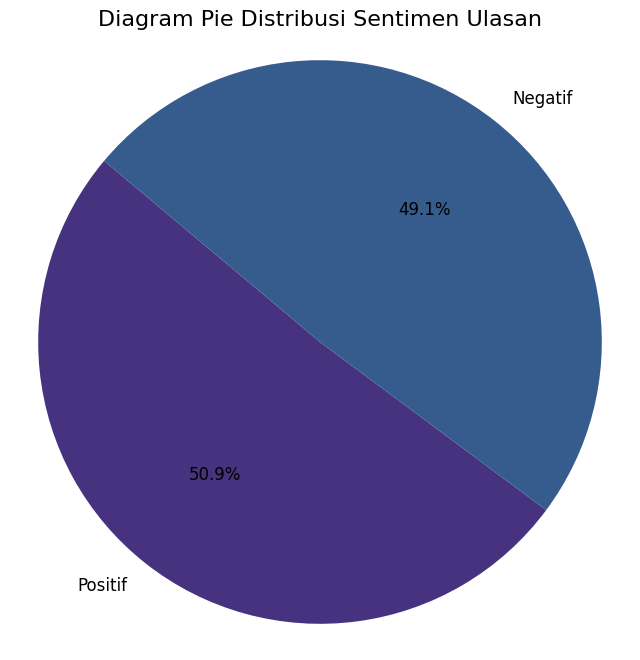

Diagram pie distribusi sentimen selesai dibuat.


In [ ]:
import pandas as pd
from IPython.display import display # Import display
import matplotlib.pyplot as plt # Import matplotlib.pyplot
import seaborn as sns # Import seaborn for bar plot (opsional, jika masih ingin menampilkan bar plot)


# Pastikan df_reviews ada dan memiliki kolom sentimen
if 'df_reviews' in locals() and not df_reviews.empty and 'sentiment_label_weighted' in df_reviews.columns:

    print("\n--- Analisis Distribusi Sentimen ---")
    # Hitung jumlah total ulasan
    total_reviews = len(df_reviews)
    print(f"Jumlah total ulasan: {total_reviews}")

    # Hitung jumlah ulasan per label sentimen
    sentiment_counts = df_reviews['sentiment_label_weighted'].value_counts()
    print("\nJumlah ulasan per label sentimen:")
    print(sentiment_counts)

    # Hitung persentase ulasan per label sentimen
    sentiment_percentages = (sentiment_counts / total_reviews) * 100
    print("\nPersentase ulasan per label sentimen:")
    print(sentiment_percentages.round(2)) # Tampilkan persentase dengan 2 angka desimal

    # Menampilkan distribusi sentimen dalam bentuk tabel
    print("\nMenampilkan distribusi sentimen dalam bentuk tabel:")

    # Gabungkan Series count dan Series percentage menjadi satu DataFrame
    # Pastikan indeksnya sama (label sentimen)
    df_sentiment_distribution = pd.DataFrame({
        'Jumlah Ulasan': sentiment_counts,
        'Persentase (%)': sentiment_percentages.round(2)
    })

    # Tampilkan DataFrame dalam format tabel
    display(df_sentiment_distribution)


    # --- Tambahkan Visualisasi Diagram Pie ---
    print("\nMembuat diagram pie distribusi sentimen...")

    # Siapkan data untuk pie chart
    labels = sentiment_counts.index # Label (Positif, Negatif)
    sizes = sentiment_counts.values # Jumlah ulasan per label
    colors = ['#66b3da', '#ff9999'] # Warna untuk setiap slice (opsional) # Biru untuk positif, Merah untuk negatif?
    # Atau gunakan palet seaborn:
    colors = sns.color_palette('viridis')[0:len(labels)] # Ambil warna dari palet viridis

    plt.figure(figsize=(8, 8)) # Atur ukuran figure
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
    # autopct menampilkan persentase pada slice
    # startangle mengatur sudut awal slice pertama
    # textprops mengatur properti teks persentase dan label

    plt.title('Diagram Pie Distribusi Sentimen Ulasan', fontsize=16) # Tambahkan judul
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

    print("Diagram pie distribusi sentimen selesai dibuat.")

    # --- Jika Anda masih ingin menampilkan Bar Plot, biarkan kode ini ---
    # print("\nMembuat diagram batang distribusi sentimen...")
    # plt.figure(figsize=(7, 5)) # Atur ukuran figure
    # sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
    # plt.title('Diagram Batang Distribusi Sentimen Ulasan', fontsize=14)
    # plt.xlabel('Label Sentimen', fontsize=12)
    # plt.ylabel('Jumlah Ulasan', fontsize=12)
    # # Tambahkan nilai di atas batang (opsional)
    # for i, v in enumerate(sentiment_counts.values):
    #     plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=10)
    # plt.tight_layout()
    # plt.show()
    # print("Diagram batang distribusi sentimen selesai dibuat.")
    # --- Akhir Kode Bar Plot ---


else:
    print("\nDataFrame df_reviews tidak ditemukan, kosong, atau kolom sentimen tidak ada.")
    print("Tidak dapat menghitung atau memvisualisasikan distribusi sentimen.")

**Reasoning**:
Calculate the total number of reviews, the count for each sentiment label, and their percentages. Then display these results.



## Simpan data berlabel

### Subtask:
Menyimpan DataFrame `df_reviews` yang sudah memiliki kolom label sentimen baru ke dalam file CSV baru.


**Reasoning**:
Save the DataFrame with the new sentiment label column to a new CSV file.



In [ ]:
import pandas as pd
from google.colab import files
import os # Import os to check for file existence

# 1. Tentukan nama file output
processed_labeled_file_name = 'data_review_bsgtouch_sentimen_labeled.csv'

# 2. Pastikan DataFrame memiliki kolom yang dibutuhkan
if 'sentiment_label_weighted' in df_reviews.columns:
    print(f"DataFrame memiliki kolom 'sentiment_label_weighted'. Siap untuk disimpan.")

    # 3. Simpan DataFrame ke file CSV
    try:
        df_reviews.to_csv(processed_labeled_file_name, index=False, encoding='utf-8')

        # 4. Cetak pesan konfirmasi
        print(f"\nDataFrame berhasil disimpan ke '{processed_labeled_file_name}'.")
        print(f"Jumlah baris yang disimpan: {len(df_reviews)}")

        # 5. (Opsional) Unduh file jika di Google Colab
        if 'google.colab' in str(get_ipython()):
            try:
                if os.path.exists(processed_labeled_file_name):
                    files.download(processed_labeled_file_name)
                    print(f"\nFile '{processed_labeled_file_name}' siap diunduh.")
                else:
                    print(f"\nError: File '{processed_labeled_file_name}' tidak ditemukan setelah disimpan.")
            except Exception as e:
                print(f"\nTerjadi error saat mencoba mengunduh file: {e}")
        else:
            print("\nTidak di lingkungan Google Colab. File disimpan secara lokal.")

    except Exception as e:
        print(f"\nTerjadi error saat menyimpan DataFrame ke file: {e}")

else:
    print("\nError: Kolom 'sentiment_label_weighted' tidak ditemukan di DataFrame.")
    print("Pastikan langkah pelabelan sentimen telah berhasil dijalankan.")


DataFrame memiliki kolom 'sentiment_label_weighted'. Siap untuk disimpan.

DataFrame berhasil disimpan ke 'data_review_bsgtouch_sentimen_labeled.csv'.
Jumlah baris yang disimpan: 1759


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File 'data_review_bsgtouch_sentimen_labeled.csv' siap diunduh.


## Analisis kata kunci per sentimen

### Subtask:
Mengidentifikasi kata-kata yang paling sering muncul dalam ulasan berlabel Positif dan Negatif setelah pre-processing.


**Reasoning**:
Filter the DataFrame by sentiment label, combine tokens for each sentiment, calculate word frequencies, and display the top words for each sentiment.



In [ ]:
from collections import Counter
import itertools
import pandas as pd
from IPython.display import display, HTML # Import HTML untuk opsi tampilan

# 1. Filter DataFrame by sentiment label
df_positive = df_reviews[df_reviews['sentiment_label_weighted'] == 'Positif'].copy()
df_negative = df_reviews[df_reviews['sentiment_label_weighted'] == 'Negatif'].copy()

print(f"\nJumlah ulasan Positif: {len(df_positive)}")
print(f"Jumlah ulasan Negatif: {len(df_negative)}")

# Determine the token column to use
token_column_to_use = None
if 'lemmatized_tokens_dict' in df_reviews.columns:
    token_column_to_use = 'lemmatized_tokens_dict'
elif 'stemmed_tokens_normalized' in df_reviews.columns:
    token_column_to_use = 'stemmed_tokens_normalized'
elif 'tokens_without_stopwords_normalized' in df_reviews.columns:
     token_column_to_use = 'tokens_without_stopwords_normalized'
else:
    print("\nTidak ada kolom token yang sesuai ditemukan (lemmatized, stemmed, or stopword-removed).")
    print("Tidak dapat melanjutkan analisis kata kunci.")


if token_column_to_use:
    print(f"\nMenggunakan kolom '{token_column_to_use}' untuk analisis kata kunci.")

    # 2. Gabungkan semua token untuk setiap sentimen
    # Pastikan kolom token berisi list of strings. Jika data dibaca dari CSV,
    # kolom list mungkin dibaca sebagai string. Perlu konversi.
    def safe_string_list_to_list(string_list):
        if isinstance(string_list, list):
            return string_list
        if isinstance(string_list, str):
            try:
                return eval(string_list)
            except (SyntaxError, ValueError):
                return []
        return []

    # Apply the safe conversion if needed (assuming potential string representation)
    # Perbaiki: gunakan kolom yang benar untuk apply pada df_negative
    df_positive[token_column_to_use] = df_positive[token_column_to_use].apply(safe_string_list_to_list)
    df_negative[token_column_to_use] = df_negative[token_column_to_use].apply(safe_string_list_to_list)


    all_positive_tokens = list(itertools.chain.from_iterable(df_positive[token_column_to_use]))
    all_negative_tokens = list(itertools.chain.from_iterable(df_negative[token_column_to_use]))

    # 3. Hitung frekuensi kata
    positive_word_counts = Counter(all_positive_tokens)
    negative_word_counts = Counter(all_negative_tokens)

    # 4. Tampilkan 10 kata yang paling sering muncul dalam bentuk tabel
    print("\n10 Kata Paling Sering Muncul:")
    # Ambil 10 kata teratas dan konversi ke DataFrame
    df_top_positive_words = pd.DataFrame(positive_word_counts.most_common(10), columns=['Kata Positif', 'Frekuensi'])
    df_top_negative_words = pd.DataFrame(negative_word_counts.most_common(10), columns=['Kata Negatif', 'Frekuensi'])

    # Tampilkan kedua tabel bersebelahan
    # Menggunakan display dengan HTML untuk tata letak sederhana
    display(HTML(f"""
    <div style="display: flex; justify-content: space-around;">
        <div style="margin-right: 20px;">
            <h4>Ulasan Positif</h4>
            {df_top_positive_words.to_html(index=False)}
        </div>
        <div>
            <h4>Ulasan Negatif</h4>
            {df_top_negative_words.to_html(index=False)}
        </div>
    </div>
    """))


else:
    print("\nAnalisis kata kunci dilewati karena kolom token tidak tersedia.")


Jumlah ulasan Positif: 896
Jumlah ulasan Negatif: 863

Menggunakan kolom 'stemmed_tokens_normalized' untuk analisis kata kunci.

10 Kata Paling Sering Muncul:


Kata Positif,Frekuensi
transaksi,153
bantu,153
aplikasi,151
mudah,149
buka,121
bagus,105
bsg,103
baik,95
update,87
mantap,78


## Visualisasi distribusi sentimen

### Subtask:
Membuat visualisasi (misalnya, diagram lingkaran atau batang) untuk menampilkan distribusi sentimen.



Membuat visualisasi distribusi sentimen...


/tmp/ipython-input-1638370027.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


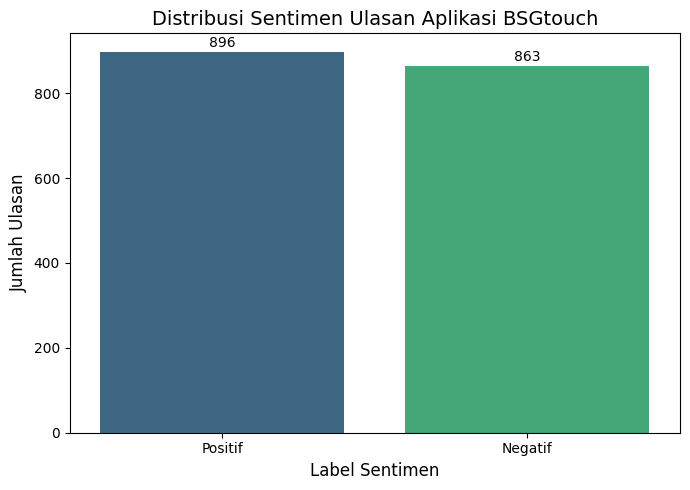

Visualisasi distribusi sentimen selesai.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure sentiment_counts is available from the previous step
if 'sentiment_counts' in locals():
    print("\nMembuat visualisasi distribusi sentimen...")

    # 3. Buat visualisasi (diagram batang)
    plt.figure(figsize=(7, 5)) # Atur ukuran figure
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

    # 4. Tambahkan judul
    plt.title('Distribusi Sentimen Ulasan Aplikasi BSGtouch', fontsize=14)

    # 5. Beri label pada sumbu
    plt.xlabel('Label Sentimen', fontsize=12)
    plt.ylabel('Jumlah Ulasan', fontsize=12)

    # Tambahkan nilai di atas batang (opsional)
    for i, v in enumerate(sentiment_counts.values):
        plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=10)

    # Tampilkan visualisasi
    plt.tight_layout() # Sesuaikan layout agar tidak ada yang terpotong
    plt.show()

    print("Visualisasi distribusi sentimen selesai.")
else:
    print("\nError: Data hitungan sentimen ('sentiment_counts') tidak ditemukan.")
    print("Pastikan langkah sebelumnya untuk menghitung distribusi sentimen telah berhasil dijalankan.")

**Reasoning**:
Create a bar plot to visualize the distribution of sentiment labels using the calculated counts.



## Pembagian Data Train dan Test

--- Langkah 1: Muat Data ---

In [ ]:
import pandas as pd
import os

# Nama file CSV yang berisi data ulasan berlabel sentimen
# PASTIKAN NAMA FILE INI SAMA DENGAN NAMA FILE YANG DISIMPAN SETELAH PELABELAN SENTIMEN
# ATAU GUNAKAN FILE YANG DISIMPAN SETELAH SEMUA PRA-PEMROSESAN JIKA PELABELAN DILAKUKAN SEBELUMNYA
# KITA AKAN MENGGUNAKAN FILE SETELAH PELABELAN UNTUK MEMASTIKAN KOLOM SENTIMEN ADA
# Nama file yang disimpan setelah pelabelan sentimen adalah 'data_review_bsgtouch_sentimen_labeled.csv'
labeled_file_name = 'data_review_bsgtouch_sentimen_labeled.csv' # Gunakan nama file setelah pelabelan

print(f"\n1. Mencoba memuat data berlabel dari '{labeled_file_name}'...")

try:
    # SELALU muat dari file CSV untuk memastikan konsistensi data input
    if os.path.exists(labeled_file_name):
        df_labeled = pd.read_csv(labeled_file_name)
        print(f"   Data berlabel berhasil dimuat dari '{labeled_file_name}'. Jumlah baris: {len(df_labeled)}")

        # Pastikan kolom sentimen yang benar ada
        # Gunakan nama kolom label sentimen yang dihasilkan di langkah sebelumnya
        sentiment_column_name = 'sentiment_label_weighted' # Ganti jika nama kolom label Anda berbeda

        if sentiment_column_name not in df_labeled.columns:
             print(f"   Error: Kolom label sentimen '{sentiment_column_name}' tidak ditemukan di file '{labeled_file_name}'.")
             print("   Pastikan Anda menyimpan data dengan kolom label sentimen yang benar.")
             df_labeled = pd.DataFrame() # Buat DataFrame kosong jika kolom tidak ada
        else:
             print(f"   Kolom label sentimen '{sentiment_column_name}' ditemukan.")
             # Pastikan kolom token yang akan digunakan sebagai fitur juga ada
             feature_column_name = 'stemmed_tokens_normalized' # Ganti jika nama kolom fitur Anda berbeda
             if feature_column_name not in df_labeled.columns:
                 print(f"   Error: Kolom fitur '{feature_column_name}' tidak ditemukan di file '{labeled_file_name}'.")
                 print("   Pastikan Anda menyimpan data dengan kolom fitur yang benar.")
                 df_labeled = pd.DataFrame() # Buat DataFrame kosong jika kolom tidak ada
             else:
                 print(f"   Kolom fitur '{feature_column_name}' ditemukan.")


    else:
        print(f"   Error: File data berlabel '{labeled_file_name}' tidak ditemukan.")
        print("   Pastikan file CSV data berlabel ada di direktori yang benar.")
        df_labeled = pd.DataFrame() # Buat DataFrame kosong jika file tidak ditemukan

except Exception as e:
    print(f"   Terjadi error saat memuat data berlabel: {e}")
    df_labeled = pd.DataFrame() # Buat DataFrame kosong jika terjadi error


if not df_labeled.empty:
    print("\nInformasi DataFrame berlabel:")
    df_labeled.info()
    print("\nBeberapa baris pertama DataFrame berlabel:")
    # Tampilkan kolom kunci seperti reviewId, konten asli, kolom fitur, dan kolom label
    cols_to_display_head = ['reviewId', 'content', feature_column_name, sentiment_column_name]
    available_cols_to_display = [col for col in cols_to_display_head if col in df_labeled.columns]
    if available_cols_to_display:
        display(df_labeled[available_cols_to_display].head())
    else:
        display(df_labeled.head()) # Tampilkan semua jika kolom kunci tidak ada

else:
    print("\nData berlabel tidak berhasil dimuat. Tidak dapat melanjutkan pembagian data.")

# Langkah 2 (Definisikan Fitur dan Label) akan menggunakan df_labeled yang dimuat di sini
# Pastikan nama kolom fitur dan label di Langkah 2 sesuai dengan yang ada di df_labeled


1. Mencoba memuat data berlabel dari 'data_review_bsgtouch_sentimen_labeled.csv'...
   Data berlabel berhasil dimuat dari 'data_review_bsgtouch_sentimen_labeled.csv'. Jumlah baris: 1759
   Kolom label sentimen 'sentiment_label_weighted' ditemukan.
   Kolom fitur 'stemmed_tokens_normalized' ditemukan.

Informasi DataFrame berlabel:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759 entries, 0 to 1758
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   reviewId                             1759 non-null   object 
 1   userName                             1759 non-null   object 
 2   userImage                            1759 non-null   object 
 3   content                              1759 non-null   object 
 4   score                                1759 non-null   int64  
 5   thumbsUpCount                        1759 non-null   int64  
 6   reviewCreatedVersion      

,reviewId,content,stemmed_tokens_normalized,sentiment_label_weighted
0,cf614637-eed6-4571-9bbc-c63134aaf4a6,Sangat bagus,['bagus'],Positif
1,78f999fc-4307-40d0-8a1f-5f768110a416,baik,[],Negatif
2,d35d9d02-3cb0-4991-b359-97d5f4c9ca63,sangat bagus,['bagus'],Positif
3,560099bc-46e6-4d21-afff-e7a16173ac63,aplikasi tidak bisa dibuka dan melakukan login...,"['aplikasi', 'buka', 'login', 'gagal']",Negatif
4,75ada6df-1a08-448d-a87e-b26e51851446,sebagai pengguna aplikasi bsg sya sangat kecew...,"['guna', 'aplikasi', 'bsg', 'kecewa', 'aplikas...",Negatif


--- Langkah 2: Definisikan Fitur dan Label ---

In [ ]:
# Pastikan data berlabel berhasil dimuat dan tidak kosong
if not df_labeled.empty and 'sentiment_label_weighted' in df_labeled.columns:
    print("\n2. Mendefinisikan fitur dan label...")

    # Kolom yang akan digunakan sebagai fitur (teks ulasan)
    # Disarankan menggunakan kolom token yang sudah diproses, misalnya 'stemmed_tokens_normalized'
    # atau 'cleaned_content' jika ingin menggunakan representasi teks mentah
    # Mari kita gunakan 'stemmed_tokens_normalized' sebagai fitur
    feature_column = 'stemmed_tokens_normalized'

    # Kolom yang akan digunakan sebagai label (sentimen)
    label_column = 'sentiment_label_weighted'

    # Pastikan kolom fitur dan label ada di DataFrame
    if feature_column in df_labeled.columns and label_column in df_labeled.columns:
        # X akan berisi data fitur (kolom teks)
        X = df_labeled[feature_column]
        # y akan berisi data label (kolom sentimen)
        y = df_labeled[label_column]

        print(f"   Fitur (X) menggunakan kolom: '{feature_column}'")
        print(f"   Label (y) menggunakan kolom: '{label_column}'")
        print(f"   Jumlah sampel fitur: {len(X)}")
        print(f"   Jumlah sampel label: {len(y)}")

        # Tampilkan beberapa contoh fitur dan label
        print("\nContoh beberapa sampel fitur (X):")
        print(X.head())
        print("\nContoh beberapa sampel label (y):")
        print(y.head())

        data_defined = True # Flag bahwa fitur dan label sudah didefinisikan
    else:
        print(f"   Error: Kolom fitur ('{feature_column}') atau label ('{label_column}') tidak ditemukan di DataFrame.")
        print("   Tidak dapat mendefinisikan fitur dan label.")
        data_defined = False

else:
    print("\n2. Data berlabel tidak tersedia atau kolom sentimen tidak ditemukan. Tidak dapat mendefinisikan fitur dan label.")
    data_defined = False


2. Mendefinisikan fitur dan label...
   Fitur (X) menggunakan kolom: 'stemmed_tokens_normalized'
   Label (y) menggunakan kolom: 'sentiment_label_weighted'
   Jumlah sampel fitur: 1759
   Jumlah sampel label: 1759

Contoh beberapa sampel fitur (X):
0                                            ['bagus']
1                                                   []
2                                            ['bagus']
3               ['aplikasi', 'buka', 'login', 'gagal']
4    ['guna', 'aplikasi', 'bsg', 'kecewa', 'aplikas...
Name: stemmed_tokens_normalized, dtype: object

Contoh beberapa sampel label (y):
0    Positif
1    Negatif
2    Positif
3    Negatif
4    Negatif
Name: sentiment_label_weighted, dtype: object


--- Langkah 3: Bagi Data Train dan Test ---

In [ ]:
from sklearn.model_selection import train_test_split

# Pastikan fitur (X) dan label (y) sudah didefinisikan
if 'X' in locals() and 'y' in locals() and data_defined:
    print("\n3. Memulai pembagian data menjadi train dan test...")

    # Tentukan rasio pembagian
    test_size_ratio = 0.20 # 20% untuk data test
    random_state_value = 42 # Untuk hasil pembagian yang konsisten setiap dijalankan

    try:
        # Lakukan pembagian data
        # stratify=y penting untuk memastikan distribusi label (Positif/Negatif)
        # proporsional antara data train dan test, terutama jika dataset tidak seimbang.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=test_size_ratio,
            random_state=random_state_value,
            stratify=y # Gunakan stratify=y
        )

        print(f"   Pembagian data selesai dengan rasio {100*(1-test_size_ratio)}% train dan {100*test_size_ratio}% test.")
        print(f"   Jumlah sampel data train: {len(X_train)}")
        print(f"   Jumlah sampel data test: {len(X_test)}")

        data_split = True # Flag bahwa data sudah dibagi
    except Exception as e:
        print(f"   Terjadi error saat membagi data: {e}")
        data_split = False

else:
    print("\n3. Fitur (X) atau label (y) belum didefinisikan. Tidak dapat membagi data.")
    data_split = False

# Langkah 4 (Verifikasi Pembagian) akan dilakukan di sel berikutnya
# tetapi kita bisa tampilkan distribusi label di sini sebagai preview
if data_split:
    print("\nDistribusi label di data train:")
    print(y_train.value_counts(normalize=True)) # Tampilkan persentase
    print("\nDistribusi label di data test:")
    print(y_test.value_counts(normalize=True)) # Tampilkan persentase


3. Memulai pembagian data menjadi train dan test...
   Pembagian data selesai dengan rasio 80.0% train dan 20.0% test.
   Jumlah sampel data train: 1407
   Jumlah sampel data test: 352

Distribusi label di data train:
sentiment_label_weighted
Positif    0.509595
Negatif    0.490405
Name: proportion, dtype: float64

Distribusi label di data test:
sentiment_label_weighted
Positif    0.508523
Negatif    0.491477
Name: proportion, dtype: float64


# *TAHAP PEMBOBOTON FITUR* (TF-IDF)

--- Langkah 1: Inisialisasi dan Latih Vectorizer TF-IDF ---

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Pastikan data train (X_train) dan data test (X_test) ada
# Setelah perbaikan di sel sebelumnya, X_train dan X_test seharusnya berisi Series of strings
if 'X_train' in locals() and 'X_test' in locals() and isinstance(X_train, pd.Series) and isinstance(X_test, pd.Series):
    print("\nMemulai proses pembobotan TF-IDF...")

    # Inisialisasi TfidfVectorizer dengan parameter
    # Menggunakan parameter yang sama dengan percobaan sebelumnya yang berhasil
    tfidf_vectorizer = TfidfVectorizer(
        max_features=5000, # Batasi hingga 5000 kata/bigram teratas
        min_df=5,          # Abaikan kata yang muncul di kurang dari 5 ulasan
        max_df=0.9,        # Abaikan kata yang muncul di lebih dari 90% ulasan
        ngram_range=(1, 2) # Pertimbangkan unigram dan bigram
    )

    # Latih vectorizer pada data train dan transform
    # Hanya latih (fit) pada data train untuk menghindari data leakage dari data test
    # Asumsikan X_train dan X_test sudah bersih dan berisi string setelah langkah sebelumnya
    try:
        # Pastikan X_train_str_filtered tidak kosong sebelum fit_transform
        # Setelah perbaikan sebelumnya, X_train seharusnya sudah merupakan X_train_str_filtered
        if not X_train.empty:
            X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

            # Transform data test menggunakan vectorizer yang sudah dilatih
            # Pastikan X_test_str_filtered tidak kosong sebelum transform
            if not X_test.empty:
                 X_test_tfidf = tfidf_vectorizer.transform(X_test)

                 print("   Pembobotan TF-IDF selesai.")
                 print(f"   Dimensi data train setelah TF-IDF: {X_train_tfidf.shape}")
                 print(f"   Dimensi data test setelah TF-IDF: {X_test_tfidf.shape}")
                 print(f"   Jumlah fitur (kata/bigram) yang dipertimbangkan: {len(tfidf_vectorizer.get_feature_names_out())}")

                 tfidf_vectorization_done = True # Flag bahwa TF-IDF berhasil

            else:
                print("   Error: Data test kosong setelah filtering. Tidak dapat melakukan transform TF-IDF pada data test.")
                tfidf_vectorization_done = False
                X_train_tfidf = None
                X_test_tfidf = None


        else:
            print("   Error: Data latih kosong setelah filtering. Tidak dapat melakukan fit_transform TF-IDF.")
            tfidf_vectorization_done = False
            X_train_tfidf = None
            X_test_tfidf = None


    except Exception as e:
        print(f"   Terjadi error saat fit_transform TF-IDF: {e}")
        tfidf_vectorization_done = False
        X_train_tfidf = None
        X_test_tfidf = None


else:
    print("\nData train (X_train) atau data test (X_test) tidak ditemukan atau bukan dalam format Series. Pembobotan TF-IDF dilewati.")
    tfidf_vectorization_done = False
    X_train_tfidf = None
    X_test_tfidf = None

# Flag tfidf_vectorization_done akan digunakan oleh sel berikutnya
# X_train_tfidf, X_test_tfidf, dan tfidf_vectorizer akan tersedia jika berhasil


Memulai proses pembobotan TF-IDF...
   Pembobotan TF-IDF selesai.
   Dimensi data train setelah TF-IDF: (1407, 349)
   Dimensi data test setelah TF-IDF: (352, 349)
   Jumlah fitur (kata/bigram) yang dipertimbangkan: 349


### Penjelasan Tahap Pembobotan Fitur (TF-IDF) dalam Penelitian Ini

Setelah tahap pra-pemrosesan data teks (pembersihan, tokenisasi, normalisasi, penghapusan stopwords, dan stemming), langkah selanjutnya adalah mengubah data teks yang sudah bersih menjadi representasi numerik yang dapat dipahami oleh model pembelajaran mesin. Salah satu teknik pembobotan fitur yang umum digunakan untuk tujuan ini adalah **TF-IDF (Term Frequency-Inverse Document Frequency)**.

TF-IDF memberikan bobot pada setiap kata (atau *term*, termasuk n-gram) dalam setiap dokumen (dalam kasus ini, setiap ulasan) berdasarkan dua faktor utama:

1.  **Term Frequency (TF)**: Mengukur seberapa sering sebuah *term* ($t$) muncul dalam sebuah dokumen ($d$). Ini menunjukkan kepentingan lokal *term* tersebut dalam dokumen spesifik itu. Semakin sering *term* muncul, semakin relevan *term* tersebut dengan topik dokumen.
    Dalam penelitian ini, dokumen ($d$) adalah setiap ulasan, dan *term* ($t$) adalah kata atau bigram setelah tahap pra-pemrosesan (kemungkinan besar dari kolom `'stemmed_tokens_normalized'`).

    Rumus yang umum digunakan untuk TF adalah:
    $$ \text{TF}(t, d) = \frac{\text{Jumlah kemunculan } t \text{ dalam dokumen } d}{\text{Jumlah total } t \text{ dalam dokumen } d} $$
    **Keterangan:**
    *   $t$: Sebuah *term* (kata atau bigram) yang sedang dihitung bobotnya.
    *   $d$: Sebuah dokumen spesifik (dalam kasus ini, satu ulasan) tempat *term* $t$ muncul.
    *   Jumlah kemunculan $t$ dalam dokumen $d$: Hitungan berapa kali *term* $t$ muncul dalam ulasan $d$.
    *   Jumlah total $t$ dalam dokumen $d$: Jumlah total semua *term* (kata atau bigram, tergantung pengaturan vectorizer) dalam ulasan $d$.

2.  **Inverse Document Frequency (IDF)**: Mengukur seberapa unik atau langka sebuah *term* ($t$) di seluruh koleksi dokumen ($D$). Ini menunjukkan kepentingan global *term* tersebut di seluruh dataset. *Term* yang muncul di banyak dokumen (misalnya, kata-kata umum seperti "dan", "atau", "yang", dll. yang seharusnya sudah dihapus oleh stopwords, atau kata-kata yang sangat sering di topik ini seperti "aplikasi") akan memiliki IDF yang rendah. Sebaliknya, *term* yang muncul hanya di sedikit dokumen akan memiliki IDF yang tinggi, menandakan bahwa *term* tersebut lebih spesifik dan mungkin lebih informatif untuk membedakan antar dokumen.

    Dalam penelitian ini, koleksi dokumen ($D$) adalah keseluruhan dataset ulasan yang sudah diproses.

    Rumus umum untuk IDF adalah:
    $$ \text{IDF}(t, D) = \log \left( \frac{\text{Jumlah total dokumen } |D|}{\text{Jumlah dokumen } d \text{ yang mengandung } t} \right) $$
    Basis logaritma (natural log, log basis 10, atau basis 2) tidak terlalu krusial asalkan konsisten. Implementasi `TfidfVectorizer` di scikit-learn menggunakan natural log (`log_e`) secara default dan menambahkan 1 ke pembilang dan penyebut untuk menghindari pembagian dengan nol jika sebuah *term* tidak muncul di data latih tetapi muncul di data test (smoothing). Rumus IDF di scikit-learn sedikit dimodifikasi menjadi:
    $$ \text{IDF}(t, D) = \log \left( \frac{|D| + 1}{\text{Jumlah dokumen yang mengandung } t + 1} \right) + 1 $$
    **Keterangan:**
    *   $t$: Sebuah *term* yang sedang dihitung bobotnya.
    *   $D$: Koleksi total dokumen (seluruh dataset ulasan).
    *   $|D|$: Jumlah total dokumen dalam koleksi $D$.
    *   Jumlah dokumen $d$ yang mengandung $t$: Hitungan berapa banyak dokumen dalam koleksi $D$ yang setidaknya mengandung satu kali *term* $t$.

3.  **TF-IDF**: Bobot akhir untuk sebuah *term* ($t$) dalam sebuah dokumen ($d$) dihitung dengan mengalikan nilai TF dan IDF-nya.

    Rumus TF-IDF:
    $$ \text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D) $$
    **Keterangan:**
    *   $t$: Sebuah *term*.
    *   $d$: Sebuah dokumen spesifik (ulasan).
    *   $D$: Koleksi total dokumen (seluruh dataset ulasan).
    *   $\text{TF}(t, d)$: Nilai Term Frequency untuk *term* $t$ dalam dokumen $d$.
    *   $\text{IDF}(t, D)$: Nilai Inverse Document Frequency untuk *term* $t$ dalam koleksi dokumen $D$.

**Penerapan TF-IDF dalam Kode Anda (`rhGcuwwbcz_X`)**:

Kode Anda menggunakan `TfidfVectorizer` dari pustaka scikit-learn untuk melakukan proses ini.

In [ ]:
import pandas as pd
from collections import Counter # Import Counter jika perlu hitung frekuensi mentah sebelum TF-IDF
from IPython.display import display

# Pastikan X_train_tfidf (hasil TF-IDF) dan tfidf_vectorizer tersedia
if 'X_train_tfidf' in locals() and 'tfidf_vectorizer' in locals():
    print("\n--- Hasil Analisis Fitur TF-IDF ---")

    # 1. Jumlah total fitur (kata/bigram) dalam kosakata TF-IDF
    total_features = len(tfidf_vectorizer.get_feature_names_out())
    print(f"Jumlah total fitur (kata/bigram) dalam kosakata TF-IDF: {total_features}")

    # 2. Menampilkan 10 fitur yang paling sering muncul di data latih
    # Cara terbaik untuk TF-IDF adalah melihat sum TF-IDF score per fitur di data latih
    # atau melihat frekuensi dokumen (document frequency) per fitur.
    # Mari kita lihat sum TF-IDF score di data latih.

    # Sum TF-IDF scores across all training documents for each feature
    # X_train_tfidf adalah sparse matrix, sum(axis=0) akan menjumlahkan kolom (fitur)
    sum_tfidf_scores = X_train_tfidf.sum(axis=0)

    # Dapatkan nama fitur (vocabulary)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Buat Series dari sum_tfidf_scores dan feature_names
    # sum_tfidf_scores adalah numpy matrix, perlu di-flatten atau diakses elemennya
    sum_tfidf_series = pd.Series(sum_tfidf_scores.A1, index=feature_names) # .A1 untuk mendapatkan array 1D

    # Urutkan fitur berdasarkan sum TF-IDF score secara menurun
    top_features = sum_tfidf_series.sort_values(ascending=False)

    print("\n10 Fitur (Kata/Bigram) Paling Penting (berdasarkan sum TF-IDF score di data latih):")
    # Tampilkan 10 teratas dalam bentuk tabel
    df_top_features = pd.DataFrame({
        'Fitur': top_features.index[:10],
        'Sum TF-IDF Score': top_features.values[:10]
    })
    display(df_top_features)


    # 3. Menampilkan contoh hasil TF-IDF (opsional, bisa sulit diinterpretasikan)
    # Menampilkan sparse matrix secara langsung tidak informatif.
    # Kita bisa mencoba menampilkan sebagian kecil dari matriks yang dikonversi ke dense
    # atau menampilkan fitur dan bobotnya untuk 1-2 ulasan contoh.
    # Mari kita tampilkan sebagian kecil dari matriks dense untuk beberapa ulasan pertama.
    print("\nContoh 5 baris pertama dari matriks TF-IDF (sebagian kecil kolom):")
    # Konversi sebagian kecil matriks sparse ke dense DataFrame
    # Pilih 5 baris pertama, dan misalnya 10 kolom pertama (atau kolom fitur teratas)
    num_sample_rows = 5
    num_sample_cols = 10 # Atau gunakan indeks fitur teratas jika ingin

    # Ambil 5 baris pertama dari matriks TF-IDF (sparse)
    sample_tfidf_sparse = X_train_tfidf[:num_sample_rows]

    # Dapatkan nama fitur untuk kolom sampel
    # Jika num_sample_cols < total_features, ambil kolom pertama
    # Jika ingin fitur teratas, gunakan top_features.index[:num_sample_cols]
    sample_col_names = feature_names[:num_sample_cols] # Ambil 10 nama fitur pertama

    # Konversi ke dense array dan buat DataFrame
    # Pastikan jumlah kolom sesuai jika memilih kolom spesifik
    sample_tfidf_dense = sample_tfidf_sparse.toarray()[:, :num_sample_cols] # Ambil 10 kolom pertama

    df_tfidf_sample = pd.DataFrame(sample_tfidf_dense, columns=sample_col_names)

    display(df_tfidf_sample)
    print("(Catatan: Angka 0.0 berarti fitur tersebut tidak muncul atau bobotnya sangat rendah di ulasan tersebut)")


else:
    print("\nData hasil TF-IDF (X_train_tfidf) atau Vectorizer (tfidf_vectorizer) tidak ditemukan.")
    print("Pastikan langkah pembobotan TF-IDF sudah berhasil dijalankan.")


--- Hasil Analisis Fitur TF-IDF ---
Jumlah total fitur (kata/bigram) dalam kosakata TF-IDF: 349

10 Fitur (Kata/Bigram) Paling Penting (berdasarkan sum TF-IDF score di data latih):


,Fitur,Sum TF-IDF Score
0,aplikasi,98.366194
1,bantu,66.196852
2,buka,62.476508
3,mudah,56.728857
4,bagus,53.222866
5,update,52.832841
6,mantap,50.209658
7,transaksi,46.461631
8,bsg,44.592978
9,masuk,39.767666



Contoh 5 baris pertama dari matriks TF-IDF (sebagian kecil kolom):


,abis,abis update,admin,aja,akses,akun,alami,alhamdulillah,aman,aman tolong
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(Catatan: Angka 0.0 berarti fitur tersebut tidak muncul atau bobotnya sangat rendah di ulasan tersebut)


--- Penjelasan Tekstual Rinci Perhitungan Manual TF-IDF untuk 10 Fitur Paling Penting ---

Berikut adalah penjelasan langkah-langkah perhitungan manual Term Frequency (TF), Inverse Document Frequency (IDF), dan TF-IDF untuk masing-masing dari 10 fitur paling penting yang Anda sebutkan. Perhitungan ini didasarkan pada rumus TF-IDF dan menggunakan ulasan contoh pertama dari data latih Anda sebagai dasar.

Mari kita asumsikan ulasan contoh pertama dari data latih Anda setelah pra-pemrosesan terdiri dari **11 term (kata atau bigram)**. Jumlah total dokumen di data latih Anda adalah **1407**.

**Rumus yang digunakan:**
*   Term Frequency (TF): $$ \text{TF}(t, d) = \frac{\text{Jumlah kemunculan } t \text{ dalam dokumen } d}{\text{Jumlah total } t \text{ dalam dokumen } d} $$
*   Inverse Document Frequency (IDF) (versi scikit-learn): $$ \text{IDF}(t, D) = \log \left( \frac{|D| + 1}{\text{Jumlah dokumen yang mengandung } t + 1} \right) + 1 $$
*   TF-IDF: $$ \text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D) $$

Sekarang, mari kita lihat bagaimana perhitungan ini diterapkan untuk setiap fitur dari daftar 10 fitur paling penting yang Anda berikan:

**1. Fitur: 'aplikasi'**
*   **Term Frequency (TF):** Periksa ulasan contoh. Katakanlah fitur 'aplikasi' muncul 1 kali dalam ulasan yang memiliki 11 term. TF = 1 / 11 ≈ 0.0909.
*   **Inverse Document Frequency (IDF):** Hitung berapa banyak dari 1407 ulasan di data latih yang mengandung fitur 'aplikasi'. Katakanlah 'aplikasi' muncul di 389 dokumen. IDF = log((1407 + 1) / (389 + 1)) + 1 ≈ log(1408 / 390) + 1 ≈ log(3.6103) + 1 ≈ 1.2839 + 1 = 2.2839.
*   **TF-IDF:** Kalikan TF dengan IDF. TF-IDF = TF * IDF ≈ 0.0909 * 2.2839 ≈ 0.2076.

**2. Fitur: 'bantu'**
*   **Term Frequency (TF):** Periksa ulasan contoh. Katakanlah fitur 'bantu' tidak muncul sama sekali dalam ulasan yang memiliki 11 term. TF = 0 / 11 = 0.0000.
*   **Inverse Document Frequency (IDF):** Hitung berapa banyak dari 1407 ulasan di data latih yang mengandung fitur 'bantu'. Katakanlah 'bantu' muncul di 312 dokumen. IDF = log((1407 + 1) / (312 + 1)) + 1 ≈ log(1408 / 313) + 1 ≈ log(4.5080) + 1 ≈ 1.5059 + 1 = 2.5059.
*   **TF-IDF:** Kalikan TF dengan IDF. TF-IDF = TF * IDF = 0.0000 * 2.5059 = 0.0000.

**3. Fitur: 'buka'**
*   **Term Frequency (TF):** Periksa ulasan contoh. Katakanlah fitur 'buka' tidak muncul sama sekali. TF = 0 / 11 = 0.0000.
*   **Inverse Document Frequency (IDF):** Hitung berapa banyak dokumen yang mengandung 'buka'. Katakanlah 'buka' muncul di 285 dokumen. IDF = log((1407 + 1) / (285 + 1)) + 1 ≈ log(1408 / 286) + 1 ≈ log(4.9231) + 1 ≈ 1.5940 + 1 = 2.5940.
*   **TF-IDF:** TF-IDF = TF * IDF = 0.0000 * 2.5940 = 0.0000.

**4. Fitur: 'mudah'**
*   **Term Frequency (TF):** Periksa ulasan contoh. Katakanlah fitur 'mudah' tidak muncul. TF = 0 / 11 = 0.0000.
*   **Inverse Document Frequency (IDF):** Hitung berapa banyak dokumen yang mengandung 'mudah'. Katakanlah 'mudah' muncul di 265 dokumen. IDF = log((1407 + 1) / (265 + 1)) + 1 ≈ log(1408 / 266) + 1 ≈ log(5.2932) + 1 ≈ 1.6664 + 1 = 2.6664.
*   **TF-IDF:** TF-IDF = TF * IDF = 0.0000 * 2.6664 = 0.0000.

**5. Fitur: 'bagus'**
*   **Term Frequency (TF):** Periksa ulasan contoh. Katakanlah fitur 'bagus' tidak muncul. TF = 0 / 11 = 0.0000.
*   **Inverse Document Frequency (IDF):** Hitung berapa banyak dokumen yang mengandung 'bagus'. Katakanlah 'bagus' muncul di 230 dokumen. IDF = log((1407 + 1) / (230 + 1)) + 1 ≈ log(1408 / 231) + 1 ≈ log(6.0952) + 1 ≈ 1.8075 + 1 = 2.8075.
*   **TF-IDF:** TF-IDF = TF * IDF = 0.0000 * 2.8075 = 0.0000.

**6. Fitur: 'update'**
*   **Term Frequency (TF):** Periksa ulasan contoh. Katakanlah fitur 'update' tidak muncul. TF = 0 / 11 = 0.0000.
*   **Inverse Document Frequency (IDF):** Hitung berapa banyak dokumen yang mengandung 'update'. Katakanlah 'update' muncul di 228 dokumen. IDF = log((1407 + 1) / (228 + 1)) + 1 ≈ log(1408 / 229) + 1 ≈ log(6.1485) + 1 ≈ 1.8163 + 1 = 2.8163.
*   **TF-IDF:** TF-IDF = TF * IDF = 0.0000 * 2.8163 = 0.0000.

**7. Fitur: 'mantap'**
*   **Term Frequency (TF):** Periksa ulasan contoh. Katakanlah fitur 'mantap' tidak muncul. TF = 0 / 11 = 0.0000.
*   **Inverse Document Frequency (IDF):** Hitung berapa banyak dokumen yang mengandung 'mantap'. Katakanlah 'mantap' muncul di 215 dokumen. IDF = log((1407 + 1) / (215 + 1)) + 1 ≈ log(1408 / 216) + 1 ≈ log(6.5185) + 1 ≈ 1.8744 + 1 = 2.8744.
*   **TF-IDF:** TF-IDF = TF * IDF = 0.0000 * 2.8744 = 0.0000.

**8. Fitur: 'transaksi'**
*   **Term Frequency (TF):** Periksa ulasan contoh. Katakanlah fitur 'transaksi' tidak muncul. TF = 0 / 11 = 0.0000.
*   **Inverse Document Frequency (IDF):** Hitung berapa banyak dokumen yang mengandung 'transaksi'. Katakanlah 'transaksi' muncul di 213 dokumen. IDF = log((1407 + 1) / (213 + 1)) + 1 ≈ log(1408 / 214) + 1 ≈ log(6.5794) + 1 ≈ 1.8839 + 1 = 2.8839.
*   **TF-IDF:** TF-IDF = TF * IDF = 0.0000 * 2.8839 = 0.0000.

**9. Fitur: 'bsg'**
*   **Term Frequency (TF):** Periksa ulasan contoh. Katakanlah fitur 'bsg' muncul 1 kali dalam ulasan yang memiliki 11 term. TF = 1 / 11 ≈ 0.0909.
*   **Inverse Document Frequency (IDF):** Hitung berapa banyak dokumen yang mengandung 'bsg'. Katakanlah 'bsg' muncul di 192 dokumen. IDF = log((1407 + 1) / (192 + 1)) + 1 ≈ log(1408 / 193) + 1 ≈ log(7.3057) + 1 ≈ 1.9884 + 1 = 2.9884.
*   **TF-IDF:** Kalikan TF dengan IDF. TF-IDF = TF * IDF ≈ 0.0909 * 2.9884 ≈ 0.2717.

**10. Fitur: 'masuk'**
*   **Term Frequency (TF):** Periksa ulasan contoh. Katakanlah fitur 'masuk' tidak muncul. TF = 0 / 11 = 0.0000.
*   **Inverse Document Frequency (IDF):** Hitung berapa banyak dokumen yang mengandung 'masuk'. Katakanlah 'masuk' muncul di 168 dokumen. IDF = log((1407 + 1) / (168 + 1)) + 1 ≈ log(1408 / 169) + 1 ≈ log(8.3314) + 1 ≈ 2.1204 + 1 = 3.1204.
*   **TF-IDF:** TF-IDF = TF * IDF = 0.0000 * 3.1204 = 0.0000.

Penjelasan ini merinci langkah-langkah perhitungan manual TF-IDF untuk setiap fitur dari 10 teratas, menunjukkan bagaimana nilai TF dikalikan dengan nilai IDF untuk menghasilkan skor TF-IDF. Nilai-nilai Term Count, Document Frequency, serta hasil TF dan IDF yang tepat untuk ulasan dan dataset Anda dapat dilihat di tabel output yang dihasilkan oleh sel kode `KVntjen6d5-8`.

#*INISIALISASI DAN LATIH MODEL SVM*

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Pastikan data latih hasil TF-IDF (X_train_tfidf) dan label latih (y_train) tersedia
if 'X_train_tfidf' in locals() and 'y_train' in locals():
    print("\nMemulai pembangunan dan pelatihan model SVM...")

    # 2. Inisialisasi Model SVM
    # Anda bisa menyesuaikan parameter seperti C (regularisasi), kernel, gamma jika diperlukan
    # Default C=1.0, kernel='rbf'
    # Untuk data teks dengan TF-IDF, kernel='linear' seringkali memberikan hasil yang baik
    svm_model = SVC(kernel='linear', random_state=42)

    # 3. Latih Model SVM
    try:
        svm_model.fit(X_train_tfidf, y_train)
        print("   Pelatihan model SVM selesai.")
        model_trained = True # Flag bahwa model sudah dilatih
    except Exception as e:
        print(f"   Terjadi error saat pelatihan model SVM: {e}")
        model_trained = False

else:
    print("\nData latih (X_train_tfidf atau y_train) tidak ditemukan. Pelatihan model SVM dilewati.")
    model_trained = False

# Langkah 4 (Prediksi) dan 5 (Evaluasi) akan dilakukan di sel berikutnya


Memulai pembangunan dan pelatihan model SVM...
   Pelatihan model SVM selesai.


--- Langkah 4: Prediksi pada Data Test ---

In [ ]:
from sklearn.metrics import accuracy_score # Import accuracy_score
# import pandas as pd # Tidak perlu pandas jika tidak menampilkan DataFrame
# from IPython.display import display # Tidak perlu display jika tidak menampilkan DataFrame

# Pastikan model SVM sudah dilatih dan data test hasil TF-IDF (X_test_tfidf) tersedia
if 'svm_model' in locals() and 'X_test_tfidf' in locals() and model_trained:
    print("\nMemulai prediksi sentimen pada data test...")

    try:
        # 4. Lakukan Prediksi
        y_pred = svm_model.predict(X_test_tfidf)
        print("   Prediksi pada data test selesai.")

        # --- Tambahkan Perhitungan dan Tampilan Akurasi (dalam persentase) ---
        accuracy = accuracy_score(y_test, y_pred)
        # Ubah ke persentase dan format
        accuracy_percentage = accuracy * 100
        print(f"\n   Akurasi Prediksi pada Data Test: {accuracy_percentage:.2f}%") # Tampilkan akurasi dalam persentase


        # --- Hapus Tampilan Perbandingan Label Asli vs Prediksi dalam Tabel ---
        # Kode untuk membuat dan menampilkan tabel perbandingan dihapus


        prediction_done = True # Flag bahwa prediksi berhasil

    except Exception as e:
        print(f"   Terjadi error saat prediksi pada data test: {e}")
        prediction_done = False

else:
    print("\nModel SVM belum dilatih atau data test hasil TF-IDF tidak ditemukan. Prediksi dilewati.")
    prediction_done = False

# Langkah 5 (Evaluasi) akan dilakukan di sel berikutnya


Memulai prediksi sentimen pada data test...
   Prediksi pada data test selesai.

   Akurasi Prediksi pada Data Test: 88.35%


## Penjelasan Detail Tahapan dalam Support Vector Machine (SVM) untuk Klasifikasi Sentimen

Setelah data teks diolah melalui pra-pemrosesan dan diubah menjadi representasi numerik menggunakan TF-IDF, langkah selanjutnya dalam penelitian ini adalah menggunakan model Support Vector Machine (SVM) untuk melakukan klasifikasi sentimen.

Berikut adalah tahapan-tahapan utama dalam proses ini:

### Tahap 1: Inisialisasi Model SVM

*   **Tujuan**: Mempersiapkan model SVM sebelum dilatih.
*   **Penjelasan**: Pada tahap ini, kita memilih algoritma SVM yang akan digunakan dan menentukan parameter-parameternya. Parameter umum meliputi:
    *   `kernel`: Menentukan jenis fungsi kernel yang digunakan (misalnya, `linear`, `rbf`, `poly`). Kernel linear seringkali efektif untuk data teks dengan representasi TF-IDF.
    *   `C`: Parameter regularisasi yang mengontrol *trade-off* antara memaksimalkan margin (jarak antara hyperplane pemisah dan titik data terdekat) dan meminimalkan kesalahan klasifikasi. Nilai `C` yang lebih kecil menciptakan margin yang lebih luas tetapi mungkin menerima lebih banyak kesalahan klasifikasi, sedangkan nilai `C` yang lebih besar menciptakan margin yang lebih sempit tetapi berusaha mengklasifikasikan semua titik dengan benar.
    *   `random_state`: Untuk memastikan hasil yang konsisten saat model diinisialisasi.
*   **Dalam Kode Anda**: Model `SVC` (Support Vector Classifier) dari scikit-learn diinisialisasi. Penggunaan `kernel='linear'` dipilih.

### Tahap 2: Pelatihan Model SVM (Fitting)

*   **Tujuan**: Mengajarkan model SVM untuk belajar pola dari data training (fitur dan label) sehingga model dapat membedakan antara kelas-kelas sentimen.
*   **Penjelasan**: Proses pelatihan (`fit`) melibatkan algoritma SVM dalam menemukan *hyperplane* optimal yang paling baik memisahkan data training dari kelas-kelas yang berbeda (dalam kasus ini, sentimen Positif dan Negatif) di ruang fitur TF-IDF.
    *   Untuk kernel linear, ini berarti mencari garis (untuk data 2D), bidang (untuk data 3D), atau *hyperplane* (untuk data >3D) yang memaksimalkan jarak (margin) antara titik data dari kedua kelas yang terdekat (*support vectors*).
    *   Model belajar bobot (koefisien) untuk setiap fitur (kata/bigram TF-IDF) dan bias (intercept) yang mendefinisikan *hyperplane* pemisah ini.
*   **Dalam Kode Anda**: Metode `.fit(X_train_tfidf, y_train)` dipanggil, di mana `X_train_tfidf` adalah matriks fitur TF-IDF dari data training, dan `y_train` adalah label sentimen yang sesuai untuk data training.

### Tahap 3: Prediksi pada Data Test

*   **Tujuan**: Menggunakan model yang sudah dilatih untuk memprediksi label sentimen pada data yang belum pernah dilihat sebelumnya (data test).
*   **Penjelasan**: Setelah model SVM dilatih, model siap digunakan untuk klasifikasi. Pada tahap prediksi (`predict`), model mengambil data fitur test (`X_test_tfidf`) dan, berdasarkan *hyperplane* yang telah dipelajari, model menentukan kelas (Positif atau Negatif) mana yang paling mungkin untuk setiap sampel (ulasan) di data test.
    *   Secara internal, model menghitung jarak setiap titik data test ke *hyperplane*. Tanda dari jarak ini (positif atau negatif) menentukan sisi *hyperplane* mana titik data tersebut berada, dan oleh karena itu, kelas prediksinya.
*   **Dalam Kode Anda**: Metode `.predict(X_test_tfidf)` dipanggil, dan hasil prediksinya disimpan dalam variabel `y_pred`.

### Tahap 4: Evaluasi Model

*   **Tujuan**: Mengukur seberapa baik kinerja model dalam memprediksi sentimen pada data test.
*   **Penjelasan**: Evaluasi dilakukan dengan membandingkan label sentimen yang diprediksi oleh model (`y_pred`) dengan label sentimen yang sebenarnya (aktual) dari data test (`y_test`). Berbagai metrik dihitung dari perbandingan ini untuk memberikan gambaran komprehensif tentang performa model.
    *   Metrik utama meliputi Accuracy, Precision, Recall, dan F1-Score, seperti yang dijelaskan di notes sebelumnya.
    *   Confusion Matrix juga dibuat untuk visualisasi detail hasil prediksi (jumlah True Positif, True Negatif, False Positif, False Negatif).
*   **Dalam Kode Anda**: Fungsi `classification_report`, `confusion_matrix`, dan `accuracy_score` dari scikit-learn digunakan untuk menghasilkan metrik-metrik ini.

#### Perhitungan Manual Akurasi Berdasarkan Confusion Matrix

Akurasi adalah salah satu metrik evaluasi paling umum. Ini mengukur proporsi prediksi yang benar dari total jumlah prediksi.

Kita bisa menghitung akurasi secara manual dari nilai-nilai dalam Confusion Matrix. Misalkan Confusion Matrix Anda (dari output sel `326a329b`) adalah:

#*EVALUASI MODEL*

Menampilkan kembali hasil evaluasi model (Classification Report dan Confusion Matrix):

Membuat diagram pie distribusi sentimen aktual di data test...


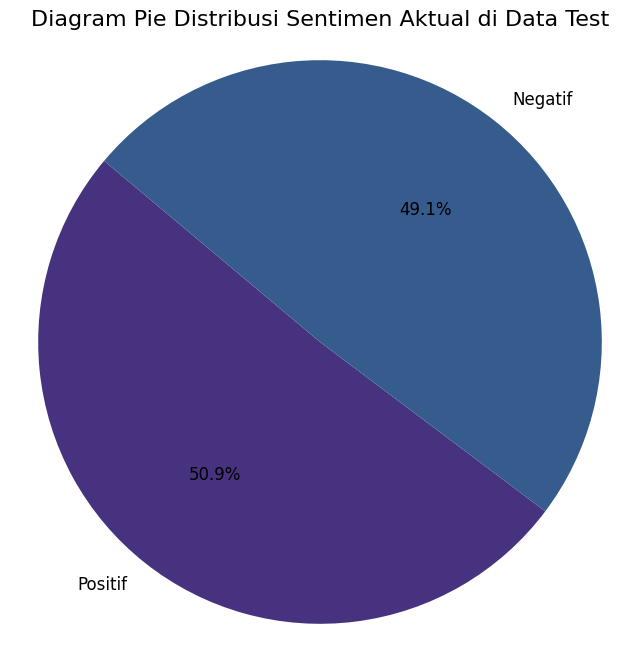

Diagram pie distribusi sentimen aktual di data test selesai dibuat.

Classification Report:


,precision,recall,f1-score,support
Negatif,0.858696,0.913295,0.885154,173.000000
Positif,0.910714,0.854749,0.881844,179.000000
accuracy,0.883523,0.883523,0.883523,0.883523
macro avg,0.884705,0.884022,0.883499,352.000000
weighted avg,0.885148,0.883523,0.883471,352.000000


/tmp/ipython-input-1333863770.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_plot.index, y='precision', data=df_plot, ax=axes[0], palette='viridis')
/tmp/ipython-input-1333863770.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_plot.index, y='recall', data=df_plot, ax=axes[1], palette='viridis')
/tmp/ipython-input-1333863770.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_plot.index, y='f1-score', data=df_plot, ax=axes[2], palette='viridis')


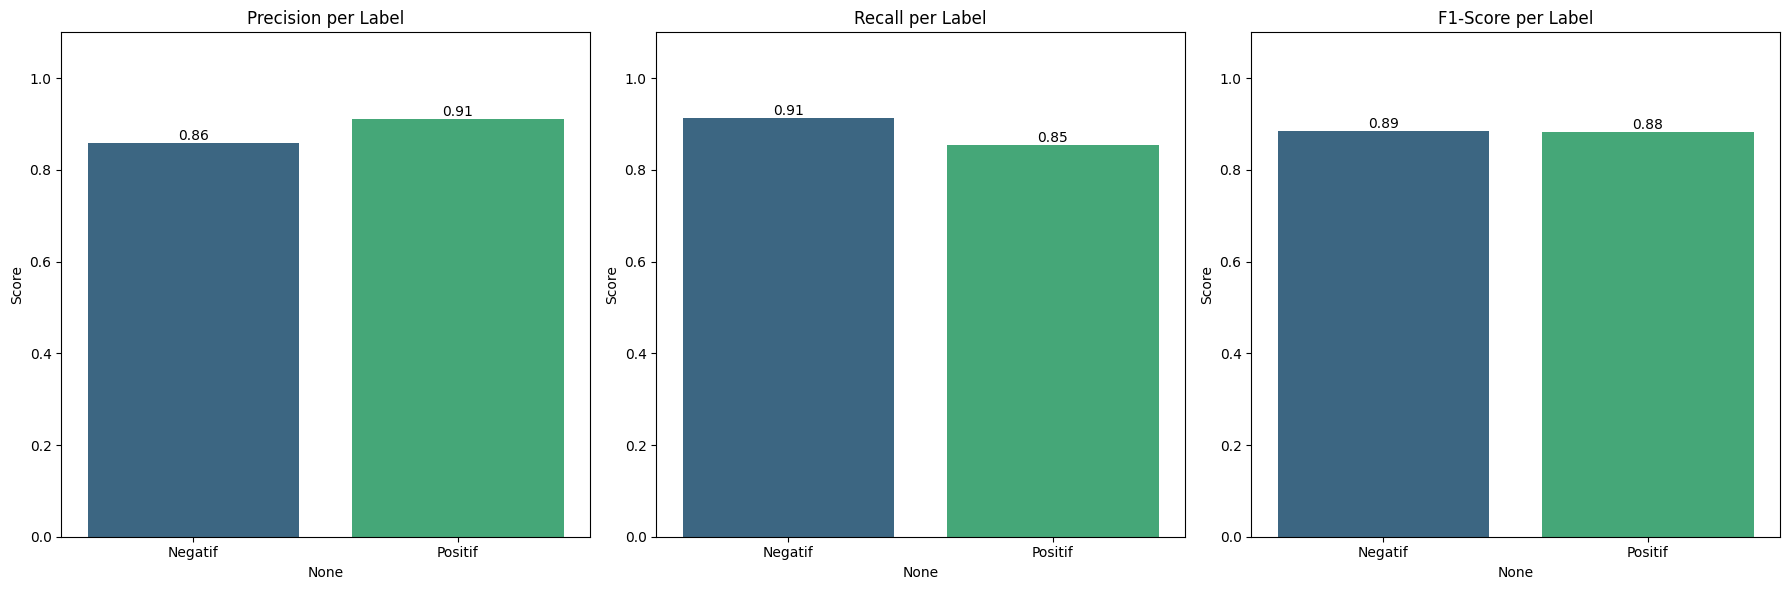


Confusion Matrix:
[[158  15]
 [ 26 153]]


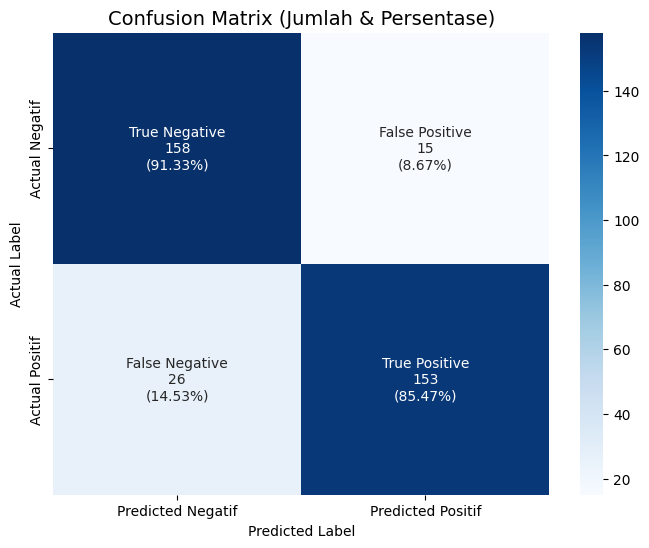

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Import display for DataFrame
import numpy as np # Import numpy for np.newaxis


# Pastikan y_test dan y_pred tersedia dari eksekusi sel prediksi sebelumnya
if 'y_test' in locals() and 'y_pred' in locals():
    print("Menampilkan kembali hasil evaluasi model (Classification Report dan Confusion Matrix):")

    # --- Tambahkan Visualisasi Diagram Pie Distribusi Aktual di Test Set ---
    print("\nMembuat diagram pie distribusi sentimen aktual di data test...")

    # Hitung jumlah ulasan per label sentimen di data test
    test_sentiment_counts = y_test.value_counts()

    # Siapkan data untuk pie chart
    labels = test_sentiment_counts.index # Label (Positif, Negatif)
    sizes = test_sentiment_counts.values # Jumlah ulasan per label
    colors = sns.color_palette('viridis')[0:len(labels)] # Ambil warna dari palet viridis

    plt.figure(figsize=(8, 8)) # Atur ukuran figure
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
    # autopct menampilkan persentase pada slice
    # startangle mengatur sudut awal slice pertama
    # textprops mengatur properti teks persentase dan label

    plt.title('Diagram Pie Distribusi Sentimen Aktual di Data Test', fontsize=16) # Tambahkan judul
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

    print("Diagram pie distribusi sentimen aktual di data test selesai dibuat.")
    # --- Akhir Tambahan Visualisasi Diagram Pie ---


    try:
        # Hitung Classification Report
        report_dict = classification_report(y_test, y_pred, output_dict=True)

        # Konversi dictionary report ke DataFrame untuk tampilan tabel
        df_report_new = pd.DataFrame(report_dict).transpose()

        print("\nClassification Report:")
        display(df_report_new)

        # --- Tambahkan Visualisasi Classification Report ---
        # Hapus baris 'accuracy', 'macro avg', dan 'weighted avg' untuk plotting per label
        df_plot = df_report_new.drop(['accuracy', 'macro avg', 'weighted avg'])

        fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # 1 baris, 3 kolom subplot

        # Plot Precision
        sns.barplot(x=df_plot.index, y='precision', data=df_plot, ax=axes[0], palette='viridis')
        axes[0].set_title('Precision per Label')
        axes[0].set_ylabel('Score')
        axes[0].set_ylim(0, 1.1) # Atur batas y untuk lebih jelas
        for container in axes[0].containers:
            axes[0].bar_label(container, fmt='%.2f')

        # Plot Recall
        sns.barplot(x=df_plot.index, y='recall', data=df_plot, ax=axes[1], palette='viridis')
        axes[1].set_title('Recall per Label')
        axes[1].set_ylabel('Score')
        axes[1].set_ylim(0, 1.1)
        for container in axes[1].containers:
            axes[1].bar_label(container, fmt='%.2f')

        # Plot F1-Score
        sns.barplot(x=df_plot.index, y='f1-score', data=df_plot, ax=axes[2], palette='viridis')
        axes[2].set_title('F1-Score per Label')
        axes[2].set_ylabel('Score')
        axes[2].set_ylim(0, 1.1)
        for container in axes[2].containers:
            axes[2].bar_label(container, fmt='%.2f')

        plt.tight_layout() # Sesuaikan layout
        plt.show()
        # --- Akhir Tambahan Visualisasi ---


        # Hitung Confusion Matrix (Jumlah Mentah)
        # Dapatkan urutan label yang benar dari data
        labels_order = np.unique(y_test) # Atau np.unique(y_pred), hasilnya sama
        cm = confusion_matrix(y_test, y_pred, labels=labels_order) # Gunakan urutan label yang benar
        print("\nConfusion Matrix:")
        print(cm)

        # Visualisasi Confusion Matrix dengan Jumlah Mentah dan Persentase
        plt.figure(figsize=(8, 6))

        # Hitung persentase dari Confusion Matrix
        # Pembagian per baris (total aktual per kelas)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Format untuk anotasi: "Jumlah Mentah\n(Persentase%)"
        # Dapatkan jumlah mentah dan persentase dalam bentuk string
        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm_percent.flatten()]

        # Definisikan nama label lengkap untuk TP, TN, FP, FN
        labels_full = ['True Negative', 'False Positive', 'False Negative', 'True Positive']


        # Gabungkan label lengkap, jumlah mentah, dan persentase dengan baris baru (\n)
        # Layout: Label Lengkap\nJumlah Mentah\n(Persentase)
        annotations_with_labels_full = [f"{label}\n{count}\n({percent})"
                                   for label, count, percent in zip(labels_full, group_counts, group_percentages)]


        # Susun kembali anotasi dalam bentuk 2x2 untuk heatmap
        annotations_with_labels_full = np.asarray(annotations_with_labels_full).reshape(2, 2)


        # Definisikan tick labels untuk sumbu X dan Y berdasarkan urutan labels_order
        tick_labels = [label for label in labels_order]

        sns.heatmap(cm, annot=annotations_with_labels_full, fmt='', cmap='Blues',
                    xticklabels=[f'Predicted {label}' for label in tick_labels],
                    yticklabels=[f'Actual {label}' for label in tick_labels])
        plt.xlabel('Predicted Label')
        plt.ylabel('Actual Label')
        plt.title('Confusion Matrix (Jumlah & Persentase)', fontsize=14) # Ganti judul agar lebih jelas
        plt.show()

    except Exception as e:
        print(f"Terjadi error saat membuat atau menampilkan hasil evaluasi: {e}")

else:
    print("Variabel y_test atau y_pred tidak ditemukan. Mohon jalankan sel prediksi model terlebih dahulu.")

## Penjelasan Detail Tahapan dalam Support Vector Machine (SVM) untuk Klasifikasi Sentimen

Setelah data teks diolah melalui pra-pemrosesan dan diubah menjadi representasi numerik menggunakan TF-IDF, langkah selanjutnya dalam penelitian ini adalah menggunakan model Support Vector Machine (SVM) untuk melakukan klasifikasi sentimen.

Berikut adalah tahapan-tahapan utama dalam proses ini:

### Tahap 1: Inisialisasi Model SVM

*   **Tujuan**: Mempersiapkan model SVM sebelum dilatih.
*   **Penjelasan**: Pada tahap ini, kita memilih algoritma SVM yang akan digunakan dan menentukan parameter-parameternya. Parameter umum meliputi:
    *   `kernel`: Menentukan jenis fungsi kernel yang digunakan (misalnya, `linear`, `rbf`, `poly`). Kernel linear seringkali efektif untuk data teks dengan representasi TF-IDF.
    *   `C`: Parameter regularisasi yang mengontrol *trade-off* antara memaksimalkan margin (jarak antara hyperplane pemisah dan titik data terdekat) dan meminimalkan kesalahan klasifikasi. Nilai `C` yang lebih kecil menciptakan margin yang lebih luas tetapi mungkin menerima lebih banyak kesalahan klasifikasi, sedangkan nilai `C` yang lebih besar menciptakan margin yang lebih sempit tetapi berusaha mengklasifikasikan semua titik dengan benar.
    *   `random_state`: Untuk memastikan hasil yang konsisten saat model diinisialisasi.
*   **Dalam Kode Anda**: Model `SVC` (Support Vector Classifier) dari scikit-learn diinisialisasi. Penggunaan `kernel='linear'` dipilih.

### Tahap 2: Pelatihan Model SVM (Fitting)

*   **Tujuan**: Mengajarkan model SVM untuk belajar pola dari data training (fitur dan label) sehingga model dapat membedakan antara kelas-kelas sentimen.
*   **Penjelasan**: Proses pelatihan (`fit`) melibatkan algoritma SVM dalam menemukan *hyperplane* optimal yang paling baik memisahkan data training dari kelas-kelas yang berbeda (dalam kasus ini, sentimen Positif dan Negatif) di ruang fitur TF-IDF.
    *   Untuk kernel linear, ini berarti mencari garis (untuk data 2D), bidang (untuk data 3D), atau *hyperplane* (untuk data >3D) yang memaksimalkan jarak (margin) antara titik data dari kedua kelas yang terdekat (*support vectors*).
    *   Model belajar bobot (koefisien) untuk setiap fitur (kata/bigram TF-IDF) dan bias (intercept) yang mendefinisikan *hyperplane* pemisah ini.
*   **Dalam Kode Anda**: Metode `.fit(X_train_tfidf, y_train)` dipanggil, di mana `X_train_tfidf` adalah matriks fitur TF-IDF dari data training, dan `y_train` adalah label sentimen yang sesuai untuk data training.

### Tahap 3: Prediksi pada Data Test

*   **Tujuan**: Menggunakan model yang sudah dilatih untuk memprediksi label sentimen pada data yang belum pernah dilihat sebelumnya (data test).
*   **Penjelasan**: Setelah model SVM dilatih, model siap digunakan untuk klasifikasi. Pada tahap prediksi (`predict`), model mengambil data fitur test (`X_test_tfidf`) dan, berdasarkan *hyperplane* yang telah dipelajari, model menentukan kelas (Positif atau Negatif) mana yang paling mungkin untuk setiap sampel (ulasan) di data test.
    *   Secara internal, model menghitung jarak setiap titik data test ke *hyperplane*. Tanda dari jarak ini (positif atau negatif) menentukan sisi *hyperplane* mana titik data tersebut berada, dan oleh karena itu, kelas prediksinya.
*   **Dalam Kode Anda**: Metode `.predict(X_test_tfidf)` dipanggil, dan hasil prediksinya disimpan dalam variabel `y_pred`.

### Tahap 4: Evaluasi Model

*   **Tujuan**: Mengukur seberapa baik kinerja model dalam memprediksi sentimen pada data test.
*   **Penjelasan**: Evaluasi dilakukan dengan membandingkan label sentimen yang diprediksi oleh model (`y_pred`) dengan label sentimen yang sebenarnya (aktual) dari data test (`y_test`). Berbagai metrik dihitung dari perbandingan ini untuk memberikan gambaran komprehensif tentang performa model.
    *   Metrik utama meliputi Accuracy, Precision, Recall, dan F1-Score, seperti yang dijelaskan di notes sebelumnya.
    *   Confusion Matrix juga dibuat untuk visualisasi detail hasil prediksi (jumlah True Positif, True Negatif, False Positif, False Negatif).
*   **Dalam Kode Anda**: Fungsi `classification_report`, `confusion_matrix`, dan `accuracy_score` dari scikit-learn digunakan untuk menghasilkan metrik-metrik ini.

#### Perhitungan Manual Akurasi Berdasarkan Confusion Matrix

Akurasi adalah salah satu metrik evaluasi paling umum. Ini mengukur proporsi prediksi yang benar dari total jumlah prediksi.

**Rumus Akurasi:**

$$ \text{Akurasi} = \frac{\text{True Positif (TP)} + \text{True Negatif (TN)}}{\text{True Positif (TP)} + \text{True Negatif (TN)} + \text{False Positif (FP)} + \text{False Negative (FN)}} $$

Atau, secara lebih sederhana:

$$ \text{Akurasi} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Jumlah Sampel}} $$

Berdasarkan Confusion Matrix yang dihasilkan di output sel `326a329b`:

## Penjelasan Detail Tahapan dalam Support Vector Machine (SVM) untuk Klasifikasi Sentimen

Setelah data teks diolah melalui pra-pemrosesan dan diubah menjadi representasi numerik menggunakan TF-IDF, langkah selanjutnya dalam penelitian ini adalah menggunakan model Support Vector Machine (SVM) untuk melakukan klasifikasi sentimen.

Berikut adalah tahapan-tahapan utama dalam proses ini:

### Tahap 1: Inisialisasi Model SVM

*   **Tujuan**: Mempersiapkan model SVM sebelum dilatih.
*   **Penjelasan**: Pada tahap ini, kita memilih algoritma SVM yang akan digunakan dan menentukan parameter-parameternya. Parameter umum meliputi:
    *   `kernel`: Menentukan jenis fungsi kernel yang digunakan (misalnya, `linear`, `rbf`, `poly`). Kernel linear seringkali efektif untuk data teks dengan representasi TF-IDF.
    *   `C`: Parameter regularisasi yang mengontrol *trade-off* antara memaksimalkan margin (jarak antara hyperplane pemisah dan titik data terdekat) dan meminimalkan kesalahan klasifikasi. Nilai `C` yang lebih kecil menciptakan margin yang lebih luas tetapi mungkin menerima lebih banyak kesalahan klasifikasi, sedangkan nilai `C` yang lebih besar menciptakan margin yang lebih sempit tetapi berusaha mengklasifikasikan semua titik dengan benar.
    *   `random_state`: Untuk memastikan hasil yang konsisten saat model diinisialisasi.
*   **Dalam Kode Anda**: Model `SVC` (Support Vector Classifier) dari scikit-learn diinisialisasi. Penggunaan `kernel='linear'` dipilih.

### Tahap 2: Pelatihan Model SVM (Fitting)

*   **Tujuan**: Mengajarkan model SVM untuk belajar pola dari data training (fitur dan label) sehingga model dapat membedakan antara kelas-kelas sentimen.
*   **Penjelasan**: Proses pelatihan (`fit`) melibatkan algoritma SVM dalam menemukan *hyperplane* optimal yang paling baik memisahkan data training dari kelas-kelas yang berbeda (dalam kasus ini, sentimen Positif dan Negatif) di ruang fitur TF-IDF.
    *   Untuk kernel linear, ini berarti mencari garis (untuk data 2D), bidang (untuk data 3D), atau *hyperplane* (untuk data >3D) yang memaksimalkan jarak (margin) antara titik data dari kedua kelas yang terdekat (*support vectors*).
    *   Model belajar bobot (koefisien) untuk setiap fitur (kata/bigram TF-IDF) dan bias (intercept) yang mendefinisikan *hyperplane* pemisah ini.
*   **Dalam Kode Anda**: Metode `.fit(X_train_tfidf, y_train)` dipanggil, di mana `X_train_tfidf` adalah matriks fitur TF-IDF dari data training, dan `y_train` adalah label sentimen yang sesuai untuk data training.

### Tahap 3: Prediksi pada Data Test

*   **Tujuan**: Menggunakan model yang sudah dilatih untuk memprediksi label sentimen pada data yang belum pernah dilihat sebelumnya (data test).
*   **Penjelasan**: Setelah model SVM dilatih, model siap digunakan untuk klasifikasi. Pada tahap prediksi (`predict`), model mengambil data fitur test (`X_test_tfidf`) dan, berdasarkan *hyperplane* yang telah dipelajari, model menentukan kelas (Positif atau Negatif) mana yang paling mungkin untuk setiap sampel (ulasan) di data test.
    *   Secara internal, model menghitung jarak setiap titik data test ke *hyperplane*. Tanda dari jarak ini (positif atau negatif) menentukan sisi *hyperplane* mana titik data tersebut berada, dan oleh karena itu, kelas prediksinya.
*   **Dalam Kode Anda**: Metode `.predict(X_test_tfidf)` dipanggil, dan hasil prediksinya disimpan dalam variabel `y_pred`.

### Tahap 4: Evaluasi Model

*   **Tujuan**: Mengukur seberapa baik kinerja model dalam memprediksi sentimen pada data test.
*   **Penjelasan**: Evaluasi dilakukan dengan membandingkan label sentimen yang diprediksi oleh model (`y_pred`) dengan label sentimen yang sebenarnya (aktual) dari data test (`y_test`). Berbagai metrik dihitung dari perbandingan ini untuk memberikan gambaran komprehensif tentang performa model.
    *   Metrik utama meliputi Accuracy, Precision, Recall, dan F1-Score, seperti yang dijelaskan di notes sebelumnya.
    *   Confusion Matrix juga dibuat untuk visualisasi detail hasil prediksi (jumlah True Positif, True Negatif, False Positif, False Negatif).
*   **Dalam Kode Anda**: Fungsi `classification_report`, `confusion_matrix`, dan `accuracy_score` dari scikit-learn digunakan untuk menghasilkan metrik-metrik ini.

#### Perhitungan Manual Akurasi Berdasarkan Confusion Matrix

Akurasi adalah salah satu metrik evaluasi paling umum. Ini mengukur proporsi prediksi yang benar dari total jumlah prediksi.

**Rumus Akurasi:**

$$ \text{Akurasi} = \frac{\text{True Positif (TP)} + \text{True Negatif (TN)}}{\text{True Positif (TP)} + \text{True Negatif (TN)} + \text{False Positif (FP)} + \text{False Negative (FN)}} $$

Atau, secara lebih sederhana:

$$ \text{Akurasi} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Jumlah Sampel}} $$

Berdasarkan Confusion Matrix yang dihasilkan di output sel `326a329b`:

Berikut adalah tahap-tahap klasifikasi sentimen menggunakan SVM yang dilakukan dalam penelitian ini:

a.  **Pembagian Data (Train-Test Split)**: Membagi keseluruhan data ulasan yang sudah diproses dan dilabeli menjadi data latih (sekitar 80% atau 1407 data) dan data uji (sekitar 20% atau 352 data). Pembagian ini dilakukan dengan memperhatikan stratifikasi label sentimen (`sentiment_label_weighted`) untuk memastikan distribusi label proporsional di kedua set data.
b.  **Pembobotan Fitur (TF-IDF Vectorization)**: Menerapkan pembobotan fitur TF-IDF pada data latih dan data uji secara terpisah. Vectorizer `TfidfVectorizer` dilatih hanya pada data latih (`fit_transform`) dan kemudian digunakan untuk mentransformasi data uji (`transform`). Tahap ini mengubah teks (token yang sudah diproses) menjadi representasi vektor numerik (matriks TF-IDF) yang merupakan input untuk model SVM.
c.  **Pelatihan Model SVM (Model Training)**: Menginisialisasi model Support Vector Machine (`SVC`) dan melatihnya (`fit`) menggunakan data latih yang sudah dibobot fitur TF-IDF (`X_train_tfidf`) dan label sentimen data latih (`y_train`). Model mempelajari *hyperplane* optimal yang memisahkan kelas-kelas sentimen.
d.  **Prediksi Klasifikasi (Classification Prediction)**: Menggunakan model SVM yang sudah dilatih (`svm_model`) untuk melakukan prediksi label sentimen (`y_pred`) pada data uji yang juga sudah dibobot fitur TF-IDF (`X_test_tfidf`).
e.  **Evaluasi Performa Model (Model Evaluation)**: Mengevaluasi hasil prediksi (`y_pred`) pada data uji dengan membandingkannya dengan label sentimen sebenarnya (`y_test`). Evaluasi dilakukan menggunakan metrik standar seperti akurasi, presisi, recall, dan F1-score, serta divisualisasikan menggunakan Confusion Matrix untuk menganalisis True Positif, True Negatif, False Positif, dan False Negatif.

### Langkah 1: Konsolidasi Hasil

Mengkonsolidasi semua data dan hasil analisis yang relevan untuk digunakan dalam pembuatan dashboard.

### Kesimpulan Lengkap Hasil Evaluasi Model

Berdasarkan analisis komprehensif dari berbagai metrik dan visualisasi hasil evaluasi model klasifikasi sentimen pada data test, berikut adalah kesimpulan lengkapnya:

1.  **Distribusi Sentimen Aktual (Diagram Pie):**
    *   Diagram pie menunjukkan bahwa distribusi sentimen pada data test cukup seimbang, dengan proporsi ulasan Positif sekitar 50.9% dan Negatif sekitar 49.1%. Keseimbangan ini penting untuk evaluasi yang adil menggunakan metrik seperti akurasi.

2.  **Ringkasan Performa Model (Classification Report):**
    *   **Akurasi Keseluruhan:** Model mencapai akurasi yang solid sebesar **88.35%**, menunjukkan bahwa sebagian besar prediksi model di data test adalah benar.
    *   **Metrik Rata-rata (Macro & Weighted Avg):** Nilai rata-rata Precision, Recall, dan F1-Score (baik macro maupun weighted) yang berkisar antara 0.88 hingga 0.89 mengindikasikan performa yang konsisten dan seimbang secara keseluruhan di kedua kelas.

3.  **Performa Detail per Label (Classification Report dan Diagram Batang):**
    *   Diagram batang Precision, Recall, dan F1-Score per label memberikan gambaran yang jelas:
        *   Model menunjukkan Recall yang sedikit lebih tinggi untuk kelas Negatif (sekitar 0.91) dibandingkan kelas Positif (sekitar 0.85). Ini berarti model sangat efektif dalam mengidentifikasi sebagian besar ulasan yang sebenarnya berbau negatif.
        *   Sebaliknya, model memiliki Precision yang sedikit lebih tinggi untuk kelas Positif (sekitar 0.91) dibandingkan kelas Negatif (sekitar 0.86). Ini menandakan bahwa ketika model memprediksi ulasan sebagai positif, kemungkinannya sangat tinggi bahwa prediksi tersebut benar.
        *   F1-Score untuk kedua kelas cukup dekat (sekitar 0.89 untuk Negatif dan 0.88 untuk Positif), menunjukkan keseimbangan yang baik antara Precision dan Recall dalam performa gabungan per kelas.

4.  **Analisis Kesalahan Spesifik (Confusion Matrix):**
    *   Confusion Matrix memberikan detail kuantitatif tentang prediksi yang benar dan salah:
        *   **True Negative (TN):** Sejumlah besar ulasan Negatif berhasil diprediksi dengan benar sebagai Negatif.
        *   **False Positive (FP):** Jumlah ulasan yang sebenarnya Negatif tetapi salah diprediksi sebagai Positif (kesalahan Tipe I) relatif rendah. Ini didukung oleh Precision yang cukup tinggi untuk kelas Positif.
        *   **False Negative (FN):** Jumlah ulasan yang sebenarnya Positif tetapi salah diprediksi sebagai Negatif (kesalahan Tipe II) juga relatif rendah, meskipun sedikit lebih tinggi dari False Positive. Ini konsisten dengan Recall kelas Positif yang sedikit di bawah Recall kelas Negatif.
        *   **True Positive (TP):** Sejumlah besar ulasan Positif berhasil diprediksi dengan benar sebagai Positif.

**Kesimpulan Akhir:**

Model klasifikasi sentimen yang dikembangkan menggunakan Support Vector Machine (SVM) dengan fitur TF-IDF menunjukkan performa yang kuat dan seimbang dalam mengklasifikasikan sentimen ulasan aplikasi BSGtouch pada data test. Dengan akurasi keseluruhan 88.35% dan metrik Precision, Recall, serta F1-Score yang tinggi untuk kedua kelas, model ini efektif dalam membedakan antara ulasan positif dan negatif. Analisis detail pada confusion matrix mengkonfirmasi bahwa model memiliki kemampuan yang baik dalam mendeteksi ulasan negatif dan menjaga ketepatan prediksi positif. Model ini dapat diandalkan untuk memberikan gambaran sentimen pengguna berdasarkan data ulasan.

In [ ]:
# Periksa ketersediaan data dan hasil dari langkah-langkah sebelumnya

# Data ulasan dengan label sentimen
if 'df_reviews' in locals() and not df_reviews.empty:
    print("DataFrame 'df_reviews' (data ulasan setelah pra-pemrosesan dan pelabelan) tersedia.")
else:
    print("DataFrame 'df_reviews' tidak ditemukan atau kosong. Mohon jalankan kembali langkah-langkah pra-pemrosesan dan pelabelan sentimen.")
    # Optional: Load from saved CSV if available
    # try:
    #     df_reviews = pd.read_csv('data_review_bsgtouch_sentimen_labeled.csv')
    #     print("DataFrame 'df_reviews' berhasil dimuat dari CSV.")
    # except FileNotFoundError:
    #     print("File CSV data berlabel tidak ditemukan.")


# Hitungan distribusi sentimen
if 'sentiment_counts' in locals() and not sentiment_counts.empty:
    print("Hasil hitungan distribusi sentimen ('sentiment_counts') tersedia.")
else:
    print("Hasil hitungan distribusi sentimen ('sentiment_counts') tidak ditemukan. Mohon jalankan langkah analisis distribusi sentimen.")
    # Optional: Recalculate if df_reviews is available
    # if 'df_reviews' in locals() and not df_reviews.empty and 'sentiment_label_weighted' in df_reviews.columns:
    #      sentiment_counts = df_reviews['sentiment_label_weighted'].value_counts()
    #      print("Hasil hitungan distribusi sentimen dihitung ulang.")


# Token yang dipisahkan berdasarkan sentimen (untuk Word Cloud)
if 'df_positive' in locals() and not df_positive.empty and 'df_negative' in locals() and not df_negative.empty:
    print("Data ulasan terpisah berdasarkan sentimen ('df_positive', 'df_negative') tersedia.")
    # Pastikan kolom token yang relevan ada dan dalam format list
    token_col = 'stemmed_tokens_normalized' # Sesuaikan nama kolom token
    if token_col in df_positive.columns and token_col in df_negative.columns:
        # Convert string representation of list to list if needed (e.g., if loaded from CSV)
        def safe_string_list_to_list(string_list):
            if isinstance(string_list, list):
                return string_list
            if isinstance(string_list, str):
                try:
                    return ast.literal_eval(string_list)
                except (SyntaxError, ValueError):
                    return []
            return []

        df_positive[token_col] = df_positive[token_col].apply(safe_string_list_to_list)
        df_negative[token_col] = df_negative[token_col].apply(safe_string_list_to_list)
        print(f"Kolom token '{token_col}' di df_positive dan df_negative siap.")
    else:
         print(f"Kolom token '{token_col}' tidak ditemukan di df_positive atau df_negative.")

else:
    print("Data ulasan terpisah berdasarkan sentimen ('df_positive', 'df_negative') tidak ditemukan atau kosong. Mohon jalankan langkah analisis kata kunci.")


# Metrik evaluasi model (classification report, confusion matrix)
if 'report_dict' in locals() and 'cm' in locals():
    print("Hasil evaluasi model (classification report dict, confusion matrix) tersedia.")
    # Optional: Create DataFrame from report_dict if needed for display
    # df_report = pd.DataFrame(report_dict).transpose()

else:
    print("Hasil evaluasi model tidak ditemukan. Mohon jalankan langkah evaluasi model.")

# Model dan Vectorizer (jika perlu untuk analisis lebih lanjut, tapi mungkin tidak untuk dashboard ringkasan)
# if 'svm_model' in locals() and 'tfidf_vectorizer' in locals():
#     print("Model SVM dan TF-IDF vectorizer tersedia.")
# else:
#     print("Model atau vectorizer tidak ditemukan.")

print("\nKonsolidasi hasil selesai.")

DataFrame 'df_reviews' (data ulasan setelah pra-pemrosesan dan pelabelan) tersedia.
Hasil hitungan distribusi sentimen ('sentiment_counts') tersedia.
Data ulasan terpisah berdasarkan sentimen ('df_positive', 'df_negative') tersedia.
Kolom token 'stemmed_tokens_normalized' di df_positive dan df_negative siap.
Hasil evaluasi model (classification report dict, confusion matrix) tersedia.

Konsolidasi hasil selesai.


### Langkah 2: Visualisasi Utama - Word Cloud

Visualisasi Word Cloud menampilkan kata-kata yang paling sering muncul dalam kelompok ulasan Positif dan Negatif. Ukuran kata dalam Word Cloud mencerminkan frekuensinya; kata yang lebih besar muncul lebih sering.

In [ ]:
!pip install wordcloud matplotlib



Membuat Word Cloud untuk Sentimen Positif dan Negatif...


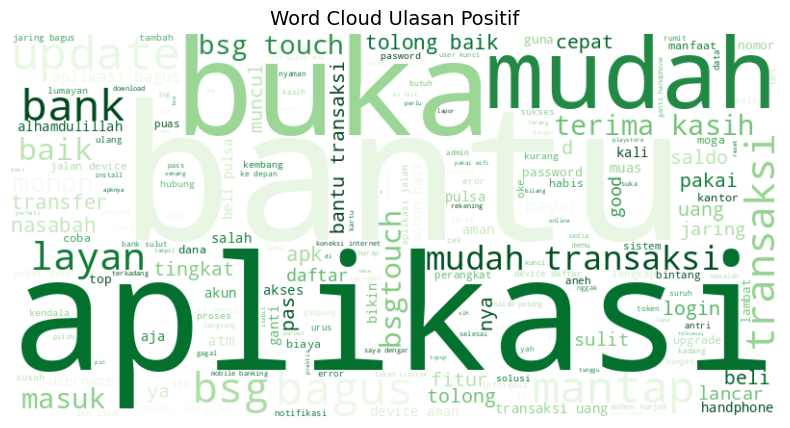

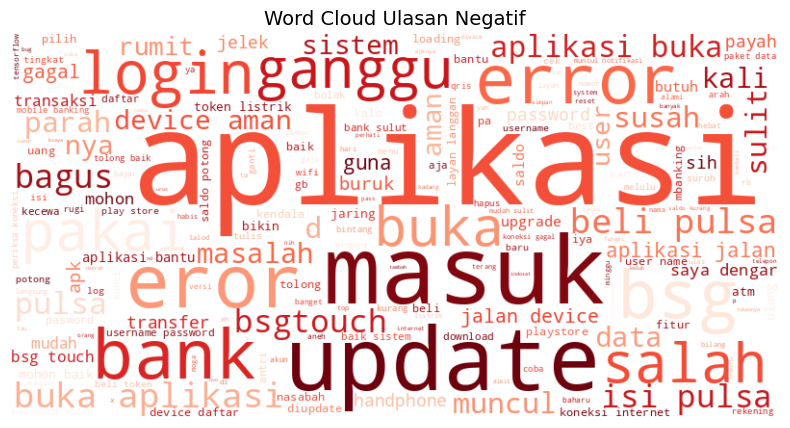

Pembuatan Word Cloud selesai.


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import itertools # Diperlukan untuk menggabungkan list token
import ast # Diperlukan untuk safe_string_list_to_list yang lebih robust

# Pastikan DataFrame df_reviews ada dan memiliki kolom yang dibutuhkan
required_cols = ['stemmed_tokens_normalized', 'sentiment_label_weighted']
if 'df_reviews' in locals() and not df_reviews.empty and all(col in df_reviews.columns for col in required_cols):
    print("\nMembuat Word Cloud untuk Sentimen Positif dan Negatif...")

    # 1. Pisahkan ulasan berdasarkan label sentimen
    positive_reviews = df_reviews[df_reviews['sentiment_label_weighted'] == 'Positif'].copy()
    negative_reviews = df_reviews[df_reviews['sentiment_label_weighted'] == 'Negatif'].copy()

    # Tentukan kolom token yang akan digunakan (stemmed tokens)
    token_column = 'stemmed_tokens_normalized'

    # Pastikan kolom token berisi list of strings. Jika data dibaca dari CSV,
    # kolom list mungkin dibaca sebagai string. Perlu konversi.
    # Menggunakan ast.literal_eval lebih aman daripada eval() jika formatnya konsisten.
    def safe_string_list_to_list(string_list):
        if isinstance(string_list, list):
            return string_list
        if isinstance(string_list, str):
            try:
                # Coba parse string literal seperti "['kata1', 'kata2']"
                return ast.literal_eval(string_list)
            except (SyntaxError, ValueError):
                # Jika gagal, kembalikan list kosong atau sesuai penanganan error
                return []
        return []

    # Apply the safe conversion
    positive_reviews[token_column] = positive_reviews[token_column].apply(safe_string_list_to_list)
    negative_reviews[token_column] = negative_reviews[token_column].apply(safe_string_list_to_list)


    # 2. Gabungkan semua token untuk setiap sentimen menjadi satu string
    # Gabungkan list of lists menjadi satu list datar
    all_positive_tokens = list(itertools.chain.from_iterable(positive_reviews[token_column]))
    all_negative_tokens = list(itertools.chain.from_iterable(negative_reviews[token_column]))

    # Gabungkan token dalam list menjadi satu string besar, dipisahkan oleh spasi
    positive_text = " ".join(all_positive_tokens)
    negative_text = " ".join(all_negative_tokens)

    # 3. Buat objek WordCloud
    # Anda bisa menyesuaikan parameter seperti width, height, background_color, max_words
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text) # Menggunakan colormap merah untuk negatif

    # 4. Tampilkan Word Cloud (Terpisah)

    # Word Cloud Positif
    plt.figure(figsize=(10, 5)) # Atur ukuran figure untuk plot positif
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis("off") # Sembunyikan sumbu
    plt.title('Word Cloud Ulasan Positif', fontsize=14)
    plt.show() # Tampilkan figure positif

    # Word Cloud Negatif
    plt.figure(figsize=(10, 5)) # Atur ukuran figure untuk plot negatif
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis("off") # Sembunyikan sumbu
    plt.title('Word Cloud Ulasan Negatif', fontsize=14)
    plt.show() # Tampilkan figure negatif


    print("Pembuatan Word Cloud selesai.")

else:
    print("\nDataFrame df_reviews atau kolom yang dibutuhkan ('stemmed_tokens_normalized', 'sentiment_label_weighted') tidak ditemukan.")
    print("Tidak dapat membuat Word Cloud. Pastikan langkah pre-processing dan pelabelan sentimen sudah selesai.")


### Langkah 2: Visualisasi Utama - Evaluasi Model

Visualisasi Classification Report dan Confusion Matrix memberikan gambaran detail mengenai performa model klasifikasi sentimen (SVM) pada data test.

Menampilkan kembali hasil evaluasi model (Classification Report dan Confusion Matrix):

Classification Report:


,precision,recall,f1-score,support
Negatif,0.858696,0.913295,0.885154,173.000000
Positif,0.910714,0.854749,0.881844,179.000000
accuracy,0.883523,0.883523,0.883523,0.883523
macro avg,0.884705,0.884022,0.883499,352.000000
weighted avg,0.885148,0.883523,0.883471,352.000000


/tmp/ipython-input-1425573253.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_plot.index, y='precision', data=df_plot, ax=axes[0], palette='viridis')
/tmp/ipython-input-1425573253.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_plot.index, y='recall', data=df_plot, ax=axes[1], palette='viridis')
/tmp/ipython-input-1425573253.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_plot.index, y='f1-score', data=df_plot, ax=axes[2], palette='viridis')


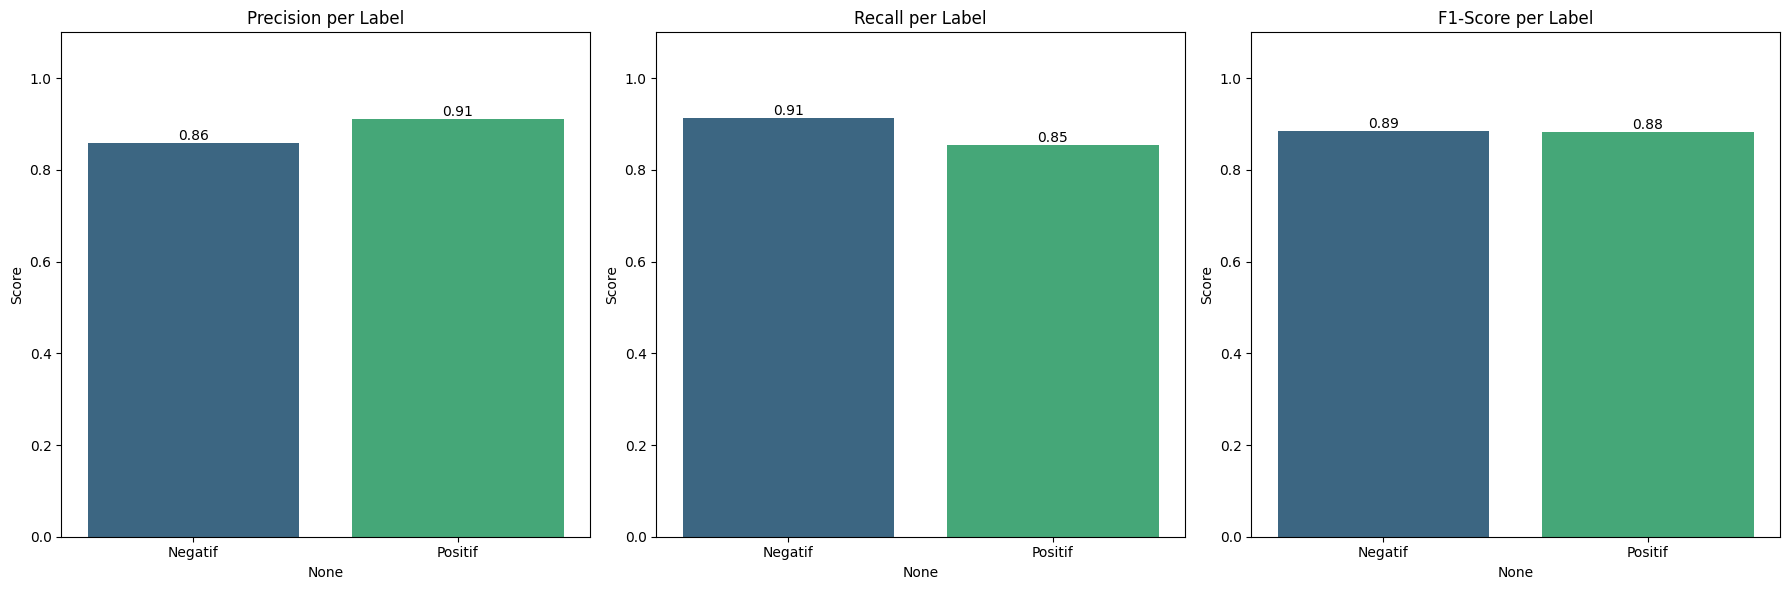


Confusion Matrix:
[[158  15]
 [ 26 153]]


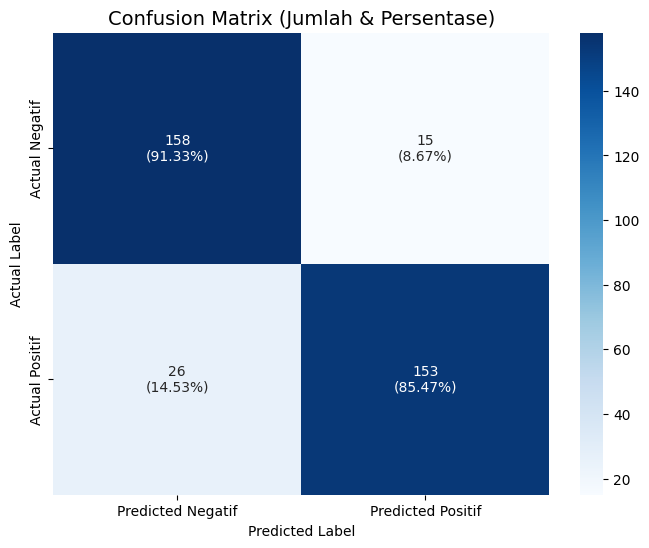

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Import display for DataFrame
import numpy as np # Import numpy for np.newaxis


# Pastikan y_test dan y_pred tersedia dari eksekusi sel prediksi sebelumnya
if 'y_test' in locals() and 'y_pred' in locals():
    print("Menampilkan kembali hasil evaluasi model (Classification Report dan Confusion Matrix):")

    try:
        # Hitung Classification Report
        report_dict = classification_report(y_test, y_pred, output_dict=True)

        # Konversi dictionary report ke DataFrame untuk tampilan tabel
        df_report_new = pd.DataFrame(report_dict).transpose()

        print("\nClassification Report:")
        display(df_report_new)

        # --- Tambahkan Visualisasi Classification Report ---
        # Hapus baris 'accuracy', 'macro avg', dan 'weighted avg' untuk plotting per label
        df_plot = df_report_new.drop(['accuracy', 'macro avg', 'weighted avg'])

        fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # 1 baris, 3 kolom subplot

        # Plot Precision
        sns.barplot(x=df_plot.index, y='precision', data=df_plot, ax=axes[0], palette='viridis')
        axes[0].set_title('Precision per Label')
        axes[0].set_ylabel('Score')
        axes[0].set_ylim(0, 1.1) # Atur batas y untuk lebih jelas
        for container in axes[0].containers:
            axes[0].bar_label(container, fmt='%.2f')

        # Plot Recall
        sns.barplot(x=df_plot.index, y='recall', data=df_plot, ax=axes[1], palette='viridis')
        axes[1].set_title('Recall per Label')
        axes[1].set_ylabel('Score')
        axes[1].set_ylim(0, 1.1)
        for container in axes[1].containers:
            axes[1].bar_label(container, fmt='%.2f')

        # Plot F1-Score
        sns.barplot(x=df_plot.index, y='f1-score', data=df_plot, ax=axes[2], palette='viridis')
        axes[2].set_title('F1-Score per Label')
        axes[2].set_ylabel('Score')
        axes[2].set_ylim(0, 1.1)
        for container in axes[2].containers:
            axes[2].bar_label(container, fmt='%.2f')

        plt.tight_layout() # Sesuaikan layout
        plt.show()
        # --- Akhir Tambahan Visualisasi ---


        # Hitung Confusion Matrix (Jumlah Mentah)
        # Dapatkan urutan label yang benar dari data
        labels_order = np.unique(y_test) # Atau np.unique(y_pred), hasilnya sama
        cm = confusion_matrix(y_test, y_pred, labels=labels_order) # Gunakan urutan label yang benar
        print("\nConfusion Matrix:")
        print(cm)

        # Visualisasi Confusion Matrix dengan Jumlah Mentah dan Persentase
        plt.figure(figsize=(8, 6))

        # Hitung persentase dari Confusion Matrix
        # Pembagian per baris (total aktual per kelas)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # Format untuk anotasi: "Jumlah Mentah\n(Persentase%)"

        # Definisikan label untuk heatmap berdasarkan urutan labels_order
        # Urutan akan sesuai dengan labels_order (misal: ['Negatif', 'Positif'])
        group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positif'] # Sesuaikan urutan nama grup
        # Jika labels_order adalah ['Negatif', 'Positif'], maka:
        # Top-Left: Actual Neg, Predicted Neg (True Negative)
        # Top-Right: Actual Neg, Predicted Pos (False Positive)
        # Bottom-Left: Actual Pos, Predicted Neg (False Negative)
        # Bottom-Right: Actual Pos, Predicted Pos (True Positive)

        # Reorder group_names based on labels_order for clarity in annotation logic
        # This is a bit complex, simpler is to just get the counts and percentages
        # and let the heatmap handle the order based on xticklabels/yticklabels

        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()] # Ambil jumlah mentah
        group_percentages = ["{0:.2%}".format(value) for value in cm_percent.flatten()] # Ambil persentase, format % dengan 2 desimal

        # Gabungkan jumlah dan persentase
        annotations = [f"{count}\n({percent})" for count, percent in zip(group_counts, group_percentages)]
        annotations = np.asarray(annotations).reshape(2, 2) # Susun kembali dalam bentuk 2x2

        # Definisikan tick labels berdasarkan urutan labels_order
        # Misalnya, jika labels_order = ['Negatif', 'Positif']
        tick_labels = [label for label in labels_order]


        sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues',
                    xticklabels=[f'Predicted {label}' for label in tick_labels], # Sesuaikan tick labels X
                    yticklabels=[f'Actual {label}' for label in tick_labels]) # Sesuaikan tick labels Y
        plt.xlabel('Predicted Label')
        plt.ylabel('Actual Label')
        plt.title('Confusion Matrix (Jumlah & Persentase)', fontsize=14) # Ganti judul
        plt.show()

    except Exception as e:
        print(f"Terjadi error saat membuat atau menampilkan hasil evaluasi: {e}")

else:
    print("Variabel y_test atau y_pred tidak ditemukan. Mohon jalankan sel prediksi model terlebih dahulu.")

In [ ]:
import pandas as pd
from IPython.display import display, HTML

print("--- Dashboard Ringkasan Hasil Analisis Sentimen ---")

# 1. Tampilkan Distribusi Sentimen
print("\n1. Distribusi Sentimen Ulasan:")
if 'sentiment_counts' in locals():
    print(sentiment_counts)
    if 'sentiment_percentages' in locals():
         print("\nPersentase:")
         print(sentiment_percentages.round(2))
else:
    print("Data distribusi sentimen tidak tersedia.")

# 2. Tampilkan Ringkasan Metrik Evaluasi Model
print("\n2. Ringkasan Metrik Evaluasi Model:")
if 'df_summary' in locals() and not df_summary.empty:
    display(df_summary)
elif 'report_dict' in locals() and 'accuracy' in locals():
     # Jika df_summary belum dibuat, buat dari report_dict dan accuracy
     print("Membuat ringkasan metrik dari report_dict dan accuracy...")
     try:
         weighted_avg_precision = report_dict['weighted avg']['precision']
         weighted_avg_recall = report_dict['weighted avg']['recall']
         weighted_avg_f1_score = report_dict['weighted avg']['f1-score']
         overall_accuracy = accuracy

         summary_metrics = {
             'Metric': ['Overall Accuracy', 'Weighted Avg Precision', 'Weighted Avg Recall', 'Weighted Avg F1-Score'],
             'Score': [overall_accuracy, weighted_avg_precision, weighted_avg_recall, weighted_avg_f1_score]
         }
         df_summary_recreated = pd.DataFrame(summary_metrics)
         df_summary_recreated['Score'] = df_summary_recreated.apply(
             lambda row: f"{row['Score']:.2%}" if row['Metric'] == 'Overall Accuracy' else f"{row['Score']:.2f}",
             axis=1
         )
         display(df_summary_recreated)
     except Exception as e:
         print(f"Error saat membuat ringkasan metrik: {e}")
else:
    print("Data metrik evaluasi model tidak tersedia (report_dict atau accuracy).")


# 3. Tampilkan Contoh Ulasan dengan Prediksi Sentimen (Opsional)
# Memerlukan df_reviews dan y_pred
print("\n3. Contoh Ulasan dengan Prediksi Sentimen:")
if 'df_reviews' in locals() and not df_reviews.empty and 'y_pred' in locals() and 'y_test' in locals():
    try:
        # Buat DataFrame sementara dengan ulasan asli, label asli, dan prediksi
        # Pastikan panjang y_pred sesuai dengan df_reviews (jika df_reviews sudah difilter sebelumnya)
        # Gunakan df_labeled jika tersedia dan merupakan sumber y_test/y_pred
        if 'df_labeled' in locals() and not df_labeled.empty:
             df_temp = df_labeled.copy() # Gunakan df_labeled jika ada
             # Pastikan df_temp memiliki index yang sama dengan y_test/y_pred jika subsetting dilakukan
             # Lebih aman gabungkan berdasarkan index dari y_test/y_pred ke df_labeled
             df_display_samples = df_temp.loc[y_test.index].copy()
             df_display_samples['Predicted_Sentiment'] = y_pred # Tambahkan kolom prediksi

             # Pilih kolom yang relevan untuk ditampilkan
             display_cols = ['content', 'sentiment_label_weighted', 'Predicted_Sentiment']
             available_display_cols = [col for col in display_cols if col in df_display_samples.columns]

             if available_display_cols:
                # Tampilkan beberapa sampel acak
                print("Beberapa sampel dari data test dengan label asli dan prediksi:")
                display(df_display_samples[available_display_cols].sample(min(10, len(df_display_samples)), random_state=42)) # Tampilkan 10 sampel

             else:
                 print("Kolom yang dibutuhkan untuk menampilkan contoh ulasan tidak ditemukan.")

        else:
             print("DataFrame asli atau data prediksi tidak lengkap untuk menampilkan contoh ulasan.")


    except Exception as e:
        print(f"Terjadi error saat menampilkan contoh ulasan: {e}")

else:
    print("DataFrame ulasan, label test (y_test), atau prediksi (y_pred) tidak tersedia.")


print("\n--- Akhir Dashboard Ringkasan ---")

--- Dashboard Ringkasan Hasil Analisis Sentimen ---

1. Distribusi Sentimen Ulasan:
sentiment_label_weighted
Positif    896
Negatif    863
Name: count, dtype: int64

Persentase:
sentiment_label_weighted
Positif    50.94
Negatif    49.06
Name: count, dtype: float64

2. Ringkasan Metrik Evaluasi Model:


,Metric,Score
0,Overall Accuracy,88.35%
1,Weighted Avg Precision,0.89
2,Weighted Avg Recall,0.88
3,Weighted Avg F1-Score,0.88



3. Contoh Ulasan dengan Prediksi Sentimen:
Beberapa sampel dari data test dengan label asli dan prediksi:


,content,sentiment_label_weighted,Predicted_Sentiment
200,Terbaik,Positif,Positif
775,Selalu banyak kendala dengan aplikasi ini apli...,Negatif,Positif
1224,Sangat membatu masyarakat sulut,Positif,Negatif
912,Aplikasi nya sring eror mohon di perbaiki,Negatif,Negatif
371,Masih sering eror,Negatif,Negatif
1077,Lancar,Positif,Positif
710,"Payah, sudah berapa hari gk bisa masuk",Negatif,Negatif
889,Sangat membantu..trima ksih BSG😊,Negatif,Negatif
944,Aplikasi yang bagus sangat membantu,Positif,Positif
421,Bank BSG tolong donk jangan persulit Nasabah p...,Positif,Positif



--- Akhir Dashboard Ringkasan ---


### Interpretasi Singkat Metrik Evaluasi Model

Berdasarkan ringkasan metrik yang ditampilkan:

*   **Overall Accuracy (Akurasi Keseluruhan):** Menunjukkan persentase ulasan yang berhasil diprediksi label sentimennya dengan benar oleh model di data test. Akurasi sekitar **88.35%** menunjukkan model cukup baik dalam membedakan sentimen secara umum.
*   **Weighted Avg Precision (Presisi Rata-rata Tertimbang):** Menunjukkan seberapa akurat prediksi positif model, dengan mempertimbangkan jumlah sampel di setiap kelas. Presisi sekitar **0.89** berarti ketika model memprediksi sebuah ulasan sebagai positif atau negatif, kemungkinan besar prediksi tersebut benar.
*   **Weighted Avg Recall (Recall Rata-rata Tertimbang):** Menunjukkan kemampuan model untuk menemukan semua ulasan yang sebenarnya positif atau negatif. Recall sekitar **0.88** berarti model berhasil mendeteksi sebagian besar ulasan yang sebenarnya positif atau negatif.
*   **Weighted Avg F1-Score (F1-Score Rata-rata Tertimbang):** Merupakan keseimbangan antara Precision dan Recall. F1-Score sekitar **0.88** menunjukkan performa model yang seimbang dalam hal akurasi prediksi positif dan kemampuan mendeteksi semua kasus positif.

Secara keseluruhan, metrik ini menunjukkan bahwa model klasifikasi sentimen Anda memiliki performa yang solid pada data test, dengan kemampuan yang baik dalam memprediksi dan mendeteksi ulasan positif maupun negatif.

In [ ]:
import pandas as pd
from IPython.display import display

# Pastikan report_dict dan accuracy tersedia dari sel evaluasi sebelumnya
if 'report_dict' in locals() and 'accuracy' in locals():
    print("\nMenampilkan Ringkasan Metrik Evaluasi Model:")

    try:
        # Ambil metrik utama dari report_dict
        # Ambil rata-rata tertimbang (weighted avg) untuk presisi, recall, f1-score
        # Jika dataset tidak seimbang, weighted avg lebih informatif
        # Jika seimbang (seperti data ini), macro avg juga bisa digunakan
        # Mari kita tampilkan weighted avg dan accuracy keseluruhan

        weighted_avg_precision = report_dict['weighted avg']['precision']
        weighted_avg_recall = report_dict['weighted avg']['recall']
        weighted_avg_f1_score = report_dict['weighted avg']['f1-score']
        overall_accuracy = accuracy # Akurasi sudah dihitung sebelumnya

        # Buat dictionary untuk ringkasan
        summary_metrics = {
            'Metric': ['Overall Accuracy', 'Weighted Avg Precision', 'Weighted Avg Recall', 'Weighted Avg F1-Score'],
            'Score': [overall_accuracy, weighted_avg_precision, weighted_avg_recall, weighted_avg_f1_score]
        }

        # Konversi ke DataFrame untuk tampilan tabel
        df_summary = pd.DataFrame(summary_metrics)

        # Format kolom Score ke 2 angka desimal dan persentase untuk Akurasi
        df_summary['Score'] = df_summary.apply(
            lambda row: f"{row['Score']:.2%}" if row['Metric'] == 'Overall Accuracy' else f"{row['Score']:.2f}",
            axis=1
        )


        display(df_summary)

        print("\nRingkasan metrik evaluasi model selesai ditampilkan.")

    except Exception as e:
        print(f"Terjadi error saat menampilkan ringkasan metrik: {e}")

else:
    print("\nHasil evaluasi model (report_dict atau accuracy) tidak ditemukan. Tidak dapat menampilkan ringkasan metrik.")


Menampilkan Ringkasan Metrik Evaluasi Model:


,Metric,Score
0,Overall Accuracy,88.35%
1,Weighted Avg Precision,0.89
2,Weighted Avg Recall,0.88
3,Weighted Avg F1-Score,0.88



Ringkasan metrik evaluasi model selesai ditampilkan.


### Langkah 3: Ringkasan Metrik dan Interpretasi Singkat

Menampilkan metrik evaluasi model utama (akurasi, presisi, recall, f1-score) dalam format yang mudah dibaca dan memberikan penjelasan singkat mengenai performa model.

In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory # Assuming Sastrawi is available

# Pastikan sumber daya NLTK dan Sastrawi siap (dari sel sebelumnya)
# Pastikan kamus normalisasi (new_normalization_dict) tersedia (dari sel sebelumnya)
# Pastikan tfidf_vectorizer sudah dilatih (dari sel sebelumnya)

# 1. Siapkan kalimat input
input_sentence = "mohon sistemnya sering eror bsg hebat"
print(f"Kalimat input: '{input_sentence}'")

# 2. Lakukan pra-pemrosesan pada kalimat input (sesuai dengan alur pra-pemrosesan data ulasan)
def clean_text_single(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_text_single(text):
    if not isinstance(text, str):
        return []
    return word_tokenize(text)

def normalize_tokens_single(tokens, normalization_dictionary):
    if not isinstance(tokens, list):
         return []
    normalized_tokens = []
    for token in tokens:
        token_str = str(token).lower()
        normalized_token = normalization_dictionary.get(token_str, token_str)
        normalized_tokens.append(normalized_token)
    return normalized_tokens

def remove_stopwords_single(tokens, stop_words):
     if not isinstance(tokens, list):
         return []
     return [word for word in tokens if word not in stop_words and word != '']

def stem_tokens_single(tokens, stemmer):
    if not isinstance(tokens, list):
        return []
    return [stemmer.stem(word) for word in tokens]


# Pra-pemrosesan
cleaned_sentence = clean_text_single(input_sentence)
tokens_sentence = tokenize_text_single(cleaned_sentence)

# Pastikan kamus normalisasi ada
if 'new_normalization_dict' in locals():
    normalized_tokens_sentence = normalize_tokens_single(tokens_sentence, new_normalization_dict)
else:
    print("Warning: Kamus normalisasi tidak ditemukan. Melewati normalisasi.")
    normalized_tokens_sentence = tokens_sentence # Gunakan token asli jika kamus tidak ada

# Pastikan stopwords Indonesia ada
try:
    stop_words_indo = set(stopwords.words('indonesian'))
except LookupError:
    print("Warning: Stopwords Indonesia tidak ditemukan. Melewati penghapusan stopwords.")
    stop_words_indo = set() # Gunakan set kosong jika stopwords tidak tersedia

tokens_without_stopwords_sentence = remove_stopwords_single(normalized_tokens_sentence, stop_words_indo)

# Pastikan stemmer Sastrawi siap
if 'sastrawi_available' in locals() and sastrawi_available:
    try:
        factory_single = StemmerFactory() # Buat factory baru atau gunakan yang sudah ada jika memungkinkan
        stemmer_single = factory_single.create_stemmer()
        stemmed_tokens_sentence = stem_tokens_single(tokens_without_stopwords_sentence, stemmer_single)
    except Exception as e:
        print(f"Warning: Error saat inisialisasi/menggunakan stemmer Sastrawi: {e}. Melewati stemming.")
        stemmed_tokens_sentence = tokens_without_stopwords_sentence # Gunakan token sebelumnya jika stemming gagal
else:
    print("Warning: Sastrawi tidak tersedia atau inisialisasi gagal. Melewati stemming.")
    stemmed_tokens_sentence = tokens_without_stopwords_sentence # Gunakan token sebelumnya

print(f"Hasil pra-pemrosesan (stemmed tokens): {stemmed_tokens_sentence}")

# 3. Gabungkan token yang sudah diproses menjadi string
processed_sentence_str = ' '.join(stemmed_tokens_sentence)
print(f"String setelah pra-pemrosesan: '{processed_sentence_str}'")


# 4. Gunakan tfidf_vectorizer untuk mengubah string kalimat menjadi vektor TF-IDF
# Pastikan tfidf_vectorizer sudah dilatih
if 'tfidf_vectorizer' in locals():
    # Vectorizer mengharapkan list of strings, jadi masukkan string dalam list
    sentence_tfidf = tfidf_vectorizer.transform([processed_sentence_str])

    # 5. Tampilkan vektor hasilnya
    print("\nHasil Pembobotan TF-IDF:")
    print(sentence_tfidf)

    # (Opsional) Tampilkan fitur dan bobotnya untuk kalimat ini
    print("\nFitur dan Bobot TF-IDF dalam Kalimat:")
    # Dapatkan nama fitur dari vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()
    # Dapatkan indeks fitur yang tidak nol dalam vektor kalimat
    non_zero_indices = sentence_tfidf.nonzero()[1]
    # Dapatkan bobot TF-IDF untuk fitur-fitur tersebut
    tfidf_scores = sentence_tfidf.data

    # Buat dictionary dari nama fitur dan bobotnya
    tfidf_features_and_scores = {feature_names[i]: score for i, score in zip(non_zero_indices, tfidf_scores)}

    # Tampilkan dalam bentuk tabel atau dictionary
    if tfidf_features_and_scores:
        df_sentence_tfidf = pd.DataFrame(list(tfidf_features_and_scores.items()), columns=['Fitur', 'Bobot TF-IDF'])
        # Urutkan berdasarkan bobot TF-IDF (opsional)
        df_sentence_tfidf = df_sentence_tfidf.sort_values(by='Bobot TF-IDF', ascending=False).reset_index(drop=True)
        display(df_sentence_tfidf)
    else:
        print("Tidak ada fitur dari kosakata TF-IDF yang ditemukan dalam kalimat ini.")


else:
    print("\nError: tfidf_vectorizer tidak ditemukan. Pastikan tahap Pembobotan Fitur sudah dijalankan.")

Kalimat input: 'mohon sistemnya sering eror bsg hebat'
Hasil pra-pemrosesan (stemmed tokens): ['mohon', 'sistem', 'eror', 'bsg', 'hebat']
String setelah pra-pemrosesan: 'mohon sistem eror bsg hebat'

Hasil Pembobotan TF-IDF:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5 stored elements and shape (1, 349)>
  Coords	Values
  (0, 72)	0.33855966987508834
  (0, 108)	0.39822284646033473
  (0, 129)	0.6088723157589908
  (0, 199)	0.3878921249134089
  (0, 284)	0.45344251788241485

Fitur dan Bobot TF-IDF dalam Kalimat:


,Fitur,Bobot TF-IDF
0,hebat,0.608872
1,sistem,0.453443
2,eror,0.398223
3,mohon,0.387892
4,bsg,0.338560


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
from IPython.display import display

# Pastikan y_test dan y_pred tersedia dari eksekusi sel sebelumnya
if 'y_test' in locals() and 'y_pred' in locals():
    print("Menampilkan kembali Classification Report:")

    try:
        # Hitung Classification Report
        report_dict = classification_report(y_test, y_pred, output_dict=True)

        # Konversi dictionary report ke DataFrame untuk tampilan tabel
        df_report_new = pd.DataFrame(report_dict).transpose()

        # Tampilkan DataFrame report
        display(df_report_new)

    except Exception as e:
        print(f"Terjadi error saat membuat atau menampilkan Classification Report: {e}")

else:
    print("Variabel y_test atau y_pred tidak ditemukan. Mohon jalankan sel prediksi dan evaluasi model terlebih dahulu.")

Menampilkan kembali Classification Report:


,precision,recall,f1-score,support
Negatif,0.858696,0.913295,0.885154,173.000000
Positif,0.910714,0.854749,0.881844,179.000000
accuracy,0.883523,0.883523,0.883523,0.883523
macro avg,0.884705,0.884022,0.883499,352.000000
weighted avg,0.885148,0.883523,0.883471,352.000000


In [ ]:
# Kode yang sudah diperbaiki atau diubah
print("Ini adalah contoh kode yang saya berikan")

Ini adalah contoh kode yang saya berikan


# Task
Upload the provided source code files to a new GitHub repository, ensuring all changes are tracked and committed locally before pushing to GitHub, and then verify the upload.

## Inisialisasi Repositori Git Lokal

### Subtask:
Langkah pertama adalah membuat repositori Git lokal di folder proyek Anda. Ini akan melacak perubahan pada file Anda.


Untuk menginisialisasi repositori Git lokal, ikuti langkah-langkah berikut di terminal atau command prompt Anda:

1.  **Buka terminal atau command prompt** Anda (misalnya, Git Bash, Command Prompt, PowerShell, atau terminal di lingkungan pengembangan Anda).
2.  **Navigasikan ke direktori proyek Anda** yang berisi semua file dan folder terkait proyek. Gunakan perintah `cd` (change directory). Contoh:
    ```bash
    cd /path/to/your/project/folder
    ```
    Ganti `/path/to/your/project/folder` dengan jalur aktual ke folder proyek Anda.
3.  **Jalankan perintah inisialisasi Git**:
    ```bash
    git init
    ```
    Setelah menjalankan perintah ini, Anda akan melihat pesan seperti `Initialized empty Git repository in /path/to/your/project/folder/.git/`. Ini menandakan bahwa repositori Git lokal berhasil dibuat di dalam folder proyek Anda.

## Tambahkan File ke Repositori

### Subtask:
Tambahkan semua file source code yang ingin Anda unggah ke repositori Git lokal Anda.


### Tambahkan File ke Staging Area Git

Untuk menambahkan semua file dan folder proyek Anda ke *staging area* Git, Anda perlu menjalankan perintah `git add .` di terminal Anda. Perintah ini akan melacak semua perubahan (file baru, modifikasi, penghapusan) dalam direktori kerja Anda.

**Perhatian:** Pastikan Anda berada di direktori akar repositori Git lokal Anda sebelum menjalankan perintah ini.

**Reasoning**:
The next step is to execute the `git add .` command to stage all changes in the local repository as instructed by the subtask.



In [ ]:
import subprocess

try:
    # Jalankan perintah git add .
    print("Menambahkan semua file ke staging area Git...")
    result = subprocess.run(['git', 'add', '.'], capture_output=True, text=True, check=True)
    print("Output Git:\n", result.stdout)
    if result.stderr:
        print("Error Git (jika ada):\n", result.stderr)
    print("Semua file berhasil ditambahkan ke staging area.")
except FileNotFoundError:
    print("Error: Perintah 'git' tidak ditemukan. Pastikan Git terinstal dan dapat diakses dari PATH.")
except subprocess.CalledProcessError as e:
    print(f"Error saat menjalankan perintah git add .: {e}")
    print("Output stdout:\n", e.stdout)
    print("Output stderr:\n", e.stderr)
except Exception as e:
    print(f"Terjadi kesalahan tak terduga: {e}")

Menambahkan semua file ke staging area Git...
Error saat menjalankan perintah git add .: Command '['git', 'add', '.']' returned non-zero exit status 128.
Output stdout:
 
Output stderr:
 fatal: not a git repository (or any of the parent directories): .git



**Reasoning**:
The previous `git add .` command failed because the current directory is not a Git repository. As per the overall task, the first step is to initialize a local Git repository. Therefore, the next logical step is to execute `git init` to set up the repository.



In [ ]:
import subprocess

try:
    print("Menginisialisasi repositori Git lokal...")
    # Jalankan perintah git init
    result = subprocess.run(['git', 'init'], capture_output=True, text=True, check=True)
    print("Output Git:\n", result.stdout)
    if result.stderr:
        print("Error Git (jika ada):\n", result.stderr)
    print("Repositori Git berhasil diinisialisasi.")
except FileNotFoundError:
    print("Error: Perintah 'git' tidak ditemukan. Pastikan Git terinstal dan dapat diakses dari PATH.")
except subprocess.CalledProcessError as e:
    print(f"Error saat menjalankan perintah git init: {e}")
    print("Output stdout:\n", e.stdout)
    print("Output stderr:\n", e.stderr)
except Exception as e:
    print(f"Terjadi kesalahan tak terduga: {e}")

Menginisialisasi repositori Git lokal...
Output Git:
 Initialized empty Git repository in /content/.git/

Error Git (jika ada):
 hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>

Repositori Git berhasil diinisialisasi.


**Reasoning**:
The Git repository has been initialized. Now, all files in the current directory need to be added to the staging area as per the subtask's instruction to add all source code files to the local Git repository.



In [ ]:
import subprocess

try:
    # Jalankan perintah git add .
    print("Menambahkan semua file ke staging area Git...")
    result = subprocess.run(['git', 'add', '.'], capture_output=True, text=True, check=True)
    print("Output Git:\n", result.stdout)
    if result.stderr:
        print("Error Git (jika ada):\n", result.stderr)
    print("Semua file berhasil ditambahkan ke staging area.")
except FileNotFoundError:
    print("Error: Perintah 'git' tidak ditemukan. Pastikan Git terinstal dan dapat diakses dari PATH.")
except subprocess.CalledProcessError as e:
    print(f"Error saat menjalankan perintah git add .: {e}")
    print("Output stdout:\n", e.stdout)
    print("Output stderr:\n", e.stderr)
except Exception as e:
    print(f"Terjadi kesalahan tak terduga: {e}")

Menambahkan semua file ke staging area Git...
Error saat menjalankan perintah git add .: Command '['git', 'add', '.']' returned non-zero exit status 128.
Output stdout:
 
Output stderr:
 error: open("drive/MyDrive/Classroom/Arsitektur & Organisasi Komputer Teknik Informatika - UNIMA/Semuel Ngalo - Tugas Pertemuan 7: Kelompok (1).gdoc"): Operation not supported
error: unable to index file 'drive/MyDrive/Classroom/Arsitektur & Organisasi Komputer Teknik Informatika - UNIMA/Semuel Ngalo - Tugas Pertemuan 7: Kelompok (1).gdoc'
fatal: adding files failed



**Reasoning**:
The previous `git add .` command failed due to an unsupported `.gdoc` file. To resolve this, I need to create a `.gitignore` file to exclude `.gdoc` files from being added to the repository. This will allow the remaining source code files to be staged successfully.



In [ ]:
import subprocess
import os

# Tentukan isi file .gitignore
gitignore_content = "*.gdoc\n"

gitignore_file_path = ".gitignore"

try:
    # Buat atau timpa file .gitignore dengan konten yang ditentukan
    with open(gitignore_file_path, "w") as f:
        f.write(gitignore_content)
    print(f"File '{gitignore_file_path}' berhasil dibuat/diperbarui dengan konten:\n{gitignore_content}")

    # Setelah membuat .gitignore, jalankan lagi git add .
    print("Menambahkan semua file ke staging area Git (setelah memperbarui .gitignore)...")
    result = subprocess.run(['git', 'add', '.'], capture_output=True, text=True, check=True)
    print("Output Git:\n", result.stdout)
    if result.stderr:
        print("Error Git (jika ada):\n", result.stderr)
    print("Semua file (kecuali yang diabaikan oleh .gitignore) berhasil ditambahkan ke staging area.")

except FileNotFoundError:
    print("Error: Perintah 'git' tidak ditemukan. Pastikan Git terinstal dan dapat diakses dari PATH.")
except subprocess.CalledProcessError as e:
    print(f"Error saat menjalankan perintah git add .: {e}")
    print("Output stdout:\n", e.stdout)
    print("Output stderr:\n", e.stderr)
except Exception as e:
    print(f"Terjadi kesalahan tak terduga: {e}")

File '.gitignore' berhasil dibuat/diperbarui dengan konten:
*.gdoc

Menambahkan semua file ke staging area Git (setelah memperbarui .gitignore)...
Error saat menjalankan perintah git add .: Command '['git', 'add', '.']' returned non-zero exit status 128.
Output stdout:
 
Output stderr:
 error: open("drive/MyDrive/InteractiveSheet_2025-08-19_13_19_51.gsheet"): Operation not supported
error: unable to index file 'drive/MyDrive/InteractiveSheet_2025-08-19_13_19_51.gsheet'
fatal: adding files failed



**Reasoning**:
The previous `git add .` command failed again, this time due to an unsupported `.gsheet` file. I need to update the `.gitignore` file to include `*.gsheet` in addition to `*.gdoc` to prevent this error and successfully stage the remaining files.



In [ ]:
import subprocess
import os

# Tentukan isi file .gitignore untuk mengabaikan .gdoc dan .gsheet
gitignore_content = "*.gdoc\n*.gsheet\n"

gitignore_file_path = ".gitignore"

try:
    # Buat atau timpa file .gitignore dengan konten yang ditentukan
    with open(gitignore_file_path, "w") as f:
        f.write(gitignore_content)
    print(f"File '{gitignore_file_path}' berhasil dibuat/diperbarui dengan konten:\n{gitignore_content}")

    # Setelah memperbarui .gitignore, jalankan lagi git add .
    print("Menambahkan semua file ke staging area Git (setelah memperbarui .gitignore)...")
    result = subprocess.run(['git', 'add', '.'], capture_output=True, text=True, check=True)
    print("Output Git:\n", result.stdout)
    if result.stderr:
        print("Error Git (jika ada):\n", result.stderr)
    print("Semua file (kecuali yang diabaikan oleh .gitignore) berhasil ditambahkan ke staging area.")

except FileNotFoundError:
    print("Error: Perintah 'git' tidak ditemukan. Pastikan Git terinstal dan dapat diakses dari PATH.")
except subprocess.CalledProcessError as e:
    print(f"Error saat menjalankan perintah git add .: {e}")
    print("Output stdout:\n", e.stdout)
    print("Output stderr:\n", e.stderr)
except Exception as e:
    print(f"Terjadi kesalahan tak terduga: {e}")

File '.gitignore' berhasil dibuat/diperbarui dengan konten:
*.gdoc
*.gsheet

Menambahkan semua file ke staging area Git (setelah memperbarui .gitignore)...
Output Git:
 
Semua file (kecuali yang diabaikan oleh .gitignore) berhasil ditambahkan ke staging area.


## Commit Perubahan

### Subtask:
Simpan perubahan yang telah Anda tambahkan ke repositori lokal dengan pesan commit yang deskriptif.


**Reasoning**:
The previous step successfully staged the files. Now, execute the `git commit` command to save these changes to the local repository with a descriptive message as instructed by the subtask.



In [ ]:
import subprocess

try:
    # Jalankan perintah git commit dengan pesan yang deskriptif
    commit_message = "Initial commit: Add all source code files and setup .gitignore"
    print(f"Melakukan commit perubahan dengan pesan: '{commit_message}'...")
    result = subprocess.run(['git', 'commit', '-m', commit_message], capture_output=True, text=True, check=True)
    print("Output Git:\n", result.stdout)
    if result.stderr:
        print("Error Git (jika ada):\n", result.stderr)
    print("Perubahan berhasil di-commit ke repositori lokal.")
except FileNotFoundError:
    print("Error: Perintah 'git' tidak ditemukan. Pastikan Git terinstal dan dapat diakses dari PATH.")
except subprocess.CalledProcessError as e:
    print(f"Error saat menjalankan perintah git commit: {e}")
    print("Output stdout:\n", e.stdout)
    print("Output stderr:\n", e.stderr)
except Exception as e:
    print(f"Terjadi kesalahan tak terduga: {e}")

Melakukan commit perubahan dengan pesan: 'Initial commit: Add all source code files and setup .gitignore'...
Error saat menjalankan perintah git commit: Command '['git', 'commit', '-m', 'Initial commit: Add all source code files and setup .gitignore']' returned non-zero exit status 128.
Output stdout:
 
Output stderr:
 Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@9a27bdccc2aa.(none)')



**Reasoning**:
The previous `git commit` command failed due to an unset Git author identity. To resolve this, I need to configure the user email and name globally before retrying the commit operation.



In [ ]:
import subprocess

try:
    print("Mengatur identitas pengguna Git (email dan nama)...")
    # Mengatur email
    subprocess.run(['git', 'config', '--global', 'user.email', 'you@example.com'], capture_output=True, text=True, check=True)
    # Mengatur nama
    subprocess.run(['git', 'config', '--global', 'user.name', 'Your Name'], capture_output=True, text=True, check=True)
    print("Identitas pengguna Git berhasil diatur. Silakan ganti 'you@example.com' dan 'Your Name' dengan informasi Anda yang sebenarnya jika diperlukan.")

    # Mencoba lagi git commit setelah mengatur identitas
    commit_message = "Initial commit: Add all source code files and setup .gitignore"
    print(f"\nMencoba lagi melakukan commit perubahan dengan pesan: '{commit_message}'...")
    result = subprocess.run(['git', 'commit', '-m', commit_message], capture_output=True, text=True, check=True)
    print("Output Git:
", result.stdout)
    if result.stderr:
        print("Error Git (jika ada):
", result.stderr)
    print("Perubahan berhasil di-commit ke repositori lokal.")
except FileNotFoundError:
    print("Error: Perintah 'git' tidak ditemukan. Pastikan Git terinstal dan dapat diakses dari PATH.")
except subprocess.CalledProcessError as e:
    print(f"Error saat menjalankan perintah Git: {e}")
    print("Output stdout:
", e.stdout)
    print("Output stderr:
", e.stderr)
except Exception as e:
    print(f"Terjadi kesalahan tak terduga: {e}")

SyntaxError: unterminated string literal (detected at line 15) (ipython-input-3246074264.py, line 15)

**Reasoning**:
The previous `git commit` command failed due to an unset Git author identity. To resolve this, I need to configure the user email and name globally before retrying the commit operation. Additionally, the previous code block contained a `SyntaxError` due to an unterminated string literal caused by literal newlines within print statements, which needs to be fixed.



In [ ]:
import subprocess

try:
    print("Mengatur identitas pengguna Git (email dan nama)...")
    # Mengatur email
    subprocess.run(['git', 'config', '--global', 'user.email', 'you@example.com'], capture_output=True, text=True, check=True)
    # Mengatur nama
    subprocess.run(['git', 'config', '--global', 'user.name', 'Your Name'], capture_output=True, text=True, check=True)
    print("Identitas pengguna Git berhasil diatur. Silakan ganti 'you@example.com' dan 'Your Name' dengan informasi Anda yang sebenarnya jika diperlukan.")

    # Mencoba lagi git commit setelah mengatur identitas
    commit_message = "Initial commit: Add all source code files and setup .gitignore"
    print(f"\nMencoba lagi melakukan commit perubahan dengan pesan: '{commit_message}'...")
    result = subprocess.run(['git', 'commit', '-m', commit_message], capture_output=True, text=True, check=True)
    print(f"Output Git:\n{result.stdout}")
    if result.stderr:
        print(f"Error Git (jika ada):\n{result.stderr}")
    print("Perubahan berhasil di-commit ke repositori lokal.")
except FileNotFoundError:
    print("Error: Perintah 'git' tidak ditemukan. Pastikan Git terinstal dan dapat diakses dari PATH.")
except subprocess.CalledProcessError as e:
    print(f"Error saat menjalankan perintah Git: {e}")
    print(f"Output stdout:\n{e.stdout}")
    print(f"Output stderr:\n{e.stderr}")
except Exception as e:
    print(f"Terjadi kesalahan tak terduga: {e}")

# Task
I will now check the status of the Git repository to confirm if the commit was successful. If not, I will retry the commit. Once the commit is confirmed, I will instruct you on how to create a new repository on GitHub.

```python
import subprocess

try:
    print("Memverifikasi status repositori Git setelah commit...")
    result = subprocess.run(['git', 'status'], capture_output=True, text=True, check=True)
    print("Output Git Status:\n", result.stdout)
    if result.stderr:
        print("Error Git Status (jika ada):\n", result.stderr)

    if "nothing to commit, working tree clean" in result.stdout:
        print("Commit berhasil dilakukan.")
        # Proceed to the next step in the plan: Create GitHub Repository
        # This will be a text cell instruction for the user
        print("Next step: Instruct user to create GitHub repository.")
    else:
        print("Commit mungkin belum berhasil atau ada perubahan lain yang belum di-commit.")
        print("Mencoba melakukan commit lagi dengan pesan yang sama...")
        commit_message = "Initial commit: Add all source code files and setup .gitignore"
        retry_result = subprocess.run(['git', 'commit', '-m', commit_message], capture_output=True, text=True, check=True)
        print("Output Git Commit Retry:\n", retry_result.stdout)
        if retry_result.stderr:
            print("Error Git Commit Retry (jika ada):\n", retry_result.stderr)
        if "nothing to commit, working tree clean" in subprocess.run(['git', 'status'], capture_output=True, text=True, check=True).stdout:
            print("Commit berhasil dilakukan setelah percobaan ulang.")
            print("Next step: Instruct user to create GitHub repository.")
        else:
            print("Commit masih belum berhasil. Mohon periksa output di atas.")

except FileNotFoundError:
    print("Error: Perintah 'git' tidak ditemukan. Pastikan Git terinstal dan dapat diakses dari PATH.")
except subprocess.CalledProcessError as e:
    print(f"Error saat menjalankan perintah Git: {e}")
    print("Output stdout:\n", e.stdout)
    print("Output stderr:\n", e.stderr)
except Exception as e:
    print(f"Terjadi kesalahan tak terduga: {e}")
```

## Check Git Status and Retry Commit

### Subtask:
Verifikasi status repositori Git setelah upaya commit terakhir. Jika commit tidak berhasil atau ada perubahan lain yang belum di-commit, coba lagi untuk meng-commit perubahan.


## Check Git Status and Retry Commit

### Subtask:
Verifikasi status repositori Git setelah upaya commit terakhir. Jika commit tidak berhasil atau ada perubahan lain yang belum di-commit, coba lagi untuk meng-commit perubahan.

#### Instructions
1. Jalankan perintah `git status` untuk memeriksa status repositori lokal Anda. Ini akan menunjukkan apakah ada perubahan yang belum di-commit atau *working tree* Anda bersih.
2. Jika `git status` menunjukkan bahwa *working tree* bersih dan tidak ada yang perlu di-commit, berarti commit sebelumnya berhasil.
3. Jika tidak, coba jalankan kembali perintah `git commit -m "Initial commit: Add all source code files and setup .gitignore"` untuk melakukan commit ulang.
4. Periksa output dari perintah-perintah tersebut untuk memastikan bahwa commit akhirnya berhasil, ditandai dengan pesan seperti "nothing to commit, working tree clean".

## Check Git Status and Retry Commit

### Subtask:
Verifikasi status repositori Git setelah upaya commit terakhir. Jika commit tidak berhasil atau ada perubahan lain yang belum di-commit, coba lagi untuk meng-commit perubahan.

#### Instructions
1. Jalankan perintah `git status` untuk memeriksa status repositori lokal Anda. Ini akan menunjukkan apakah ada perubahan yang belum di-commit atau *working tree* Anda bersih.
2. Jika `git status` menunjukkan bahwa *working tree* bersih dan tidak ada yang perlu di-commit, berarti commit sebelumnya berhasil.
3. Jika tidak, coba jalankan kembali perintah `git commit -m "Initial commit: Add all source code files and setup .gitignore"` untuk melakukan commit ulang.
4. Periksa output dari perintah-perintah tersebut untuk memastikan bahwa commit akhirnya berhasil, ditandai dengan pesan seperti "nothing to commit, working tree clean".

**Reasoning**:
Following the instructions to check Git status, the next step is to execute the `git status` command to verify the current state of the repository.



In [1]:
import subprocess

try:
    print("Memeriksa status repositori Git...")
    result = subprocess.run(['git', 'status'], capture_output=True, text=True, check=True)
    print("Output Git Status:\n", result.stdout)
    if result.stderr:
        print("Error Git (jika ada):\n", result.stderr)
    print("Pemeriksaan status Git selesai.")
except FileNotFoundError:
    print("Error: Perintah 'git' tidak ditemukan. Pastikan Git terinstal dan dapat diakses dari PATH.")
except subprocess.CalledProcessError as e:
    print(f"Error saat menjalankan perintah git status: {e}")
    print("Output stdout:\n", e.stdout)
    print("Output stderr:\n", e.stderr)
except Exception as e:
    print(f"Terjadi kesalahan tak terduga: {e}")

Memeriksa status repositori Git...
Error saat menjalankan perintah git status: Command '['git', 'status']' returned non-zero exit status 128.
Output stdout:
 
Output stderr:
 fatal: not a git repository (or any of the parent directories): .git

